# Using a sequential Monte Carlo model to localize sensors based on radio pings

## Load the libraries we need

Load the third-party libraries.

In [1]:
import numpy as np
from scipy import special
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import csv
import json
import math
import time
import sys
import os

Load our `localize_SMC` module.

In [2]:
import localize_SMC

## Load the ping data

The ping data is in a set of JSON files (one for each time window) in the format produced by [tools/get_radio_obs.py](https://github.com/WildflowerSchools/sensei/blob/master/tools/get_radio_obs.py) from the [sensei repository](https://github.com/WildflowerSchools/sensei).

In [3]:
data_json_path = './data/json/'

In [4]:
json_input_files = [x for x in os.listdir(data_json_path) if x.endswith('.json')]

In [5]:
dataframes = []

In [6]:
for json_input_file in json_input_files:
    with open(os.path.join(data_json_path, json_input_file), 'r') as input_fullpath:
        dataframes.append(pd.read_json(input_fullpath))

In [7]:
all_data = pd.concat(dataframes, ignore_index = True)

In [8]:
all_data

local_id local_type         observed_at  remote_id remote_type  rssi
0              8       area 2017-11-28 14:00:00      11061       child   -88
1              8       area 2017-11-28 14:00:00      11060       child   -91
2             12       area 2017-11-28 14:00:00      11060       child   -83
3             13       area 2017-11-28 14:00:00      11067       child   -86
4              9       area 2017-11-28 14:00:00      11067       child   -82
5              9       area 2017-11-28 14:00:00      11060       child   -85
6              9       area 2017-11-28 14:00:00      11061       child   -83
7          11060      child 2017-11-28 14:00:00      11061       child   -71
8          11060      child 2017-11-28 14:00:00      11067       child   -69
9          11062      child 2017-11-28 14:00:00      11067       child   -81
10         11067      child 2017-11-28 14:00:00      11060       child   -69
11         11067      child 2017-11-28 14:00:00      11061       child   -71
12         11061      child 2017-11-28 14:00:00      11060       child   -71
13         11061      child 2017-11-28 14:00:00      11067       child   -70
14          5613    teacher 2017-11-28 14:00:00          9        area   -78
15            11       area 2017-11-28 14:00:00      11062       child   -73
16            11       area 2017-11-28 14:00:00      11061       child   -74
17            11       area 2017-11-28 14:00:00      11060       child   -72
18         11065      child 2017-11-28 14:00:00      11060       child   -69
19         11065      child 2017-11-28 14:00:00      11067       child   -55
20         11066      child 2017-11-28 14:00:00      11062       child   -66
21       1208464   material 2017-11-28 14:00:00      39282       child   -79
22       1208463   material 2017-11-28 14:00:00      11067       child   -77
23         11067      child 2017-11-28 14:00:00      39282       child   -77
24         11060      child 2017-11-28 14:00:00      39282       child   -75
25         39282      child 2017-11-28 14:00:00      11061       child   -53
26         39282      child 2017-11-28 14:00:00      11067       child   -76
27         39282      child 2017-11-28 14:00:00      47422       child   -68
28         39282      child 2017-11-28 14:00:00      11060       child   -75
29         11061      child 2017-11-28 14:00:00      39282       child   -52
...          ...        ...                 ...        ...         ...   ...
108424        11       area 2017-11-28 20:00:00      11060       child   -67
108425        11       area 2017-11-28 20:00:00      11067       child   -73
108426         8       area 2017-11-28 20:00:00       5612     teacher   -89
108427      5612    teacher 2017-11-28 20:00:00      11067       child   -87
108428      5612    teacher 2017-11-28 20:00:00      11060       child   -85
108429      5612    teacher 2017-11-28 20:00:00         12        area   -79
108430   1208463   material 2017-11-28 20:00:00      11067       child   -81
108431     11067      child 2017-11-28 20:00:00    1208463    material   -82
108432     11067      child 2017-11-28 20:00:00    1208471    material   -81
108433     11061      child 2017-11-28 20:00:00    1208471    material   -71
108434   1208471   material 2017-11-28 20:00:00      11067       child   -80
108435   1208471   material 2017-11-28 20:00:00      11060       child   -84
108436   1208471   material 2017-11-28 20:00:00      11061       child   -71
108437        12       area 2017-11-28 20:00:00      62461       child   -75
108438     11060      child 2017-11-28 20:00:00    1208463    material   -82
108439      5612    teacher 2017-11-28 20:00:00    1208464    material   -81
108440   1208464   material 2017-11-28 20:00:00      11060       child   -76
108441     11060      child 2017-11-28 20:00:00    1208464    material   -76
108442     11061      child 2017-11-28 20:00:00    1208464    material   -83
108443      5613    teacher 2017-11-28 20:00:00    1208464    material   -74
1084

## Filter the ping data

Currently, the SMC model can't distinguish between a sensor which is offline and a sensor which is simply very far away from all of the other sensors. Therefore, if our ping data contains sensors that are offline, it will heavily skew our position inferences. We need to make the model more robust, but for now, we filter out sensors that are offline before attempting to perform localization.

Calculate a set of summary statistics for the pings sent by each sensor.

In [9]:
sensor_diagnostics = all_data.groupby('remote_id')['observed_at'].agg(['nunique', 'min', 'max']).rename(
    columns = {'nunique': 'n_times', 'min': 'min_time', 'max': 'max_time'}
)

Sort by the total number of time windows in which each sensor sent pings.

In [10]:
sensor_diagnostics.sort_values('n_times')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00

A handful of sensors sent pings in very few time windows (e.g., fewer than 200 time windows out of over 2,000 time windows). We want to remove these sensors from the data set.

Sort by the earliest time that each sensor sent pings.

In [11]:
sensor_diagnostics.sort_values('min_time')

n_times            min_time            max_time
remote_id                                                 
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00

A couple of the sensors didn't send any pings for the first hour and a half or so. Similarly, we want to remove these sensors from the data set.

Sort by the latest time that each sensor sent pings.

In [12]:
sensor_diagnostics.sort_values('max_time')

n_times            min_time            max_time
remote_id                                                 
11062          124 2017-11-28 14:00:00 2017-11-28 14:24:20
41582          610 2017-11-28 14:00:00 2017-11-28 16:16:20
47423          153 2017-11-28 14:13:30 2017-11-28 16:44:10
62459          951 2017-11-28 14:00:00 2017-11-28 17:08:30
1208468        919 2017-11-28 14:00:00 2017-11-28 17:18:40
39282         1079 2017-11-28 14:00:00 2017-11-28 17:38:10
13             873 2017-11-28 14:00:10 2017-11-28 17:49:40
11065         1111 2017-11-28 14:00:00 2017-11-28 17:52:00
47422         1446 2017-11-28 14:00:00 2017-11-28 18:56:30
11066         1556 2017-11-28 14:00:00 2017-11-28 19:24:40
8              384 2017-11-28 14:00:10 2017-11-28 19:58:40
1208464       1701 2017-11-28 14:00:00 2017-11-28 20:00:00
1208463       1605 2017-11-28 14:00:10 2017-11-28 20:00:00
1208461       1002 2017-11-28 14:01:20 2017-11-28 20:00:00
62461          151 2017-11-28 19:29:30 2017-11-28 20:00:00
11067         1616 2017-11-28 14:00:00 2017-11-28 20:00:00
1208469       1608 2017-11-28 14:01:20 2017-11-28 20:00:00
11061         1885 2017-11-28 14:00:00 2017-11-28 20:00:00
11060         1661 2017-11-28 14:00:00 2017-11-28 20:00:00
5613           937 2017-11-28 14:00:10 2017-11-28 20:00:00
5612          1680 2017-11-28 14:00:20 2017-11-28 20:00:00
12            1512 2017-11-28 14:00:40 2017-11-28 20:00:00
11            1772 2017-11-28 14:00:10 2017-11-28 20:00:00
10            1556 2017-11-28 14:00:10 2017-11-28 20:00:00
9             1755 2017-11-28 14:00:00 2017-11-28 20:00:00
31986         1371 2017-11-28 15:32:40 2017-11-28 20:00:00
1208471       1630 2017-11-28 14:00:00 2017-11-28 20:00:00

One sensor stopped sending pings after 24 minutes and then a punch of sensors started to cut out after a couple of hours. We want to remove the first sensor and truncate the entire data set after 16:00 UTC.

Apply all of these filters to produce a list of the sensors we want to keep in the data.

In [13]:
usable_sensors = sensor_diagnostics[(sensor_diagnostics['n_times'] > 200) &
                                    (sensor_diagnostics['min_time'] < pd.Timestamp('2017-11-28 14:30')) &
                                    (sensor_diagnostics['max_time'] > pd.Timestamp('2017-11-28 16:00'))].index.values.tolist()

We also want to remove the sensor with entity ID 8. That sensor is in the bathroom in the basement, and its data won't make sense in our current two-dimensional model.

In [14]:
usable_sensors.remove(8)

Subtract our usable sensor list from the overall list of sensors so we can see which sensors we are removing.

In [15]:
set(sensor_diagnostics.index.values.tolist()) - set(usable_sensors)

{8L, 11062L, 31986L, 47423L, 62461L}

These correspond to the problematic sensors we identified above.

Filter out these sensors and remove all data after 16:00 UTC to produce the dataset we will use for all subsequent analysis.

In [16]:
usable_data = all_data[(all_data['remote_id'].isin(usable_sensors)) &
                       (all_data['local_id'].isin(usable_sensors)) &
                       (all_data['observed_at'] <= pd.Timestamp('2017-11-28 16:00'))].reset_index(drop=True)

## Extract entity IDs

Extract the list of entity IDs in our data set corresponding to each type of sensors. These lists are the basis for our variable structure.

In [17]:
child_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'child'].local_id),
                              pd.unique(usable_data[usable_data.remote_type == 'child'].remote_id)).tolist()
material_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'material'].local_id),
                                 pd.unique(usable_data[usable_data.remote_type == 'material'].remote_id)).tolist()
teacher_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'teacher'].local_id),
                                pd.unique(usable_data[usable_data.remote_type == 'teacher'].remote_id)).tolist()
area_entity_ids = np.union1d(pd.unique(usable_data[usable_data.local_type == 'area'].local_id),
                             pd.unique(usable_data[usable_data.remote_type == 'area'].remote_id)).tolist()

## Define the variable structure for the model

Using the lists of entity IDs, define an instance of the `SensorVariableStructure` class. This class provides a whole bunch of variables and helper functions for working with the data.

In [18]:
variable_structure = localize_SMC.SensorVariableStructure(child_entity_ids,
                                                          material_entity_ids,
                                                          teacher_entity_ids,
                                                          area_entity_ids)

## Restructure the ping data for use in the model

Using the helper functions from the `SensorVariableStructure` class, parse the data into arrays which represent the discrete and continuous components of the $\mathbf{Y}$ variables which we will use in the model.

In the below, we parse the data separately for each time step in order to mimic the real-time use case. There is also a helper function called `sensor_data_parse_multiple_timesteps()` for parsing an entire data set containing many timesteps (not shown here).

For `y_discrete_t`, use 0 to indicate that a ping was received and 1 to indicate that a ping was not received (don't ask). For `y_continuous_t`, we convert the integer RSSI values to floats (since we're treating RSSI as a continuous variable) and we just enter a 0.0 value for RSSI if no ping was received.

In [19]:
timestamps = np.sort(usable_data['observed_at'].unique())
num_timesteps = len(timestamps)
y_discrete_t = np.ones(
    (num_timesteps, variable_structure.num_y_discrete_vars),
    dtype='int')
y_continuous_t = np.zeros(
    (num_timesteps, variable_structure.num_y_continuous_vars),
    dtype='float')
for t_index in range(num_timesteps):
    (y_discrete_t[t_index], y_continuous_t[t_index]) = variable_structure.sensor_data_parse_one_timestep(
        usable_data[usable_data['observed_at'] == timestamps[t_index]])

Apply some basic sanity checks.

In [20]:
timestamp_range = pd.date_range(usable_data['observed_at'].min(), usable_data['observed_at'].max(), freq='10S')

In [21]:
np.setdiff1d(timestamp_range, timestamps)

array(['2017-11-28T14:40:10.000000000', '2017-11-28T14:40:20.000000000',
       '2017-11-28T14:40:30.000000000'], dtype='datetime64[ns]')

There were three time windows in which no ping data was received.

Check to make sure that the post-processed data and the pre-processed data agree on the total number of pings received.

In [22]:
np.sum(y_discrete_t == 0)

40447

In [23]:
np.sum(y_continuous_t != 0.0)

40447

In [24]:
len(usable_data)

40447

## Create the model

### Room geometry

Here is the rough room geometry, taken from the notes we made when we installed.

In [25]:
feet_to_meters = 12*2.54/100

In [26]:
room_size = np.array([(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 2.0)*feet_to_meters,
                      (11.0 + 9.0/12.0)*feet_to_meters])

In [27]:
room_corners = np.array([[0.0, 0.0], room_size])

### Positions of fixed sensors

Here are the rough positions of the fixed sensors, taken from the notes we made when we installed.

In [28]:
fixed_sensor_positions = np.array ([[(19.0 + 4.0/12.0 + 15.0/12.0 + 2.0)*feet_to_meters,
                                     (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(2.0)*feet_to_meters,
                                    (11.0 + 9.0/12.0 - 1.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 43.0 + 2.0/12.0 + 1.0)*feet_to_meters,
                                    (3.0)*feet_to_meters],
                                   [(19.0 + 4.0/12.0 + 15.0/12.0 + 15.0)*feet_to_meters,
                                    (1.0)*feet_to_meters],
                                    [(19.0 + 4.0/12.0 + 15.0/12.0 +3.0)*feet_to_meters,
                                    (3.0)*feet_to_meters]])

### Initialize the model object

Create a instance of the `SensorModel` class. This class (which is a child of the more general `SMCModel` class) provides functions which allow us to perform inference, generated simulated data, etc. It assumes particular functional forms for the initial state model, the state transition model, and the sensor response model. It does take arguments for various parameters of these models (see the code for the class), but below we use the defaults.

In [29]:
sensor_model = localize_SMC.SensorModel(
    variable_structure,
    room_corners,
    fixed_sensor_positions)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the real data using a particle filter

Using the helper functions provided by the `SensorModel` class, generate samples of the posterior distribution (i.e., the distribution of $\mathbf{X}$ values given the observed $\mathbf{Y}$ values). Below, we separately generate the samples for each time step to mimic the real-time use case. There is also a helper function called `generate_particle_trajectory()` which generates an entire trajectory of $\mathbf{X}$ samples given an entire trajectory of $\mathbf{Y}$ values (not shown here).

For now, we only generate the first 50 time steps to save on processing time.

In [30]:
num_timesteps_test = 50
t_test = timestamps[:num_timesteps_test]

Set the number of particles.

In [31]:
num_particles = 10000

Initialize the variables.

In [32]:
x_discrete_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory = np.zeros(
    (num_timesteps_test, num_particles, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'float')
ancestors_trajectory = np.zeros(
    (num_timesteps_test, num_particles),
    dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [33]:
x_discrete_particles_trajectory[0], x_continuous_particles_trajectory[0], log_weights_trajectory[0] = sensor_model.generate_initial_particles(
    y_discrete_t[0],
    y_continuous_t[0],
    num_particles)

[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 2.1e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Cont: 6.5e-01


Generate the particles for all later times.

In [34]:
for t_index in range(1, num_timesteps_test):
    print '{}: {}'.format(t_index, t_test[t_index])
    x_discrete_particles_trajectory[t_index], x_continuous_particles_trajectory[t_index], log_weights_trajectory[t_index], ancestors_trajectory[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory[t_index - 1],
        x_continuous_particles_trajectory[t_index - 1],
        log_weights_trajectory[t_index - 1],
        y_discrete_t[t_index],
        y_continuous_t[t_index],
        t_test[t_index] - t_test[t_index - 1])

1: 2017-11-28T14:00:10.000000000
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.5e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.2e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Cont: 6.3e-01
[generate_next_particles] Anc: 1.2e-02 Trans: 1.8e-01 Wts: 1.4e+00 Renorm: 2.8e-04
2: 2017-11-28T14:00:20.000000000
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.5e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.3e-01 ProbArray: 1.8e-01 Discrete: 1.9e-01 Cont: 6.3e-01
[generate_next_particles] Anc: 1.2e-03 Trans: 1.3e-01 Wts: 1.4e+00 Renorm: 2.8e-04
3: 2017-11-28T14:00:30.000000000
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.4e-01 dists: 3.7e-01 trunc: 5.7e-03
[y_bar_x_log_pdf] Dist: 3.3e-01 ProbArray: 1.5e-01 Discrete: 1.8e-01 Cont: 6.5e-01
[generate_next_particles] Anc: 9.6e-04 Trans: 1.3e-01 Wts: 1.4e+00 Renorm: 2.9e-04
4: 2017-11-28T14:00:40.000000000
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.7e-01 trunc: 4.9e-03
[y_bar_x_log_pdf] Dist: 3.4e-01 ProbArray:

[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.2e-01 ProbArray: 1.5e-01 Discrete: 2.0e-01 Cont: 6.3e-01
[generate_next_particles] Anc: 1.0e-03 Trans: 1.6e-01 Wts: 1.4e+00 Renorm: 2.8e-04
31: 2017-11-28T14:05:10.000000000
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.5e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.3e-01 ProbArray: 1.7e-01 Discrete: 1.9e-01 Cont: 6.3e-01
[generate_next_particles] Anc: 1.5e-03 Trans: 1.4e-01 Wts: 1.4e+00 Renorm: 2.8e-04
32: 2017-11-28T14:05:20.000000000
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.4e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Cont: 6.4e-01
[generate_next_particles] Anc: 8.5e-04 Trans: 1.4e-01 Wts: 1.4e+00 Renorm: 2.9e-04
33: 2017-11-28T14:05:30.000000000
[rssi_log_pdf] rssi_scale: 1.5e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.4e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Con

Calculate the maximum particle weight for each time step. When the maximum particle weight increases to 1.0, our particle filter has collapsed around a single value.

In [35]:
max_weights = np.max(np.exp(log_weights_trajectory), axis=1)

Calculate the number of particles actually sampled at each time step. If the number of particles actually sampled decreases to 1, our particle filter has collapsed around a single value.

In [36]:
num_ancestors = np.array([len(np.unique(ancestors_trajectory[t_index])) for t_index in range(1, num_timesteps_test)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [37]:
x_continuous_mean_particle = np.average(
    x_continuous_particles_trajectory, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [38]:
x_continuous_squared_mean_particle = np.average(
    np.square(x_continuous_particles_trajectory), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_test,
         num_particles,
         variable_structure.num_x_continuous_vars)))

In [39]:
x_continuous_sd_particle = np.sqrt(np.abs(x_continuous_squared_mean_particle - np.square(x_continuous_mean_particle)))

## Generate simulated $\mathbf{X}$ and $\mathbf{Y}$ data

Now we want to run the same calculation, but with simulated sensor data. This allows us to see how accurately the model can infer positions when the conditional probability distributions of the actual data match the assumptions in the model exactly.

Set the number of timesteps and initialize the variables.

In [40]:
start_time_sim = np.datetime64("2017-01-01T09:00")
time_delta_sim = np.timedelta64(10, 's')
num_timesteps_sim = 50
t_sim = np.arange(start_time_sim, start_time_sim + num_timesteps_sim*time_delta_sim, time_delta_sim)

In [41]:
x_discrete_t_sim, x_continuous_t_sim, y_discrete_t_sim, y_continuous_t_sim = sensor_model.generate_simulation_trajectory(t_sim)

## Sample the posterior distribution $f(\mathbf{X}_t | \mathbf{Y}_0, \ldots, \mathbf{Y}_t)$ of the simulated data using a particle filter

Set the number of particles and initialize variables.

In [42]:
num_particles_sim = 10000

In [43]:
x_discrete_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles_sim, variable_structure.num_x_discrete_vars),
    dtype = 'int')
x_continuous_particles_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles_sim, variable_structure.num_x_continuous_vars),
    dtype = 'float')
log_weights_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles_sim),
    dtype = 'float')
ancestors_trajectory_sim = np.zeros(
    (num_timesteps_sim, num_particles_sim),
    dtype = 'int')

Generate the particles for the initial state $\mathbf{X}_0$.

In [44]:
x_discrete_particles_trajectory_sim[0], x_continuous_particles_trajectory_sim[0], log_weights_trajectory_sim[0] = sensor_model.generate_initial_particles(
    y_discrete_t_sim[0],
    y_continuous_t_sim[0],
    num_particles_sim)

[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 2.2e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Cont: 6.4e-01


Calculate the particles for all later times.

In [45]:
for t_index in range(1, num_timesteps_sim):
    print'{}: {}'.format(t_index, t_sim[t_index])
    x_discrete_particles_trajectory_sim[t_index], x_continuous_particles_trajectory_sim[t_index], log_weights_trajectory_sim[t_index], ancestors_trajectory_sim[t_index] = sensor_model.generate_next_particles(
        x_discrete_particles_trajectory_sim[t_index - 1],
        x_continuous_particles_trajectory_sim[t_index - 1],
        log_weights_trajectory_sim[t_index - 1],
        y_discrete_t_sim[t_index],
        y_continuous_t_sim[t_index],
        t_sim[t_index] - t_sim[t_index - 1])

1: 2017-01-01T09:00:10
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.7e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.3e-01 ProbArray: 1.5e-01 Discrete: 1.9e-01 Cont: 6.5e-01
[generate_next_particles] Anc: 1.2e-03 Trans: 1.7e-01 Wts: 1.4e+00 Renorm: 6.0e-04
2: 2017-01-01T09:00:20
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.7e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.4e-01 ProbArray: 1.6e-01 Discrete: 1.9e-01 Cont: 6.5e-01
[generate_next_particles] Anc: 1.4e-03 Trans: 1.4e-01 Wts: 1.4e+00 Renorm: 2.8e-04
3: 2017-01-01T09:00:30
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.8e-03
[y_bar_x_log_pdf] Dist: 3.5e-01 ProbArray: 1.5e-01 Discrete: 1.8e-01 Cont: 6.4e-01
[generate_next_particles] Anc: 8.5e-04 Trans: 1.4e-01 Wts: 1.4e+00 Renorm: 2.8e-04
4: 2017-01-01T09:00:40
[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.5e-01 ProbArray: 1.6e-01 Discrete: 1.9e-01 Cont: 6.3e-01

[rssi_log_pdf] rssi_scale: 1.3e-01 a_scale: 1.3e-01 dists: 3.6e-01 trunc: 5.6e-03
[y_bar_x_log_pdf] Dist: 3.2e-01 ProbArray: 1.5e-01 Discrete: 1.8e-01 Cont: 6.3e-01
[generate_next_particles] Anc: 1.5e-03 Trans: 1.6e-01 Wts: 1.4e+00 Renorm: 2.8e-04
33: 2017-01-01T09:05:30
[rssi_log_pdf] rssi_scale: 1.9e-01 a_scale: 1.9e-01 dists: 5.3e-01 trunc: 4.6e-03
[y_bar_x_log_pdf] Dist: 3.3e-01 ProbArray: 1.8e-01 Discrete: 1.8e-01 Cont: 9.1e-01
[generate_next_particles] Anc: 9.3e-04 Trans: 1.4e-01 Wts: 1.7e+00 Renorm: 5.7e-04
34: 2017-01-01T09:05:40
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.4e-01 dists: 3.6e-01 trunc: 5.4e-03
[y_bar_x_log_pdf] Dist: 3.5e-01 ProbArray: 1.6e-01 Discrete: 2.1e-01 Cont: 6.5e-01
[generate_next_particles] Anc: 1.3e-03 Trans: 1.4e-01 Wts: 1.5e+00 Renorm: 5.8e-04
35: 2017-01-01T09:05:50
[rssi_log_pdf] rssi_scale: 1.4e-01 a_scale: 1.3e-01 dists: 3.9e-01 trunc: 4.5e-03
[y_bar_x_log_pdf] Dist: 3.5e-01 ProbArray: 1.6e-01 Discrete: 1.8e-01 Cont: 6.6e-01
[generate_next_part

Calculate the maximum particle weight for each time step.

In [46]:
max_weights_sim = np.max(np.exp(log_weights_trajectory_sim), axis=1)

Calculate the number of particles actually sampled at each time step.

In [47]:
num_ancestors_sim = np.array([len(np.unique(ancestors_trajectory_sim[t_index])) for t_index in range(1, num_timesteps_sim)])

Calculate the sample means and sample standard deviations of the particles at each time step.

In [48]:
x_continuous_mean_particle_sim = np.average(
    x_continuous_particles_trajectory_sim, 
    axis=1, 
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles_sim,
         variable_structure.num_x_continuous_vars)))

In [49]:
x_continuous_squared_mean_particle_sim = np.average(
    np.square(x_continuous_particles_trajectory_sim), 
    axis=1,
    weights=np.repeat(np.exp(log_weights_trajectory_sim), variable_structure.num_x_continuous_vars).reshape(
        (num_timesteps_sim,
         num_particles_sim,
         variable_structure.num_x_continuous_vars)))

In [50]:
x_continuous_sd_particle_sim = np.sqrt(np.abs(x_continuous_squared_mean_particle_sim - np.square(x_continuous_mean_particle_sim)))

## Explore and visualize the ping data

### Ping success rate

First, we calculate the ping success rate for each pair of sensors.

In [51]:
ping_success_rate = pd.DataFrame.from_items([
    ('y_discrete_name', variable_structure.y_discrete_names),
    ('success_rate', np.sum(y_discrete_t == 0, axis=0)/float(num_timesteps))
])

In [52]:
pd.set_option('display.max_colwidth', -1)
ping_success_rate

y_discrete_name  \
0    Status of ping from Child sensor 11060 to Child sensor 11061        
1    Status of ping from Child sensor 11060 to Child sensor 11065        
2    Status of ping from Child sensor 11060 to Child sensor 11066        
3    Status of ping from Child sensor 11060 to Child sensor 11067        
4    Status of ping from Child sensor 11060 to Child sensor 39282        
5    Status of ping from Child sensor 11060 to Child sensor 41582        
6    Status of ping from Child sensor 11060 to Child sensor 47422        
7    Status of ping from Child sensor 11060 to Child sensor 62459        
8    Status of ping from Child sensor 11060 to Material sensor 1208461   
9    Status of ping from Child sensor 11060 to Material sensor 1208463   
10   Status of ping from Child sensor 11060 to Material sensor 1208464   
11   Status of ping from Child sensor 11060 to Material sensor 1208468   
12   Status of ping from Child sensor 11060 to Material sensor 1208469   
13   Status of ping from Child sensor 11060 to Material sensor 1208471   
14   Status of ping from Child sensor 11060 to Teacher sensor 5612       
15   Status of ping from Child sensor 11060 to Teacher sensor 5613       
16   Status of ping from Child sensor 11060 to Area sensor 9             
17   Status of ping from Child sensor 11060 to Area sensor 10            
18   Status of ping from Child sensor 11060 to Area sensor 11            
19   Status of ping from Child sensor 11060 to Area sensor 12            
20   Status of ping from Child sensor 11060 to Area sensor 13            
21   Status of ping from Child sensor 11061 to Child sensor 11060        
22   Status of ping from Child sensor 11061 to Child sensor 11065        
23   Status of ping from Child sensor 11061 to Child sensor 11066        
24   Status of ping from Child sensor 11061 to Child sensor 11067        
25   Status of ping from Child sensor 11061 to Child sensor 39282        
26   Status of ping from Child sensor 11061 to Child sensor 41582        
27   Status of ping from Child sensor 11061 to Child sensor 47422        
28   Status of ping from Child sensor 11061 to Child sensor 62459        
29   Status of ping from Child sensor 11061 to Material sensor 1208461   
..                                                                 ...   
320  Status of ping from Area sensor 11 to Child sensor 11066            
321  Status of ping from Area sensor 11 to Child sensor 11067            
322  Status of ping from Area sensor 11 to Child sensor 39282            
323  Status of ping from Area sensor 11 to Child sensor 41582            
324  Status of ping from Area sensor 11 to Child sensor 47422            
325  Status of ping from Area sensor 11 to Child sensor 62459            
326  Status of ping from Area sensor 11 to Teacher sensor 5612           
327  Status of ping from Area sensor 11 to Teacher sensor 5613           
328  Status of ping from Area sensor 12 to Child sensor 11060            
329  Status of ping from Area sensor 12 to Child sensor 11061            
330  Status of ping from Area sensor 12 to Child sensor 11065            
331  Status of ping from Area sensor 12 to Child sensor 11066            
332  Status of ping from Area sensor 12 to Child sensor 11067            
333  Status of ping from Area sensor 12 to Child sensor 39282            
334  Status of ping from Area sensor 12 to Child sensor 41582            
335  Status of ping from Area sensor 12 to Child sensor 47422            
336  Status of ping from Area sensor 12 to Child sensor 62459            
337  Status of ping from Area sensor 12 to Teacher sensor 5612           
338  Status of ping from Area sensor 12 to Teacher sensor 5613           
339  Status of ping from Area sensor 13 to Child sensor 11060            
340  Status of ping from Area sensor 13 to Child sensor 11061            
341  Status of ping from Area sensor 13 to Child sensor 11065            
342  Status of ping from Area sensor 13 to Child sensor 110

It looks like most sensor pairs have a success rate below 30%. A few have no pings recorded at all. Calculate the median success rate across all pairs.

In [53]:
ping_success_rate['success_rate'].median()

0.13579387186629527

Plot a histogram.

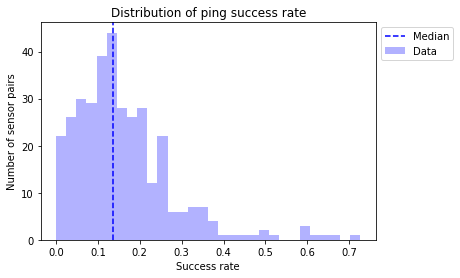

In [54]:
plt.hist(
    ping_success_rate['success_rate'],
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    ping_success_rate['success_rate'].median(),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe. Note that this will omit the handful of pairs with no ping data, but that will only affect the far left side of the chart.

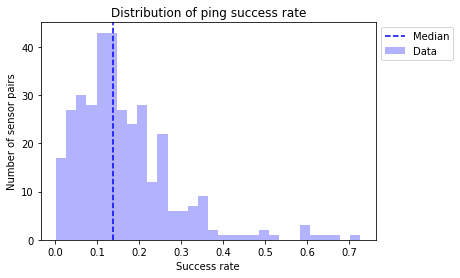

In [55]:
ping_count = usable_data.groupby(['remote_id', 'local_id']).agg({'observed_at': 'nunique'}).rename(columns={'observed_at': 'N'})
ping_count['N'] = ping_count['N']/num_timesteps
ping_count = ping_count.rename(columns={'N': 'success_rate'})
plt.hist(
    ping_count['success_rate'],
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    ping_count['success_rate'].median(),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('Success rate')
plt.ylabel('Number of sensor pairs')
plt.title('Distribution of ping success rate')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

We don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median success rate (about 13.5%) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

### Signal strength

Now we want to look at the distribution of measured RSSI values, but we need to take care to remove the zero values where no ping was received.

In [56]:
measured_rssi_values = y_continuous_t[y_continuous_t != 0.0]

Calculate the median observed RSSI value.

In [57]:
np.median(measured_rssi_values)

-80.0

Plot a histogram.

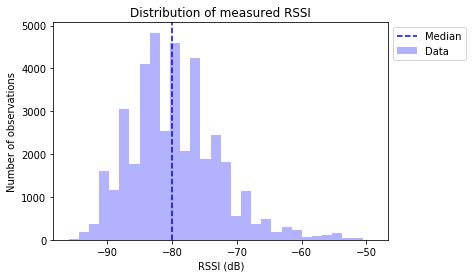

In [58]:
plt.hist(
    measured_rssi_values,
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    np.median(measured_rssi_values),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

As a rough check on our data restructuring above, we can run the same histogram from the original dataframe.

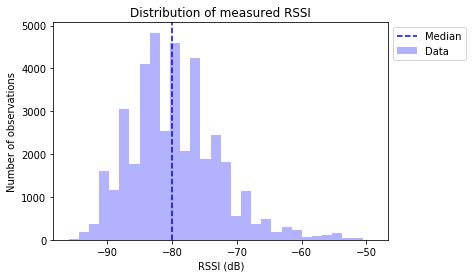

In [59]:
plt.hist(
    usable_data['rssi'],
    bins=30,
    facecolor='blue',
    alpha=0.3,
    label='Data')
plt.axvline(
    usable_data['rssi'].median(),
    linestyle='dashed',
    color='blue',
    label='Median')
plt.xlabel('RSSI (dB)')
plt.ylabel('Number of observations')
plt.title('Distribution of measured RSSI')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

Again, we don't know how this lines up with distance because we don't have ground truth distance data, but we might guess that the median measured RSSI value (about -80 dB) is typical for the presumed median distance between sensors (about 10 meters, roughly half the length of the room).

## Explore and visualize model inputs

Generate 1,000 samples of `x_initial_sample()` and check that they have the properties we expect.

In [60]:
x_discrete_initial_samples, x_continuous_initial_samples = sensor_model.x_initial_sample(1000)

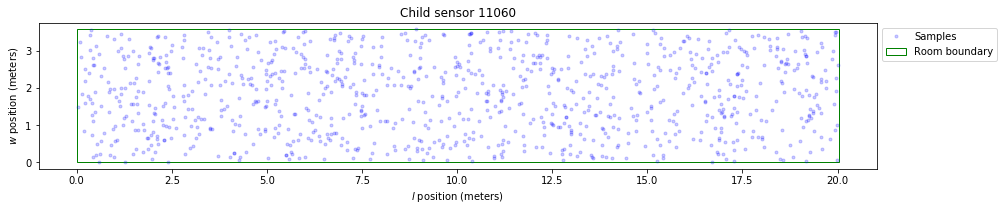

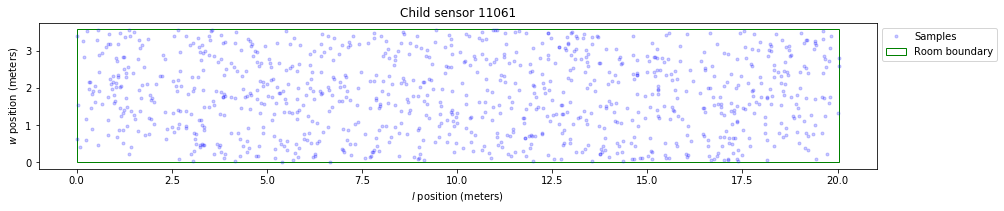

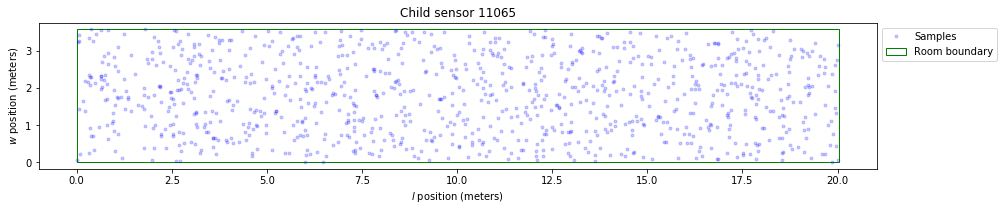

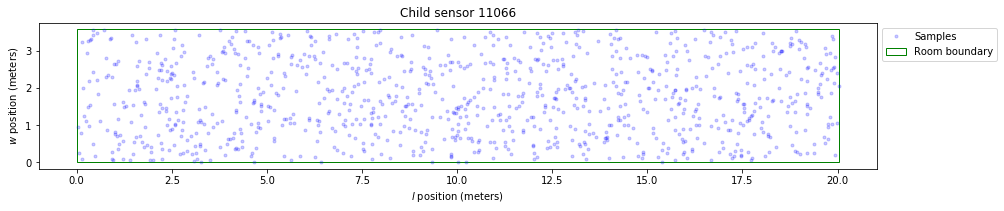

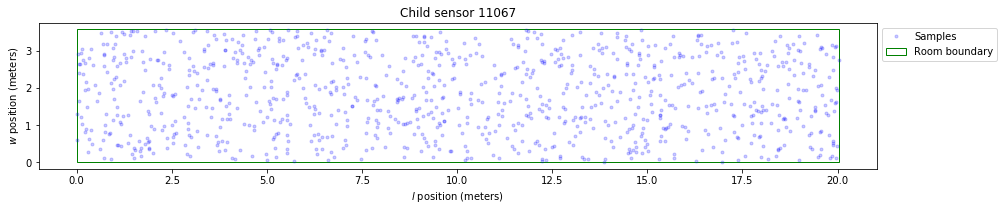

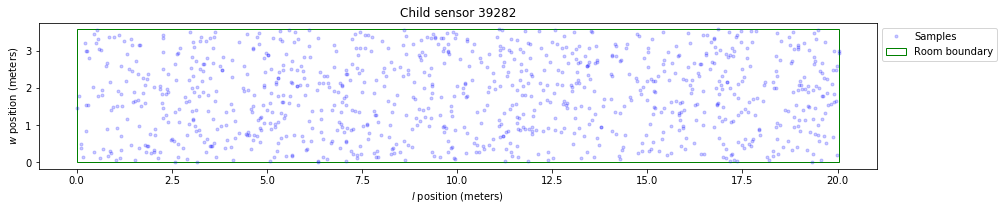

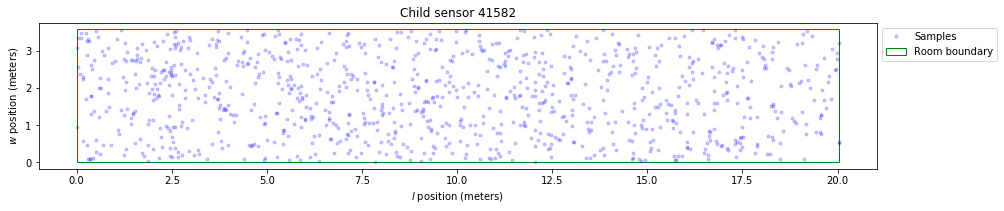

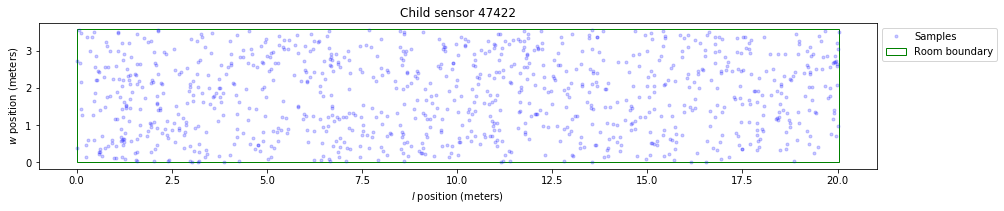

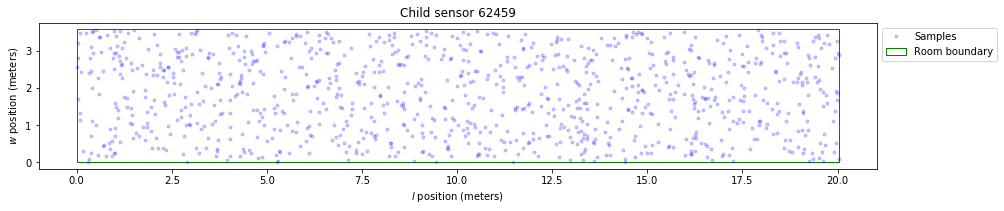

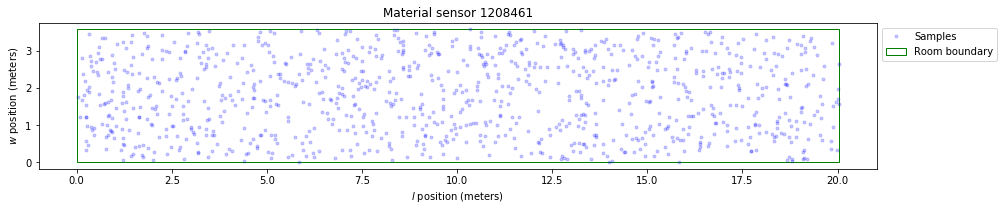

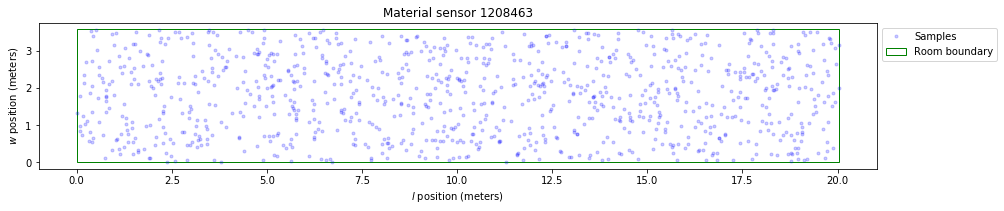

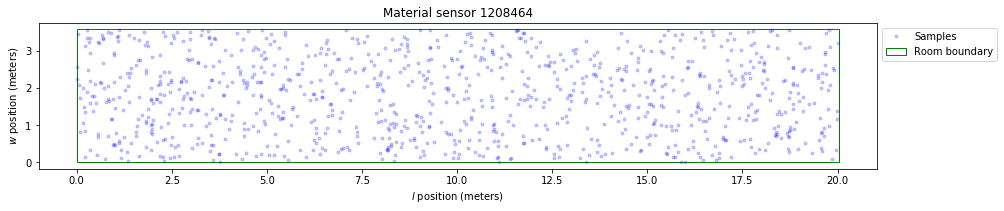

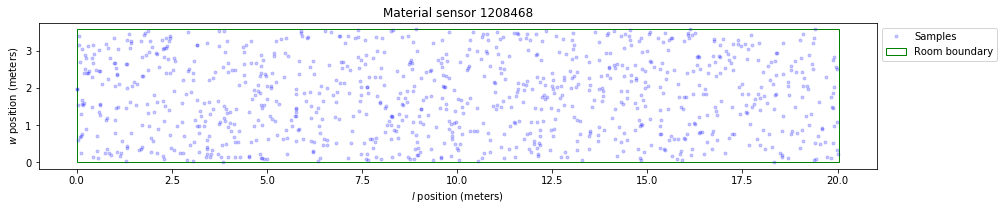

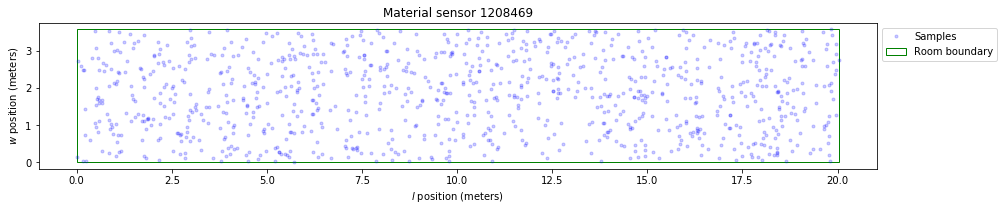

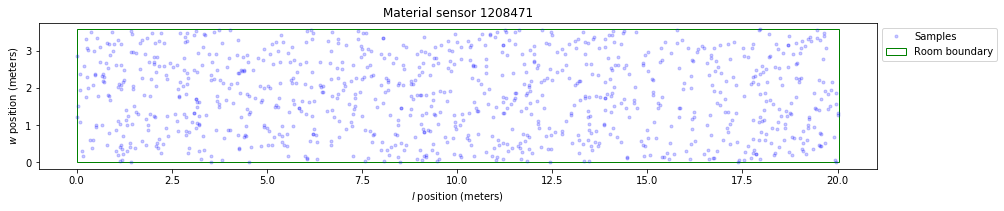

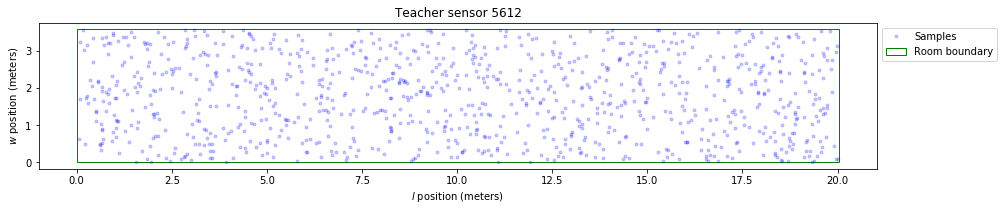

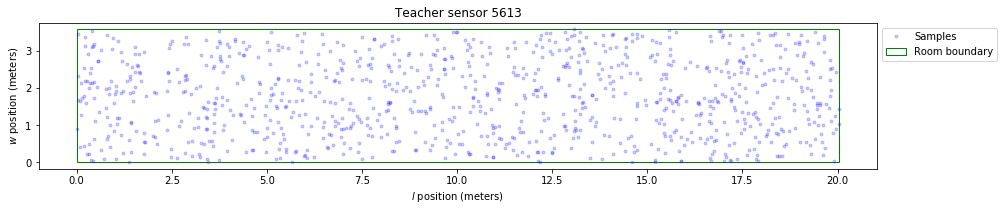

In [61]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_initial_samples[:,sensor_index*2],
        x_continuous_initial_samples[:,sensor_index*2 + 1],
        'b.',
        alpha = 0.2,
        label="Samples")
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Choose an arbitrary test value for $\mathbf{X}$, drawn from the initial distribution, that we can use to test the various functions below.

In [62]:
test_x_discrete_value, test_x_continuous_value = sensor_model.x_initial_sample()

Generate 1,000 samples from `x_bar_x_previous_sample()` (using our test value for $\mathbf{X}_{t-1}$) to make sure they have the properties we expect.

In [63]:
x_discrete_bar_x_previous_samples, x_continuous_bar_x_previous_samples = sensor_model.x_bar_x_previous_sample(
    np.array([]),
    np.tile(test_x_continuous_value, (1000,1)),
    np.timedelta64(10, 's'))

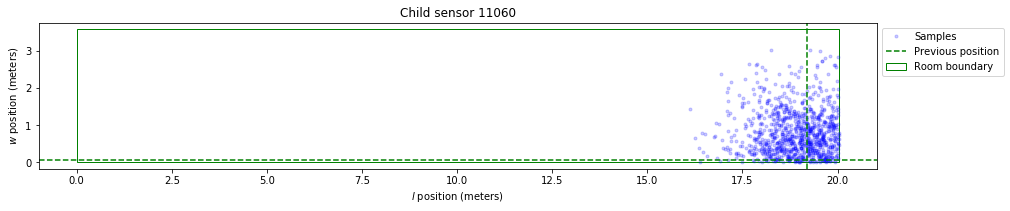

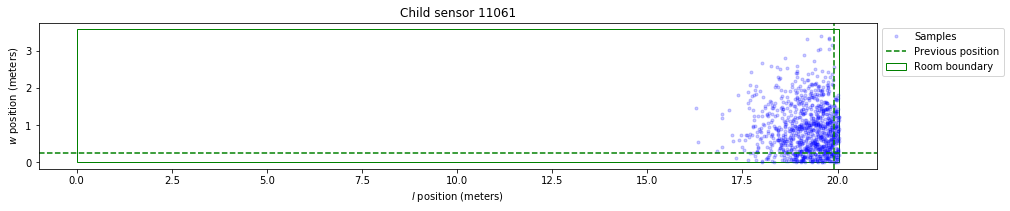

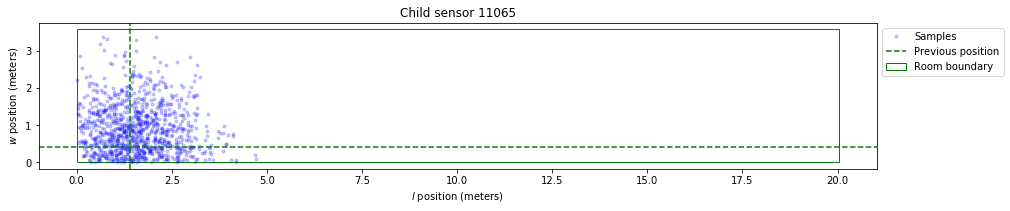

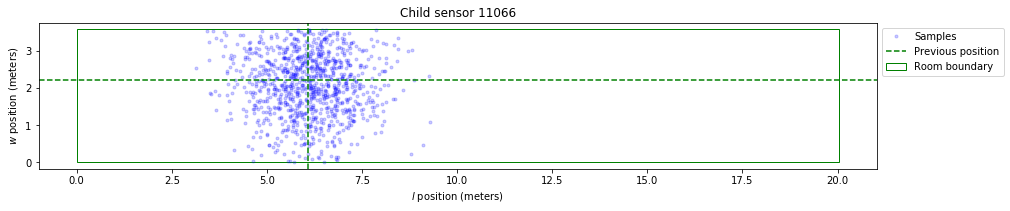

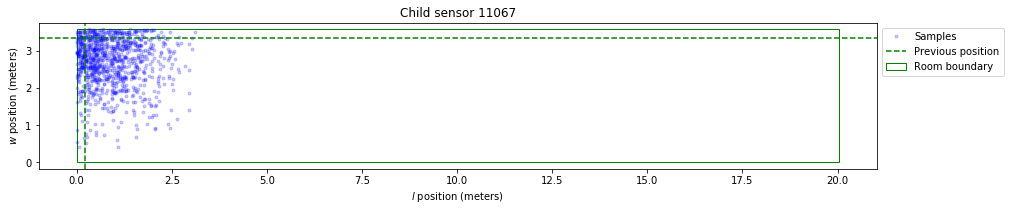

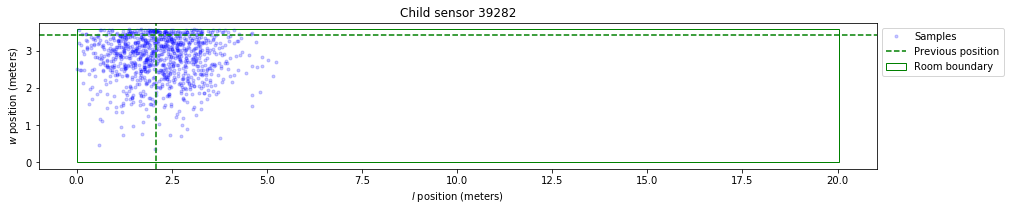

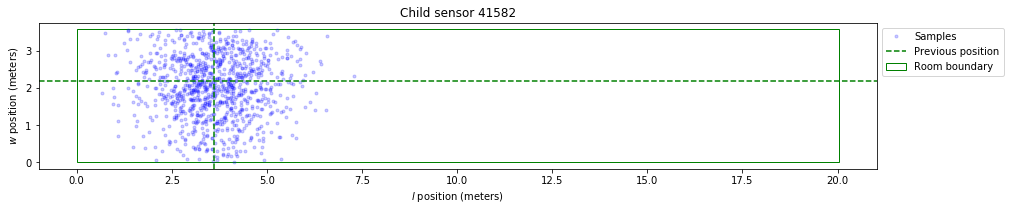

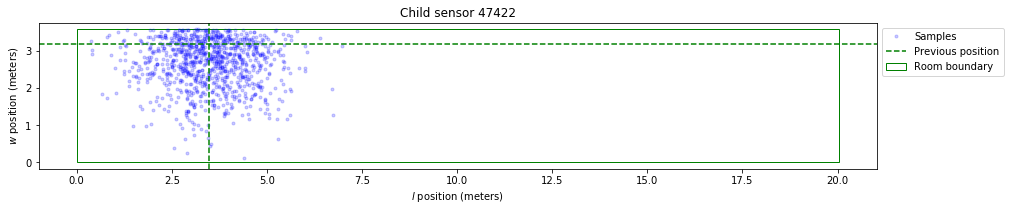

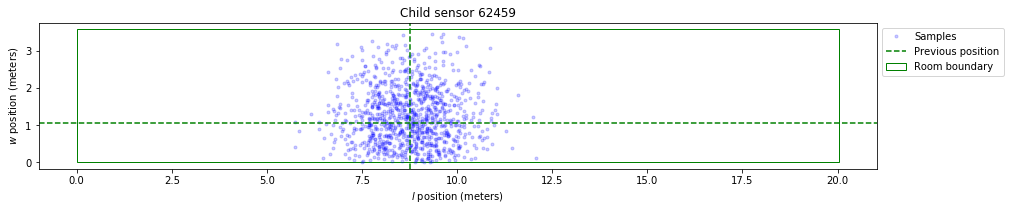

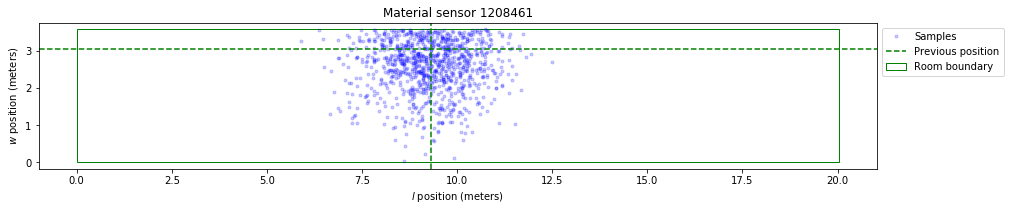

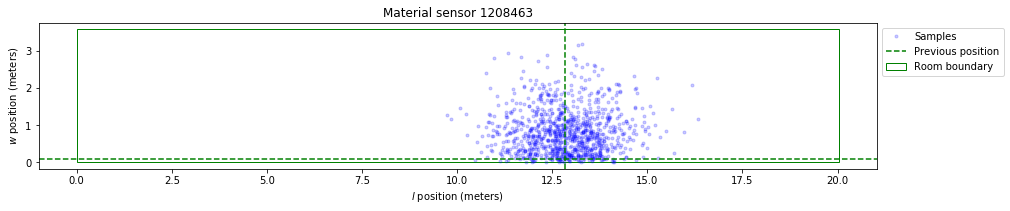

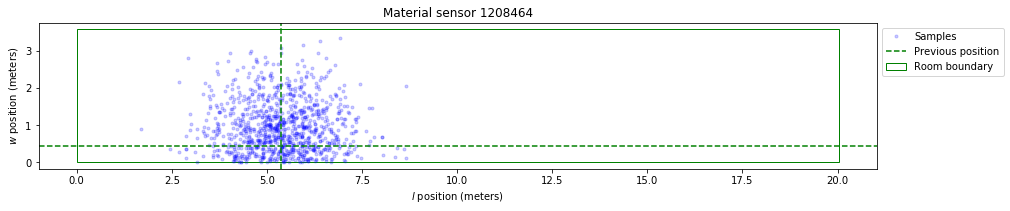

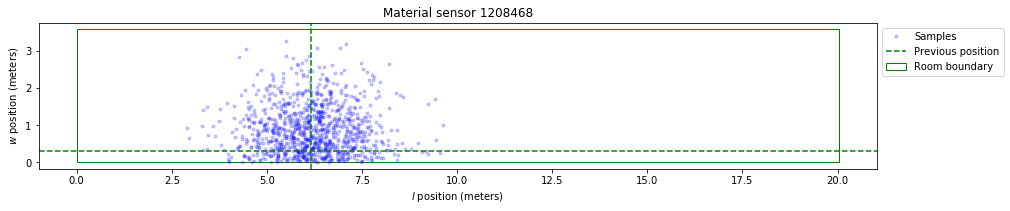

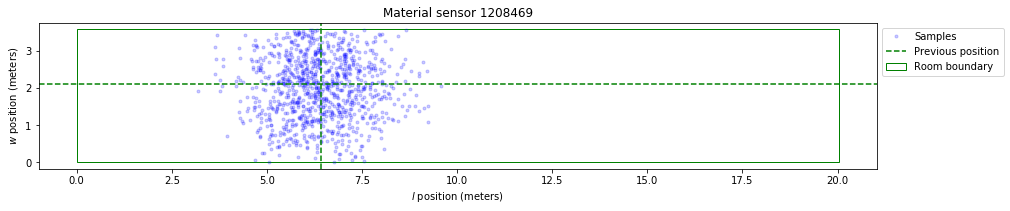

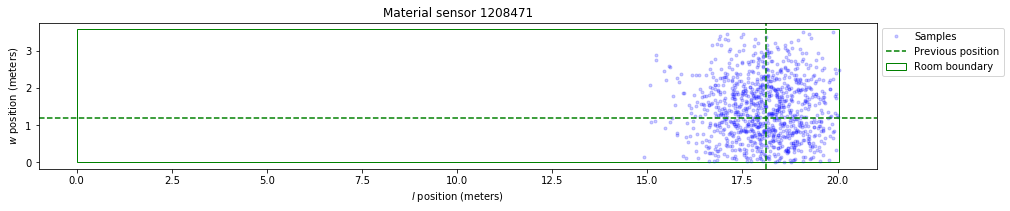

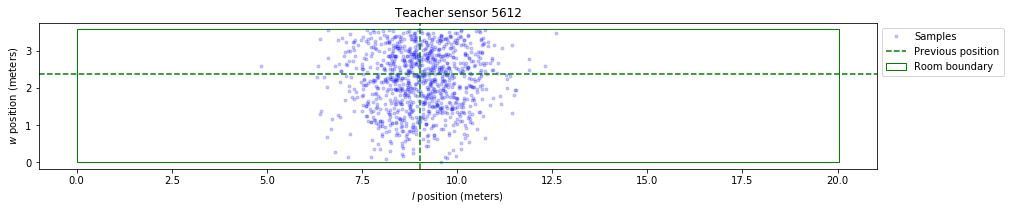

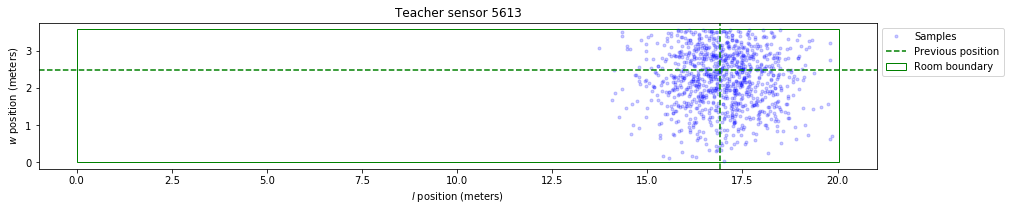

In [64]:
plt.rcParams["figure.figsize"] = room_size*0.75
for sensor_index in range(variable_structure.num_moving_sensors):
    plt.plot(
        x_continuous_bar_x_previous_samples[:,sensor_index*2],
        x_continuous_bar_x_previous_samples[:,sensor_index*2 + 1],
        'b.',
        alpha=0.2,
        label='Samples')
    plt.title(variable_structure.sensor_names[sensor_index])
    plt.xlabel('{} position (meters)'.format(variable_structure.dimension_names[0]))
    plt.ylabel('{} position (meters)'.format(variable_structure.dimension_names[1]))
    plt.axvline(
        x=test_x_continuous_value[sensor_index*2],
        linestyle='dashed',
        color='green',
        label='Previous position')
    plt.axhline(y=test_x_continuous_value[sensor_index*2 + 1], linestyle='dashed', color='green')
    ax=plt.gca()
    ax.add_patch(
        patches.Rectangle(
            (0,0),
            room_size[0],
            room_size[1],
            fill=False,
            color='green',
            label='Room boundary'))
    plt.xlim(0 - 0.05*room_size[0], room_size[0] + 0.05*room_size[0])
    plt.ylim(0 - 0.05*room_size[1], room_size[1] + 0.05*room_size[1])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["figure.figsize"] = plt.rcParamsDefault['figure.figsize']

Generate 1,000 samples from `y_discrete_bar_x_sample()` (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [65]:
y_discrete_bar_x_samples = sensor_model.y_discrete_bar_x_sample(
    np.tile(test_x_discrete_value, (1000,1)),
    np.tile(test_x_continuous_value, (1000,1)))

In [66]:
distances_test_x_continuous_value = sensor_model.distances(sensor_model.sensor_positions(test_x_continuous_value))

Plot the results for 10 randomly chosen discrete $\mathbf{Y}$ variables.

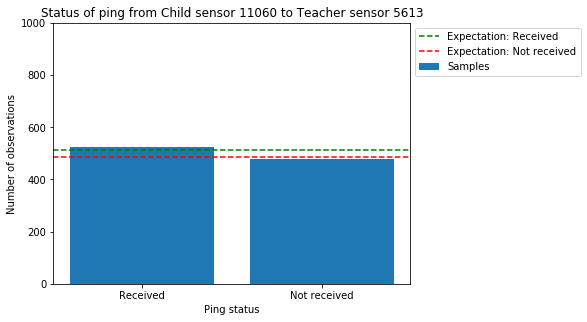

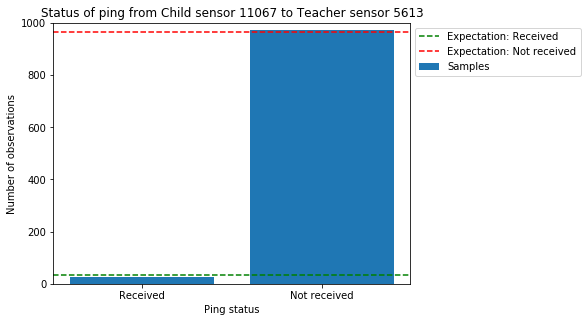

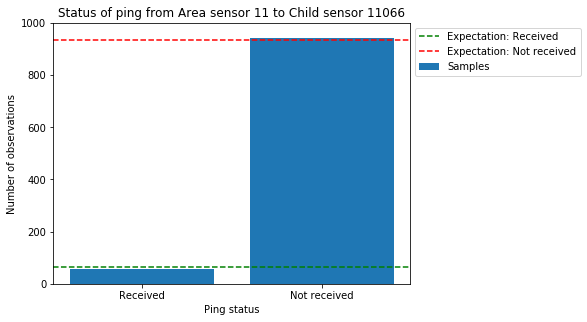

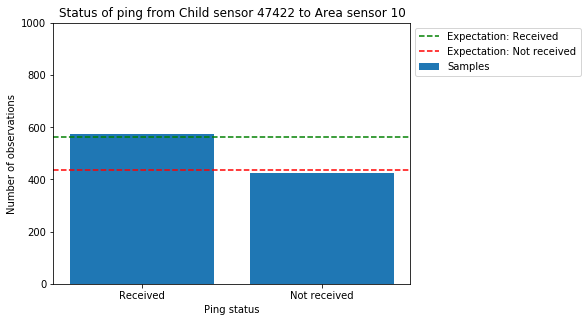

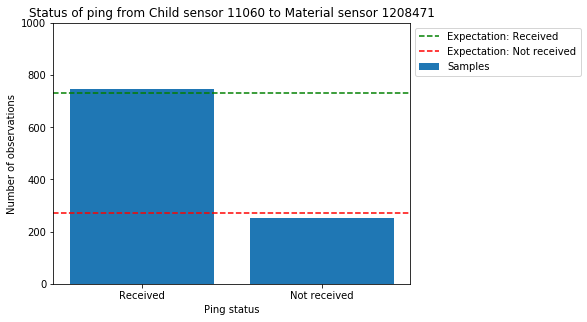

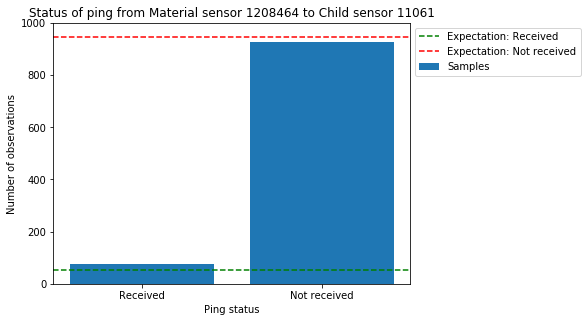

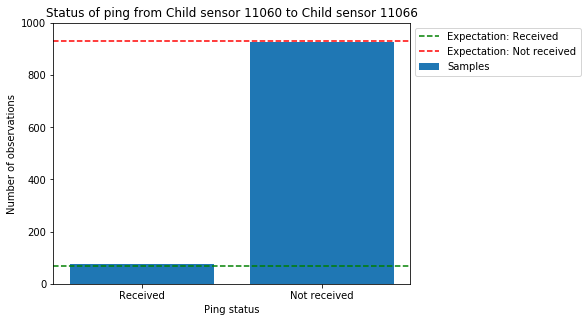

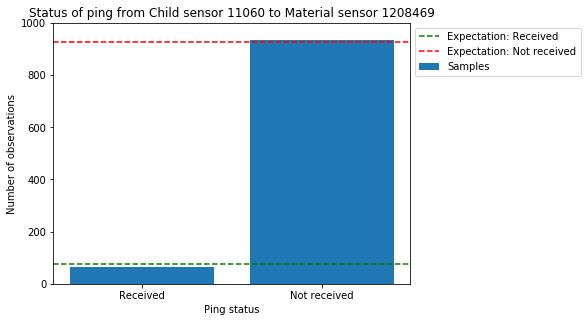

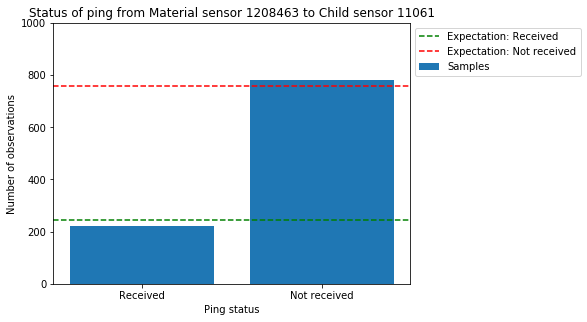

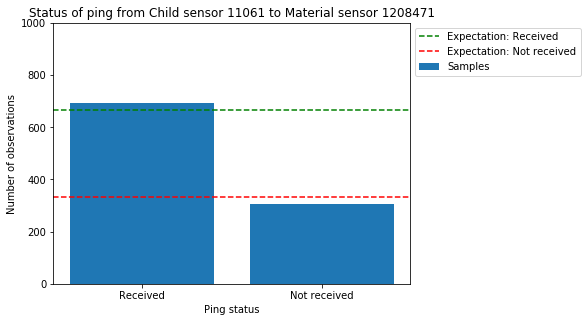

In [67]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.bincount(y_discrete_bar_x_samples[:,y_discrete_var_index]),
        label='Samples')
    for ping_status_index in range(variable_structure.num_ping_statuses):
        plt.axhline(
            y=sensor_model.ping_success_probabilities_array(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index]*1000,
            linestyle='dashed',
            color=['green', 'red'][ping_status_index],
            label='Expectation: {}'.format(variable_structure.ping_status_names[ping_status_index]))
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.xlabel('Ping status')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.ylim(0, 1000)
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Generate 100,000 samples from `y_continuous_bar_x_sample()` (using our test value for $\mathbf{X}$) to make sure they have the properties we expect.

In [68]:
y_continuous_bar_x_samples = sensor_model.y_continuous_bar_x_sample(
    np.tile(test_x_discrete_value, (100000, 1)),
    np.tile(test_x_continuous_value, (100000, 1)))

Plot these samples for 10 randomly chosen continuous $\mathbf{Y}$ variables.

C:\Users\tcqui\Anaconda2\lib\site-packages\scipy\stats\_continuous_distns.py:4870: RuntimeWarning: invalid value encountered in multiply
  mu2 = 1 + (a*pA - b*pB) / d - mu*mu


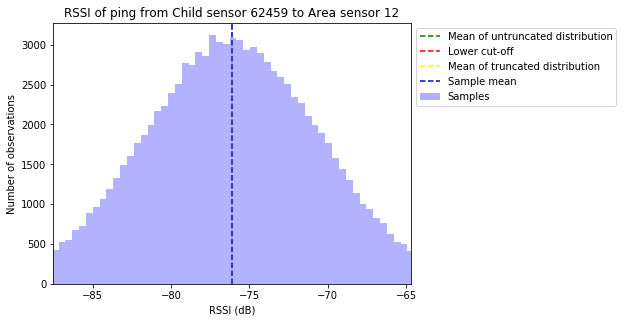

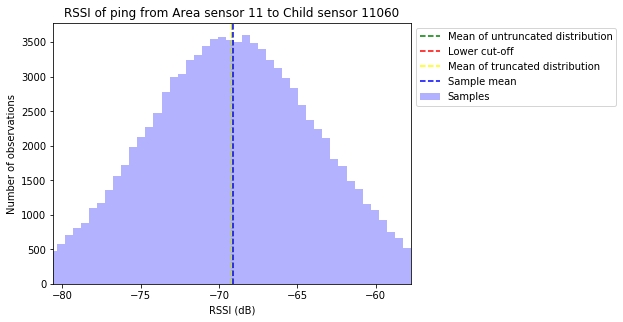

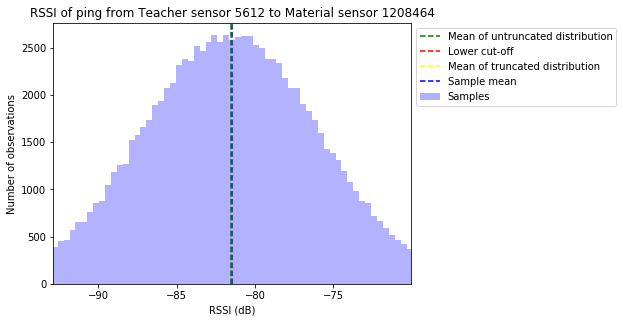

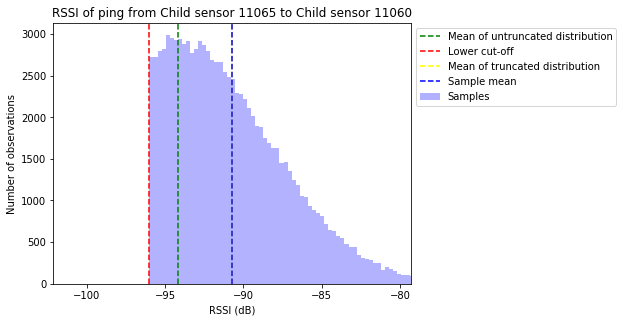

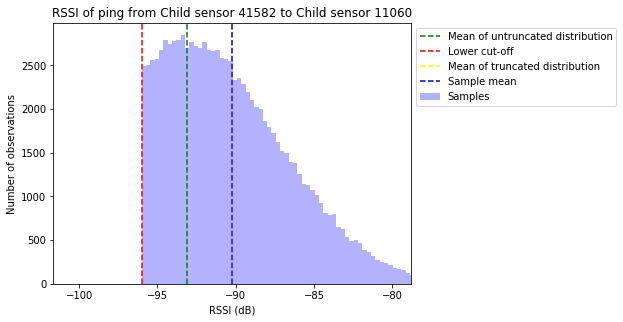

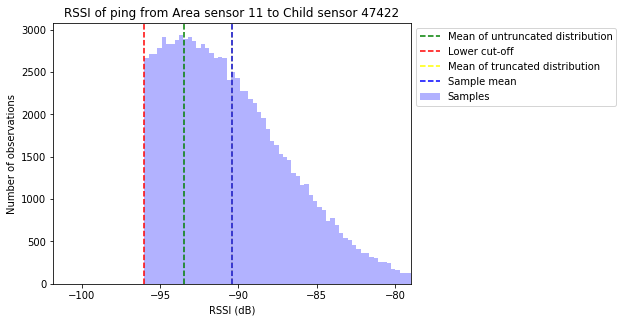

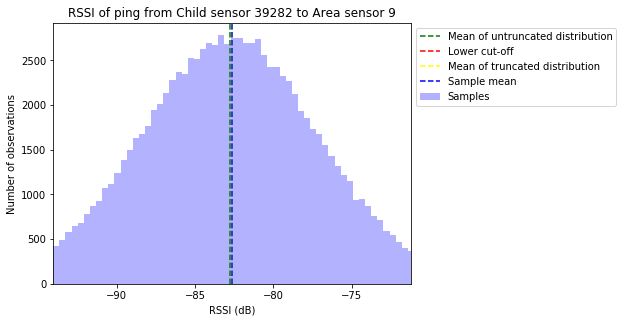

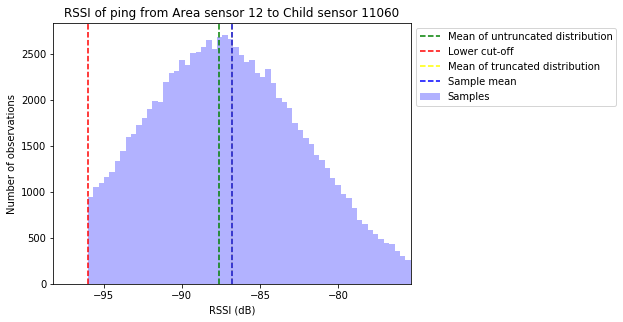

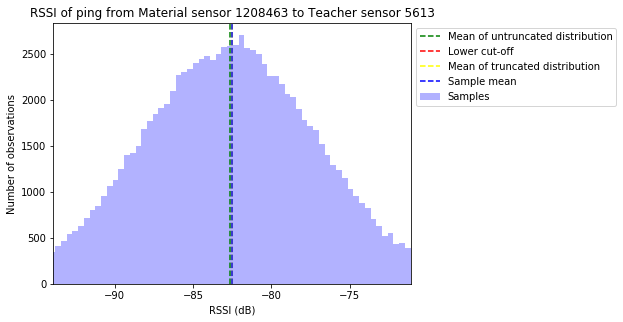

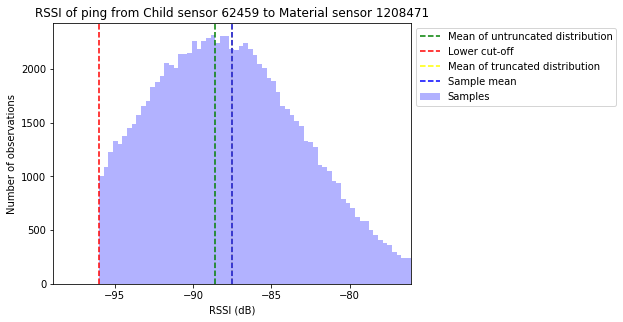

In [69]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.hist(
        y_continuous_bar_x_samples[:,y_continuous_var_index],
        bins=100,
        facecolor='blue',
        alpha=0.3,
        label='Samples')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.axvline(
        np.mean(y_continuous_bar_x_samples[:,y_continuous_var_index]),
        linestyle='dashed',
        color='blue',
        label='Sample mean')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Number of observations')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.xlim(
        sensor_model.rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) - 2*sensor_model.rssi_untruncated_std_dev,
        sensor_model.rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]) + 2*sensor_model.rssi_untruncated_std_dev)
    plt.show()

Using our test value for $\mathbf{X}$, plot the dependence of $f(\mathbf{Y} | \mathbf{X})$ on each sensor reading (holding the values of all of the other sensor readings fixed), to make sure it has the shape we expect. First we plot the dependence on the discrete sensor variables for 10 randomly chosen variables.

[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.1e-05 dists: 5.5e-05 trunc: 5.1e-06
[y_bar_x_log_pdf] Dist: 2.9e-04 ProbArray: 8.4e-05 Discrete: 3.3e-05 Cont: 4.8e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 2.1e-05 dists: 6.5e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 4.3e-04 ProbArray: 2.7e-04 Discrete: 2.2e-04 Cont: 8.7e-04
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 3.8e-05 dists: 1.1e-04 trunc: 3.4e-05
[y_bar_x_log_pdf] Dist: 4.2e-04 ProbArray: 9.8e-05 Discrete: 4.7e-05 Cont: 3.7e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.1e-05 dists: 5.6e-05 trunc: 5.5e-06
[y_bar_x_log_pdf] Dist: 2.7e-04 ProbArray: 9.2e-05 Discrete: 4.2e-05 Cont: 2.7e-04
[rssi_log_pdf] rssi_scale: 3.7e-05 a_scale: 3.2e-05 dists: 1.8e-04 trunc: 5.7e-05
[y_bar_x_log_pdf] Dist: 2.3e-04 ProbArray: 1.0e-04 Discrete: 6.4e-05 Cont: 6.7e-04
[rssi_log_pdf] rssi_scale: 8.1e-05 a_scale: 2.2e-04 dists: 3.9e-04 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 3.9e-04 ProbArray: 2.6e-04 Discrete: 1.2e-04 Cont: 8.6e-04
[rssi_log_

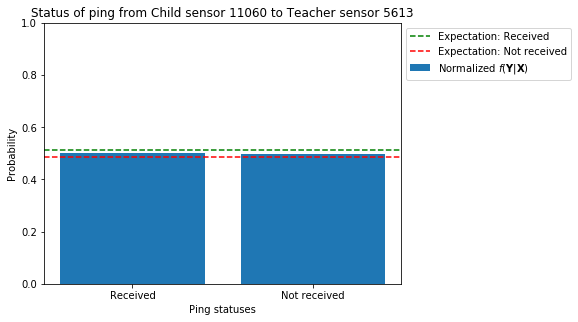

[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 2.8e-05 dists: 7.4e-05 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 3.7e-04 ProbArray: 9.2e-05 Discrete: 4.4e-05 Cont: 4.6e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.1e-05 dists: 1.4e-04 trunc: 8.5e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 4.6e-05 Discrete: 3.2e-05 Cont: 3.5e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 1.9e-05 dists: 9.4e-05 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 1.1e-03 ProbArray: 7.4e-05 Discrete: 4.7e-05 Cont: 4.1e-04
[rssi_log_pdf] rssi_scale: 1.8e-05 a_scale: 1.1e-05 dists: 4.7e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.1e-04 ProbArray: 1.4e-04 Discrete: 9.9e-05 Cont: 2.8e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 5.1e-05 dists: 1.2e-04 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 6.5e-05 Discrete: 2.8e-05 Cont: 2.6e-04
[rssi_log_pdf] rssi_scale: 1.3e-05 a_scale: 1.0e-05 dists: 9.5e-05 trunc: 3.8e-05
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 6.6e-05 Discrete: 2.7e-05 Cont: 2.3e-04
[rssi_log_

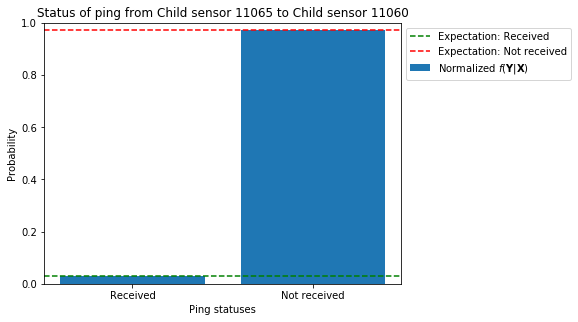

[rssi_log_pdf] rssi_scale: 4.4e-05 a_scale: 1.3e-05 dists: 5.4e-05 trunc: 9.8e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 9.9e-05 Discrete: 2.1e-04 Cont: 2.8e-04
[rssi_log_pdf] rssi_scale: 2.0e-05 a_scale: 1.2e-05 dists: 5.0e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 1.2e-04 Discrete: 1.7e-04 Cont: 2.3e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 3.4e-05 dists: 6.6e-05 trunc: 9.0e-06
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 1.1e-04 Discrete: 1.3e-04 Cont: 2.6e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 7.6e-05 trunc: 9.0e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 1.0e-04 Discrete: 9.4e-05 Cont: 3.1e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 1.9e-05 dists: 6.3e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 2.9e-04 ProbArray: 1.1e-04 Discrete: 1.2e-04 Cont: 2.2e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 1.9e-05 dists: 6.2e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 9.4e-05 Discrete: 8.8e-05 Cont: 1.9e-04
[rssi_log_

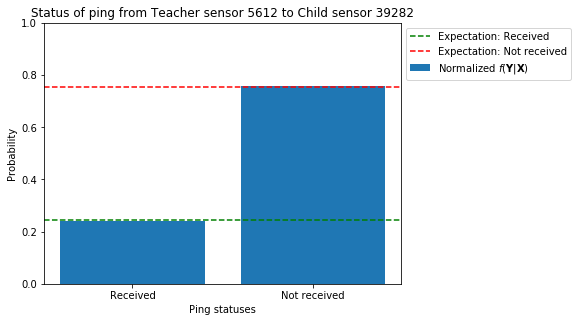

[rssi_log_pdf] rssi_scale: 4.4e-05 a_scale: 3.0e-05 dists: 8.4e-05 trunc: 1.4e-05
[y_bar_x_log_pdf] Dist: 3.1e-04 ProbArray: 1.2e-04 Discrete: 6.0e-05 Cont: 3.9e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 1.9e-05 dists: 7.0e-05 trunc: 1.5e-05
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 1.1e-04 Discrete: 1.2e-04 Cont: 2.3e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 7.9e-05 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.4e-04 Discrete: 7.8e-05 Cont: 3.4e-04
[rssi_log_pdf] rssi_scale: 3.4e-05 a_scale: 1.9e-05 dists: 6.4e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 9.9e-05 Discrete: 1.1e-04 Cont: 2.3e-04
[rssi_log_pdf] rssi_scale: 3.0e-05 a_scale: 1.2e-05 dists: 4.7e-05 trunc: 9.4e-06
[y_bar_x_log_pdf] Dist: 2.2e-04 ProbArray: 9.8e-05 Discrete: 1.2e-04 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 4.3e-05 a_scale: 8.5e-05 dists: 2.8e-04 trunc: 6.8e-05
[y_bar_x_log_pdf] Dist: 3.7e-04 ProbArray: 1.7e-04 Discrete: 1.2e-04 Cont: 8.8e-04
[rssi_log_

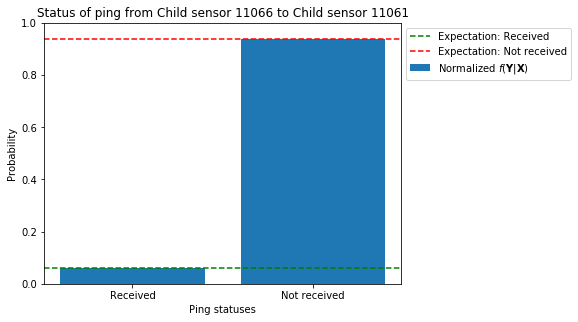

[rssi_log_pdf] rssi_scale: 5.3e-05 a_scale: 1.9e-05 dists: 9.3e-05 trunc: 1.4e-05
[y_bar_x_log_pdf] Dist: 6.4e-04 ProbArray: 2.7e-04 Discrete: 5.6e-05 Cont: 1.7e-03
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.1e-05 dists: 4.8e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 5.4e-04 ProbArray: 6.9e-05 Discrete: 5.1e-05 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 1.1e-05 dists: 6.6e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.0e-04 Discrete: 1.1e-04 Cont: 1.9e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 1.0e-05 dists: 4.5e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 2.3e-04 ProbArray: 1.0e-04 Discrete: 9.9e-05 Cont: 1.8e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 2.0e-05 dists: 6.4e-05 trunc: 6.4e-06
[y_bar_x_log_pdf] Dist: 2.8e-04 ProbArray: 1.4e-04 Discrete: 7.5e-05 Cont: 3.0e-04
[rssi_log_pdf] rssi_scale: 3.3e-05 a_scale: 1.2e-05 dists: 7.3e-05 trunc: 9.0e-06
[y_bar_x_log_pdf] Dist: 3.6e-04 ProbArray: 1.6e-04 Discrete: 1.3e-04 Cont: 3.6e-04
[rssi_log_

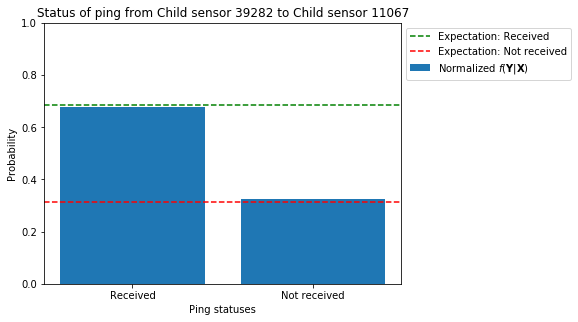

[rssi_log_pdf] rssi_scale: 5.0e-05 a_scale: 2.9e-05 dists: 7.1e-05 trunc: 1.0e-05
[y_bar_x_log_pdf] Dist: 2.8e-04 ProbArray: 9.9e-05 Discrete: 1.4e-04 Cont: 5.2e-04
[rssi_log_pdf] rssi_scale: 2.9e-05 a_scale: 2.3e-05 dists: 1.6e-04 trunc: 9.4e-06
[y_bar_x_log_pdf] Dist: 5.2e-04 ProbArray: 3.1e-04 Discrete: 5.2e-05 Cont: 5.2e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 2.0e-04 trunc: 5.8e-05
[y_bar_x_log_pdf] Dist: 5.7e-04 ProbArray: 1.8e-04 Discrete: 6.3e-05 Cont: 4.2e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 5.7e-05 dists: 1.6e-04 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 9.9e-05 Discrete: 9.1e-05 Cont: 3.6e-04
[rssi_log_pdf] rssi_scale: 5.2e-05 a_scale: 4.8e-05 dists: 7.4e-05 trunc: 1.0e-05
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.5e-04 Discrete: 7.8e-05 Cont: 4.2e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 1.5e-04 trunc: 6.1e-05
[y_bar_x_log_pdf] Dist: 3.6e-04 ProbArray: 9.0e-05 Discrete: 5.0e-05 Cont: 5.3e-04
[rssi_log_

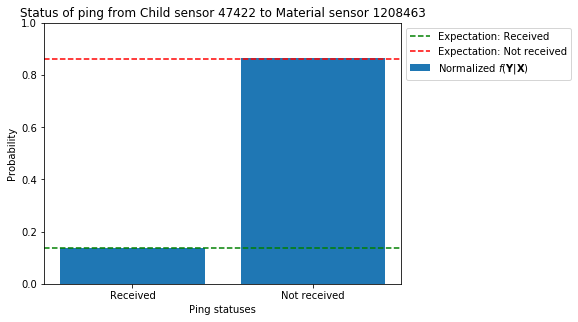

[rssi_log_pdf] rssi_scale: 3.2e-05 a_scale: 2.0e-05 dists: 8.6e-05 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 3.6e-04 ProbArray: 9.6e-05 Discrete: 1.5e-04 Cont: 4.5e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 1.1e-05 dists: 4.6e-05 trunc: 3.4e-05
[y_bar_x_log_pdf] Dist: 3.0e-04 ProbArray: 1.3e-04 Discrete: 8.0e-05 Cont: 3.0e-04
[rssi_log_pdf] rssi_scale: 5.6e-05 a_scale: 1.1e-05 dists: 1.3e-04 trunc: 9.4e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 7.0e-05 Discrete: 2.9e-05 Cont: 3.1e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.0e-05 dists: 4.3e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.3e-04 ProbArray: 8.6e-05 Discrete: 3.1e-05 Cont: 1.8e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 9.8e-06 dists: 4.4e-05 trunc: 5.5e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 4.2e-05 Discrete: 5.3e-05 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.1e-05 dists: 7.5e-05 trunc: 6.4e-06
[y_bar_x_log_pdf] Dist: 4.6e-04 ProbArray: 1.1e-04 Discrete: 3.0e-05 Cont: 2.2e-04
[rssi_log_

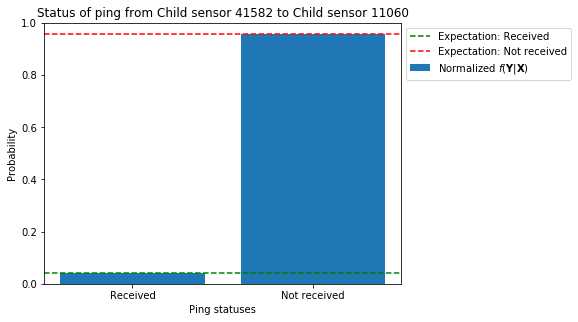

[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 1.9e-05 dists: 6.7e-05 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 1.3e-03 ProbArray: 8.8e-05 Discrete: 5.2e-05 Cont: 3.5e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 6.8e-05 trunc: 9.8e-06
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 6.5e-05 Discrete: 1.4e-04 Cont: 2.8e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 1.9e-05 dists: 1.1e-04 trunc: 6.3e-05
[y_bar_x_log_pdf] Dist: 4.0e-04 ProbArray: 1.0e-04 Discrete: 4.8e-05 Cont: 8.6e-04
[rssi_log_pdf] rssi_scale: 2.0e-05 a_scale: 4.3e-05 dists: 1.3e-04 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 9.1e-05 Discrete: 5.4e-05 Cont: 3.0e-04
[rssi_log_pdf] rssi_scale: 3.2e-05 a_scale: 1.2e-05 dists: 4.7e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.8e-04 Discrete: 1.1e-04 Cont: 2.6e-04
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.1e-05 dists: 4.7e-05 trunc: 5.2e-05
[y_bar_x_log_pdf] Dist: 4.2e-04 ProbArray: 1.1e-04 Discrete: 9.2e-05 Cont: 3.2e-04
[rssi_log_

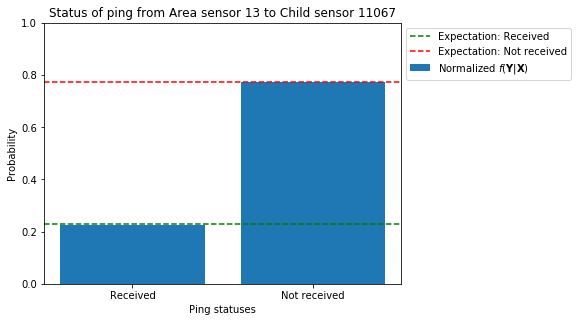

[rssi_log_pdf] rssi_scale: 3.4e-05 a_scale: 1.2e-05 dists: 5.0e-05 trunc: 9.0e-06
[y_bar_x_log_pdf] Dist: 4.1e-04 ProbArray: 2.0e-04 Discrete: 6.1e-05 Cont: 3.6e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 6.5e-05 trunc: 9.8e-06
[y_bar_x_log_pdf] Dist: 2.8e-04 ProbArray: 9.0e-05 Discrete: 1.1e-04 Cont: 2.1e-04
[rssi_log_pdf] rssi_scale: 3.8e-05 a_scale: 3.1e-05 dists: 1.1e-04 trunc: 5.6e-05
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 1.2e-04 Discrete: 6.0e-05 Cont: 4.5e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 4.1e-05 dists: 1.2e-04 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 3.0e-04 ProbArray: 8.7e-05 Discrete: 5.5e-05 Cont: 3.0e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 7.8e-05 trunc: 8.5e-06
[y_bar_x_log_pdf] Dist: 3.4e-04 ProbArray: 1.1e-04 Discrete: 1.1e-04 Cont: 2.9e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 1.9e-05 dists: 7.5e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.5e-04 ProbArray: 1.0e-04 Discrete: 1.6e-04 Cont: 2.4e-04
[rssi_log_

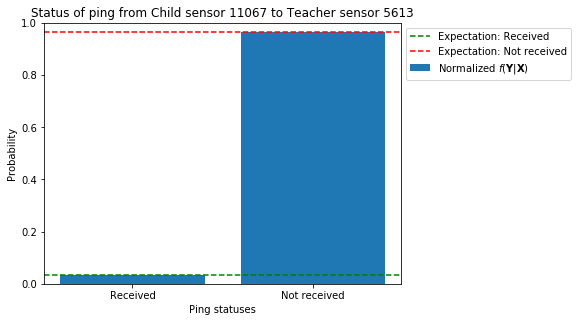

[rssi_log_pdf] rssi_scale: 3.3e-05 a_scale: 1.9e-05 dists: 8.6e-05 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 6.2e-04 ProbArray: 9.6e-05 Discrete: 1.2e-04 Cont: 3.6e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 1.1e-05 dists: 1.5e-04 trunc: 9.8e-06
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 1.1e-04 Discrete: 1.5e-04 Cont: 3.7e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 1.1e-05 dists: 4.6e-05 trunc: 7.3e-06
[y_bar_x_log_pdf] Dist: 4.9e-04 ProbArray: 1.9e-04 Discrete: 8.2e-05 Cont: 2.9e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 1.0e-05 dists: 4.4e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.2e-04 ProbArray: 1.6e-04 Discrete: 1.2e-04 Cont: 1.4e-04
[rssi_log_pdf] rssi_scale: 1.4e-05 a_scale: 1.0e-05 dists: 4.0e-05 trunc: 5.5e-06
[y_bar_x_log_pdf] Dist: 2.7e-04 ProbArray: 6.4e-05 Discrete: 2.7e-05 Cont: 2.8e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.0e-05 dists: 4.1e-05 trunc: 5.5e-06
[y_bar_x_log_pdf] Dist: 2.8e-04 ProbArray: 1.1e-04 Discrete: 5.8e-05 Cont: 2.2e-04
[rssi_log_

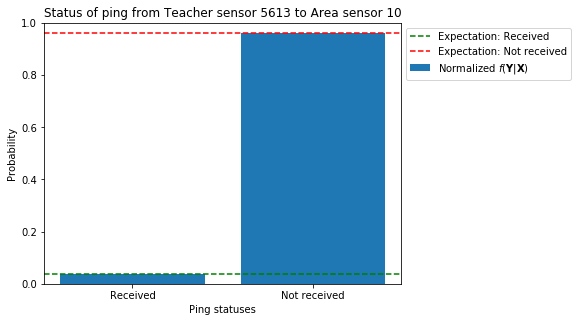

In [70]:
mean_rssi_values = sensor_model.rssi_truncated_mean(distances_test_x_continuous_value)
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    test_y_discrete_value = np.repeat(0, variable_structure.num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_range = np.zeros(2, dtype='float')
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(
        mean_rssi_values[y_discrete_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_discrete_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_discrete_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = sensor_model.y_bar_x_log_pdf(
            test_x_discrete_value,
            test_x_continuous_value,
            test_y_discrete_value,
            test_y_continuous_value)
    log_probability_range[0] = special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0])
    test_y_discrete_value[y_discrete_var_index] = 1
    test_y_continuous_value = mean_rssi_values
    log_probability_range[1] = sensor_model.y_bar_x_log_pdf(
        test_x_discrete_value,
        test_x_continuous_value,
        test_y_discrete_value,
        test_y_continuous_value)
    log_probability_range = log_probability_range - special.logsumexp(log_probability_range)
    plt.bar(
        range(variable_structure.num_ping_statuses),
        np.exp(log_probability_range),
        label='Normalized $f(\mathbf{Y}|\mathbf{X})$')
    for ping_status_index in range(variable_structure.num_ping_statuses):
        plt.axhline(
            y=sensor_model.ping_success_probabilities_array(distances_test_x_continuous_value[y_discrete_var_index])[ping_status_index],
            linestyle='dashed',
            color=['green', 'red'][ping_status_index],
            label='Expectation: {}'.format(variable_structure.ping_status_names[ping_status_index]))
    plt.xticks(range(variable_structure.num_ping_statuses), variable_structure.ping_status_names)
    plt.ylim(0,1)
    plt.xlabel('Ping statuses')
    plt.ylabel('Probability')
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Now we plot the dependence on the continuous sensor variables for 10 randomly chosen variables.

[rssi_log_pdf] rssi_scale: 3.4e-05 a_scale: 2.0e-05 dists: 8.1e-05 trunc: 1.4e-05
[y_bar_x_log_pdf] Dist: 3.7e-04 ProbArray: 9.7e-05 Discrete: 5.0e-05 Cont: 5.0e-04
[rssi_log_pdf] rssi_scale: 2.9e-05 a_scale: 2.7e-05 dists: 7.4e-05 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 1.0e-03 ProbArray: 9.0e-05 Discrete: 5.2e-05 Cont: 4.9e-04
[rssi_log_pdf] rssi_scale: 6.2e-05 a_scale: 2.3e-05 dists: 1.5e-04 trunc: 1.9e-05
[y_bar_x_log_pdf] Dist: 1.1e-03 ProbArray: 1.8e-04 Discrete: 2.4e-04 Cont: 6.3e-04
[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 1.9e-05 dists: 6.7e-05 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 1.6e-04 Discrete: 8.7e-05 Cont: 3.7e-04
[rssi_log_pdf] rssi_scale: 2.4e-05 a_scale: 1.8e-05 dists: 1.8e-04 trunc: 2.5e-05
[y_bar_x_log_pdf] Dist: 5.5e-04 ProbArray: 1.3e-04 Discrete: 5.0e-05 Cont: 5.0e-04
[rssi_log_pdf] rssi_scale: 2.3e-05 a_scale: 1.8e-05 dists: 7.1e-05 trunc: 7.3e-06
[y_bar_x_log_pdf] Dist: 4.4e-04 ProbArray: 2.2e-04 Discrete: 2.0e-04 Cont: 3.3e-04
[rssi_log_

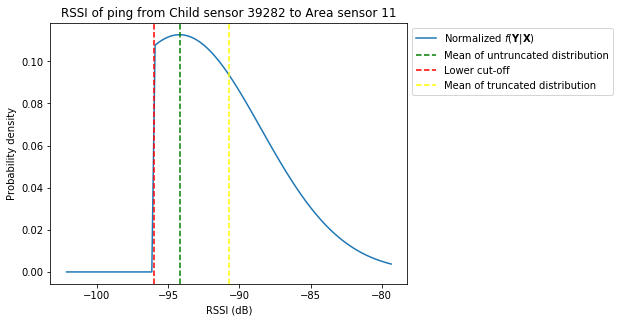

[rssi_log_pdf] rssi_scale: 3.5e-05 a_scale: 2.3e-05 dists: 1.2e-04 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 4.1e-04 ProbArray: 1.1e-04 Discrete: 6.3e-05 Cont: 3.7e-04
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.1e-05 dists: 4.7e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 7.4e-05 Discrete: 1.0e-04 Cont: 2.1e-04
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.1e-05 dists: 4.6e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 1.0e-04 Discrete: 9.8e-05 Cont: 1.8e-04
[rssi_log_pdf] rssi_scale: 3.5e-05 a_scale: 3.4e-05 dists: 6.5e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.2e-04 ProbArray: 9.6e-05 Discrete: 1.2e-04 Cont: 3.3e-04
[rssi_log_pdf] rssi_scale: 1.7e-05 a_scale: 1.0e-05 dists: 4.7e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.2e-04 ProbArray: 1.0e-04 Discrete: 1.0e-04 Cont: 4.0e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 4.1e-05 dists: 1.2e-04 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 8.0e-05 Discrete: 4.6e-05 Cont: 3.0e-04
[rssi_log_

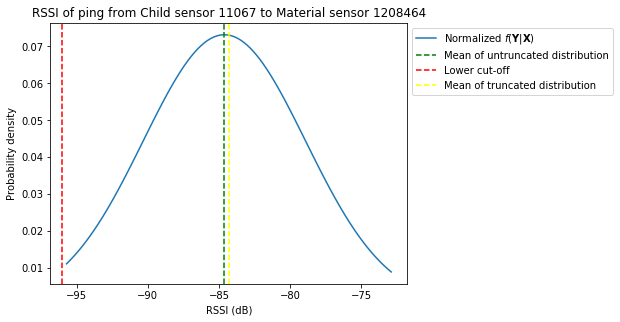

[rssi_log_pdf] rssi_scale: 3.9e-05 a_scale: 3.4e-05 dists: 8.4e-05 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 4.9e-04 ProbArray: 1.2e-04 Discrete: 6.8e-05 Cont: 6.1e-04
[rssi_log_pdf] rssi_scale: 6.2e-05 a_scale: 5.5e-05 dists: 1.4e-04 trunc: 1.2e-05
[y_bar_x_log_pdf] Dist: 5.1e-04 ProbArray: 2.3e-04 Discrete: 1.0e-04 Cont: 5.1e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 1.4e-04 trunc: 3.7e-05
[y_bar_x_log_pdf] Dist: 3.9e-04 ProbArray: 1.0e-04 Discrete: 4.8e-05 Cont: 3.4e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 2.0e-05 dists: 6.6e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 1.1e-04 Discrete: 1.3e-04 Cont: 2.1e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.1e-05 dists: 6.3e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 9.6e-05 Discrete: 1.2e-04 Cont: 3.2e-04
[rssi_log_pdf] rssi_scale: 2.4e-05 a_scale: 2.0e-05 dists: 6.9e-05 trunc: 3.6e-05
[y_bar_x_log_pdf] Dist: 3.0e-04 ProbArray: 1.0e-04 Discrete: 4.5e-05 Cont: 2.7e-04
[rssi_log_

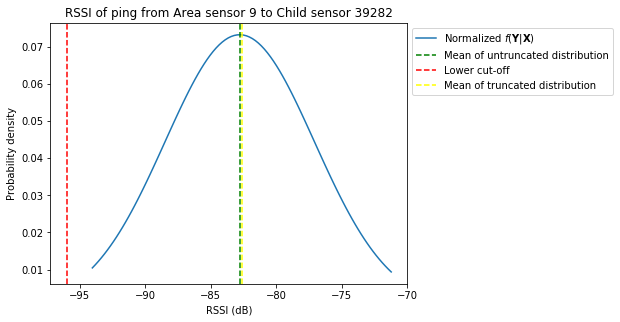

[rssi_log_pdf] rssi_scale: 4.2e-05 a_scale: 3.5e-05 dists: 1.1e-04 trunc: 1.7e-05
[y_bar_x_log_pdf] Dist: 2.8e-04 ProbArray: 1.3e-04 Discrete: 7.6e-05 Cont: 4.7e-04
[rssi_log_pdf] rssi_scale: 3.2e-05 a_scale: 1.2e-05 dists: 4.8e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 3.3e-04 ProbArray: 9.0e-05 Discrete: 8.7e-05 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 2.0e-05 dists: 6.7e-05 trunc: 6.3e-05
[y_bar_x_log_pdf] Dist: 3.9e-04 ProbArray: 1.2e-04 Discrete: 1.1e-04 Cont: 5.8e-04
[rssi_log_pdf] rssi_scale: 5.8e-05 a_scale: 2.0e-05 dists: 1.4e-04 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 3.1e-04 ProbArray: 1.0e-04 Discrete: 4.6e-05 Cont: 3.3e-04
[rssi_log_pdf] rssi_scale: 1.9e-05 a_scale: 1.1e-05 dists: 4.7e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.7e-04 ProbArray: 9.7e-05 Discrete: 1.2e-04 Cont: 2.0e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 1.0e-05 dists: 4.4e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 2.3e-04 ProbArray: 9.7e-05 Discrete: 9.0e-05 Cont: 2.8e-04
[rssi_log_

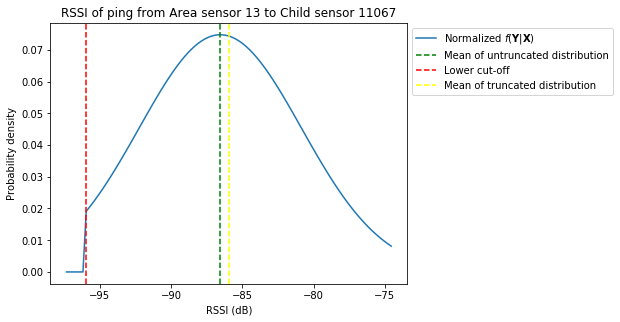

[rssi_log_pdf] rssi_scale: 3.0e-05 a_scale: 1.1e-05 dists: 7.0e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.5e-04 ProbArray: 1.1e-04 Discrete: 5.8e-05 Cont: 4.1e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 2.0e-05 dists: 7.4e-05 trunc: 7.3e-06
[y_bar_x_log_pdf] Dist: 3.4e-04 ProbArray: 1.2e-04 Discrete: 2.1e-04 Cont: 3.3e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 1.1e-05 dists: 4.6e-05 trunc: 5.1e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 1.5e-04 Discrete: 6.3e-05 Cont: 2.4e-04
[rssi_log_pdf] rssi_scale: 1.5e-05 a_scale: 1.1e-05 dists: 5.5e-05 trunc: 4.3e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 9.2e-05 Discrete: 8.3e-05 Cont: 2.4e-04
[rssi_log_pdf] rssi_scale: 1.4e-05 a_scale: 1.0e-05 dists: 8.4e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 1.1e-04 Discrete: 2.8e-05 Cont: 2.6e-04
[rssi_log_pdf] rssi_scale: 1.3e-05 a_scale: 1.0e-05 dists: 4.1e-05 trunc: 3.8e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 9.4e-05 Discrete: 1.2e-04 Cont: 1.3e-04
[rssi_log_

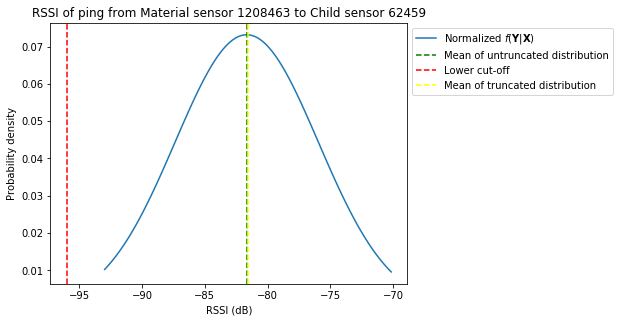

[rssi_log_pdf] rssi_scale: 2.9e-05 a_scale: 1.8e-05 dists: 7.5e-05 trunc: 1.7e-05
[y_bar_x_log_pdf] Dist: 1.1e-03 ProbArray: 8.6e-05 Discrete: 4.7e-05 Cont: 8.4e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 1.9e-05 dists: 6.6e-05 trunc: 9.0e-06
[y_bar_x_log_pdf] Dist: 3.6e-04 ProbArray: 1.2e-04 Discrete: 1.2e-04 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 1.9e-05 dists: 6.3e-05 trunc: 8.5e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.4e-04 Discrete: 8.7e-05 Cont: 2.7e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 3.0e-05 dists: 8.4e-05 trunc: 5.9e-05
[y_bar_x_log_pdf] Dist: 3.9e-04 ProbArray: 9.3e-05 Discrete: 9.9e-05 Cont: 4.1e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 2.0e-05 dists: 7.0e-05 trunc: 1.0e-05
[y_bar_x_log_pdf] Dist: 2.9e-04 ProbArray: 1.0e-04 Discrete: 1.0e-04 Cont: 2.6e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 2.0e-05 dists: 6.5e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 3.1e-04 ProbArray: 1.1e-04 Discrete: 8.0e-05 Cont: 3.2e-04
[rssi_log_

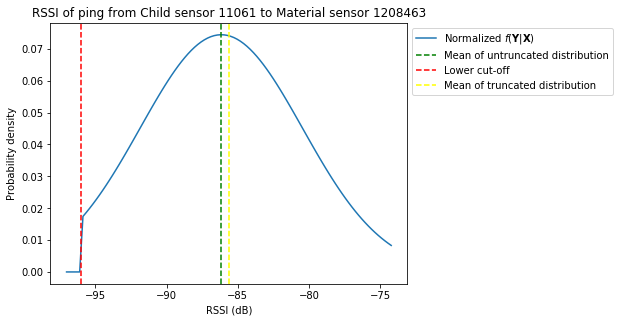

[rssi_log_pdf] rssi_scale: 3.6e-05 a_scale: 5.3e-05 dists: 8.9e-05 trunc: 1.1e-05
[y_bar_x_log_pdf] Dist: 4.8e-04 ProbArray: 1.1e-04 Discrete: 6.1e-05 Cont: 4.0e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 6.8e-05 trunc: 3.8e-05
[y_bar_x_log_pdf] Dist: 3.9e-04 ProbArray: 1.5e-04 Discrete: 8.7e-05 Cont: 3.2e-04
[rssi_log_pdf] rssi_scale: 2.5e-05 a_scale: 1.9e-05 dists: 6.5e-05 trunc: 6.4e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.0e-04 Discrete: 1.1e-04 Cont: 2.1e-04
[rssi_log_pdf] rssi_scale: 2.6e-05 a_scale: 2.0e-05 dists: 6.4e-05 trunc: 6.4e-06
[y_bar_x_log_pdf] Dist: 2.6e-04 ProbArray: 1.4e-04 Discrete: 8.0e-05 Cont: 2.9e-04
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 6.5e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 2.7e-04 ProbArray: 1.2e-04 Discrete: 1.4e-04 Cont: 2.2e-04
[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 2.1e-05 dists: 6.8e-05 trunc: 7.3e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 1.1e-04 Discrete: 1.6e-04 Cont: 3.2e-04
[rssi_log_

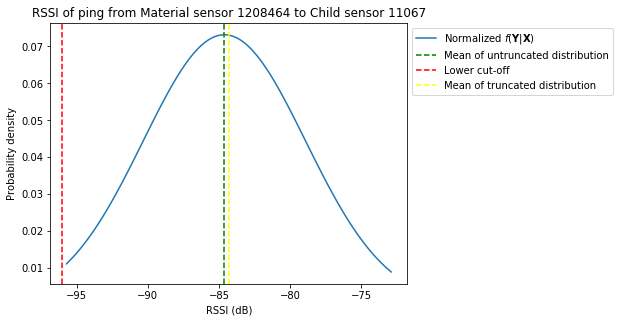

[rssi_log_pdf] rssi_scale: 2.4e-05 a_scale: 1.5e-05 dists: 6.8e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 6.3e-04 ProbArray: 1.1e-04 Discrete: 6.1e-05 Cont: 4.6e-04
[rssi_log_pdf] rssi_scale: 3.5e-05 a_scale: 4.3e-05 dists: 5.0e-05 trunc: 6.0e-06
[y_bar_x_log_pdf] Dist: 5.5e-04 ProbArray: 9.1e-05 Discrete: 1.1e-04 Cont: 4.3e-04
[rssi_log_pdf] rssi_scale: 4.3e-05 a_scale: 1.2e-05 dists: 4.8e-05 trunc: 4.7e-06
[y_bar_x_log_pdf] Dist: 2.4e-04 ProbArray: 9.5e-05 Discrete: 1.1e-04 Cont: 1.9e-04
[rssi_log_pdf] rssi_scale: 1.6e-05 a_scale: 7.6e-05 dists: 6.1e-05 trunc: 4.3e-06
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 6.9e-05 Discrete: 2.9e-05 Cont: 3.1e-04
[rssi_log_pdf] rssi_scale: 1.3e-05 a_scale: 1.0e-05 dists: 4.0e-05 trunc: 3.8e-06
[y_bar_x_log_pdf] Dist: 2.1e-04 ProbArray: 7.0e-05 Discrete: 2.8e-05 Cont: 1.7e-04
[rssi_log_pdf] rssi_scale: 1.3e-05 a_scale: 9.8e-06 dists: 3.8e-05 trunc: 3.4e-06
[y_bar_x_log_pdf] Dist: 2.0e-04 ProbArray: 1.3e-04 Discrete: 3.8e-05 Cont: 1.9e-04
[rssi_log_

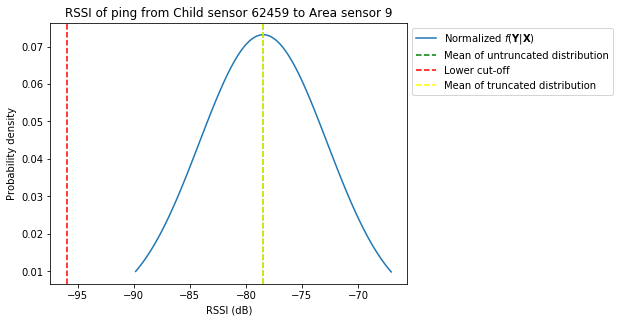

[rssi_log_pdf] rssi_scale: 2.9e-05 a_scale: 2.0e-05 dists: 6.9e-05 trunc: 1.3e-05
[y_bar_x_log_pdf] Dist: 1.8e-04 ProbArray: 7.3e-05 Discrete: 5.5e-05 Cont: 1.8e-03
[rssi_log_pdf] rssi_scale: 3.5e-05 a_scale: 2.2e-05 dists: 7.0e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 6.2e-04 ProbArray: 9.6e-05 Discrete: 5.5e-05 Cont: 3.3e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 2.2e-05 dists: 7.3e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.6e-04 ProbArray: 1.4e-04 Discrete: 1.5e-04 Cont: 3.1e-04
[rssi_log_pdf] rssi_scale: 6.6e-05 a_scale: 2.4e-05 dists: 3.0e-04 trunc: 1.6e-05
[y_bar_x_log_pdf] Dist: 4.5e-04 ProbArray: 1.2e-04 Discrete: 5.6e-05 Cont: 7.3e-04
[rssi_log_pdf] rssi_scale: 3.2e-05 a_scale: 1.7e-05 dists: 1.4e-04 trunc: 3.5e-05
[y_bar_x_log_pdf] Dist: 3.5e-04 ProbArray: 8.2e-05 Discrete: 9.2e-05 Cont: 1.1e-03
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 2.3e-05 dists: 8.4e-05 trunc: 8.1e-06
[y_bar_x_log_pdf] Dist: 3.8e-04 ProbArray: 1.3e-04 Discrete: 6.3e-05 Cont: 2.9e-04
[rssi_log_

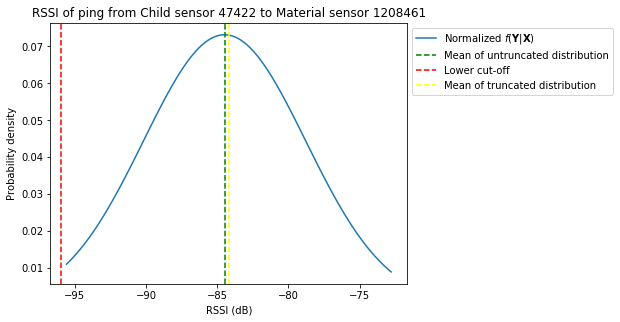

[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 1.2e-05 dists: 5.4e-05 trunc: 6.8e-06
[y_bar_x_log_pdf] Dist: 4.7e-04 ProbArray: 9.9e-05 Discrete: 2.9e-04 Cont: 2.5e-04
[rssi_log_pdf] rssi_scale: 1.9e-04 a_scale: 4.0e-05 dists: 8.1e-05 trunc: 4.3e-04
[y_bar_x_log_pdf] Dist: 2.5e-04 ProbArray: 1.8e-04 Discrete: 9.0e-05 Cont: 1.8e-03
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 6.9e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 1.6e-04 ProbArray: 6.6e-05 Discrete: 4.8e-05 Cont: 1.1e-03
[rssi_log_pdf] rssi_scale: 2.7e-05 a_scale: 2.0e-05 dists: 6.9e-05 trunc: 7.3e-06
[y_bar_x_log_pdf] Dist: 1.5e-04 ProbArray: 6.7e-05 Discrete: 4.7e-05 Cont: 4.0e-04
[rssi_log_pdf] rssi_scale: 3.1e-05 a_scale: 2.1e-05 dists: 7.0e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 4.4e-04 ProbArray: 2.4e-04 Discrete: 5.6e-05 Cont: 3.2e-04
[rssi_log_pdf] rssi_scale: 2.8e-05 a_scale: 2.2e-05 dists: 7.2e-05 trunc: 7.7e-06
[y_bar_x_log_pdf] Dist: 5.0e-04 ProbArray: 1.1e-04 Discrete: 5.1e-05 Cont: 3.1e-04
[rssi_log_

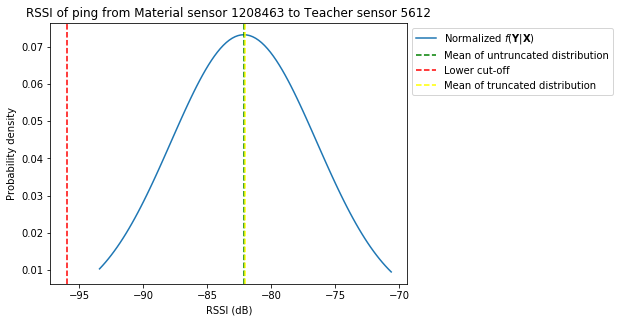

In [71]:
mean_rssi_values = sensor_model.rssi_truncated_mean(distances_test_x_continuous_value)
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    test_y_discrete_value = np.repeat(0, variable_structure.num_y_discrete_vars)
    test_y_continuous_value = np.copy(mean_rssi_values)
    log_probability_density_range = np.zeros(100, dtype='float')
    rssi_range=np.linspace(
        mean_rssi_values[y_continuous_var_index] - 2*sensor_model.rssi_untruncated_std_dev,
        mean_rssi_values[y_continuous_var_index] + 2*sensor_model.rssi_untruncated_std_dev,
        100)
    for rssi_index in range(len(rssi_range)):
        test_y_continuous_value[y_continuous_var_index] = rssi_range[rssi_index]
        log_probability_density_range[rssi_index] = sensor_model.y_bar_x_log_pdf(
            test_x_discrete_value,
            test_x_continuous_value,
            test_y_discrete_value,
            test_y_continuous_value)
    log_probability_density_range = log_probability_density_range - (special.logsumexp(log_probability_density_range) + math.log(rssi_range[1]-rssi_range[0]))
    plt.plot(rssi_range, np.exp(log_probability_density_range), label='Normalized $f(\mathbf{Y} | \mathbf{X})$')
    plt.axvline(
        x=sensor_model.rssi_untruncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='green',
        label='Mean of untruncated distribution')
    plt.axvline(
        sensor_model.lower_rssi_cutoff,
        linestyle='dashed',
        color='red',
        label='Lower cut-off')
    plt.axvline(
        x=sensor_model.rssi_truncated_mean(distances_test_x_continuous_value[y_continuous_var_index]),
        linestyle='dashed',
        color='yellow',
        label='Mean of truncated distribution')
    plt.xlabel('RSSI (dB)')
    plt.ylabel('Probability density')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

## Explore and visualize model outputs

### Real data

Plot the maximum particle weight for each time step. Again, when this reaches 1.0, the particle filter has collapsed around a single $\mathbf{X}$ value.

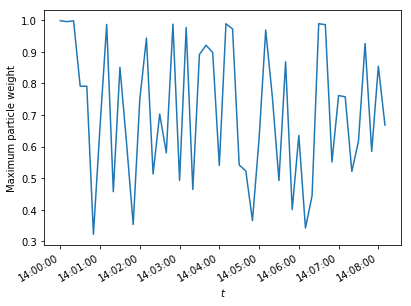

In [72]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[:num_timesteps_test], max_weights)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the number of sampled ancestor particles at each time step. Again, when this shrinks to 1, the particle filter has collapsed around a single $\mathbf{X}$ value.

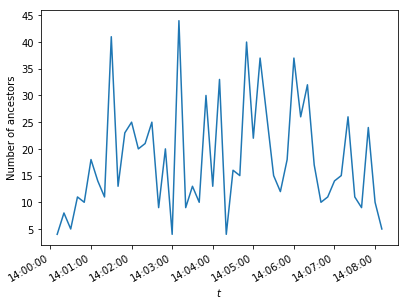

In [73]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_test[1:num_timesteps_test], num_ancestors)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of ancestors')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles. This represents our best guess at the positions of the moving sensors.

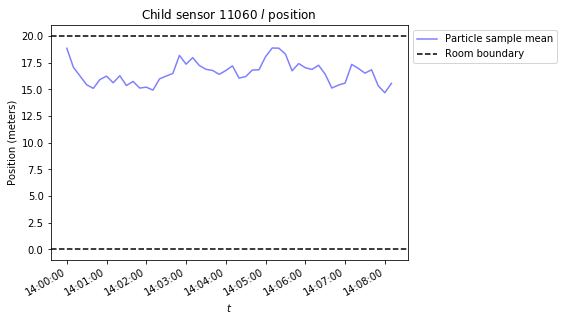

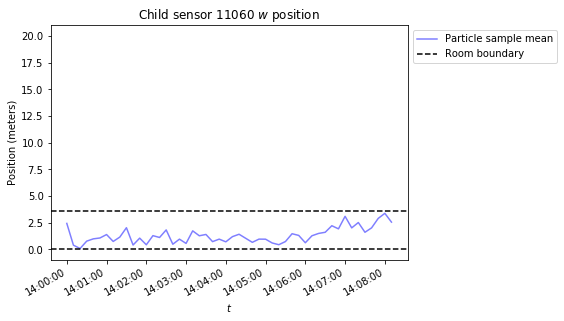

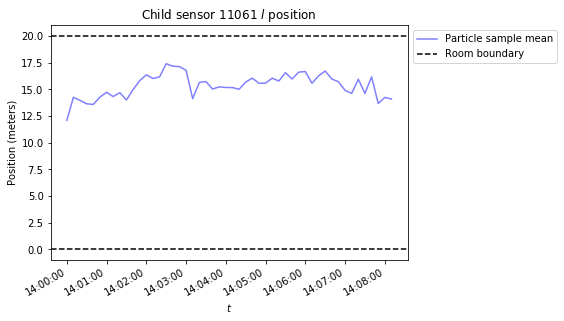

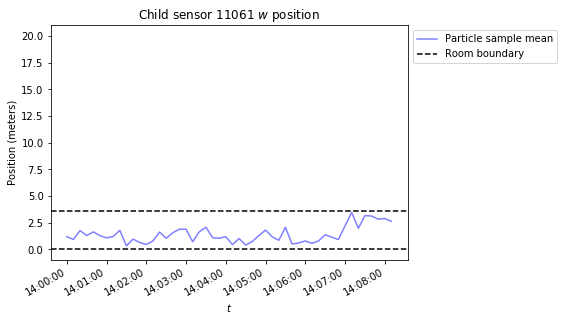

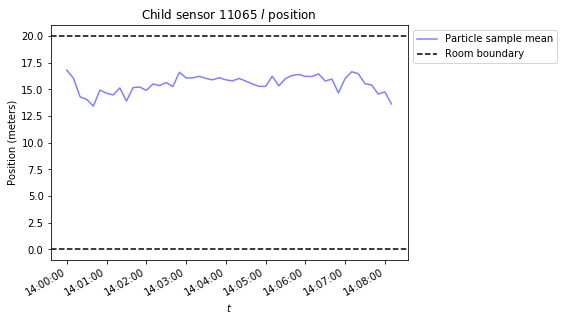

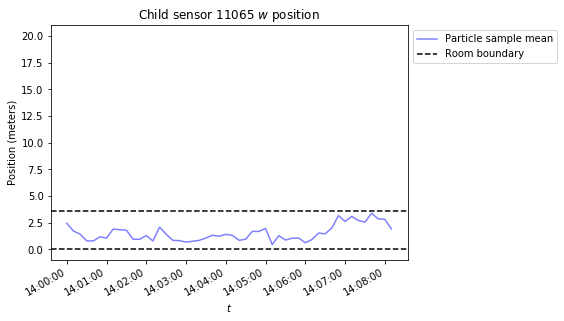

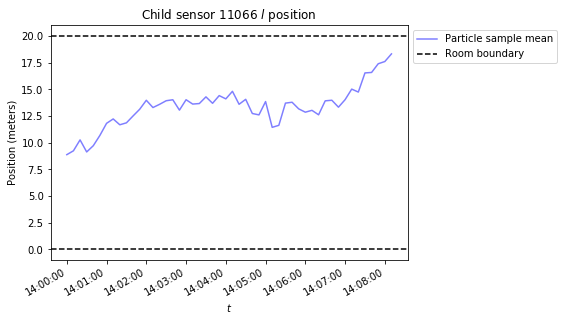

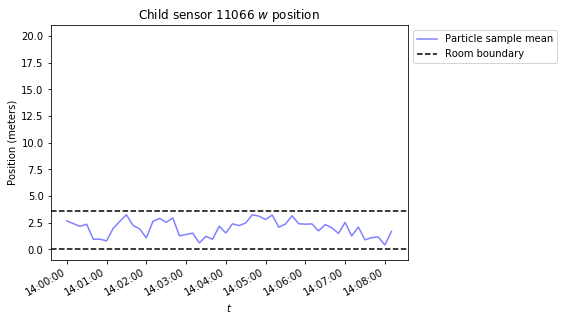

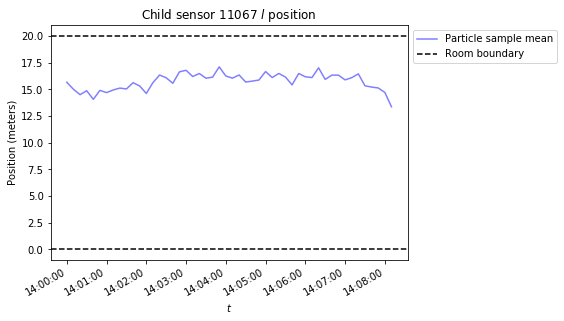

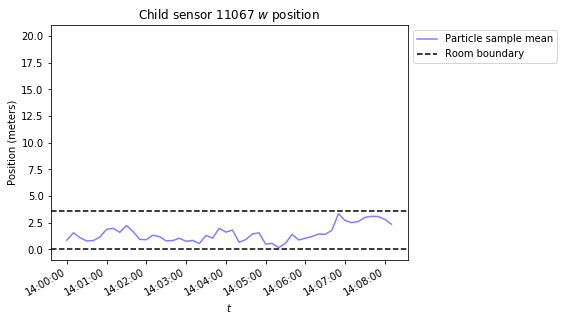

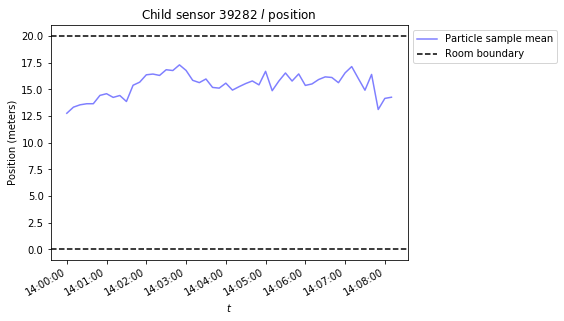

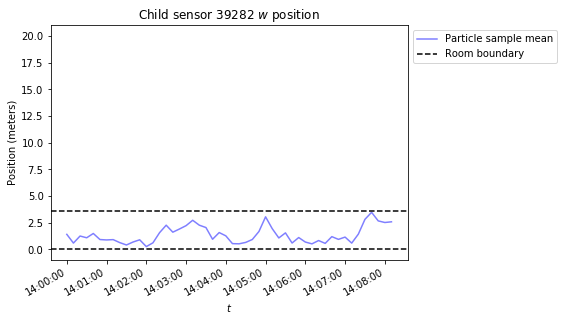

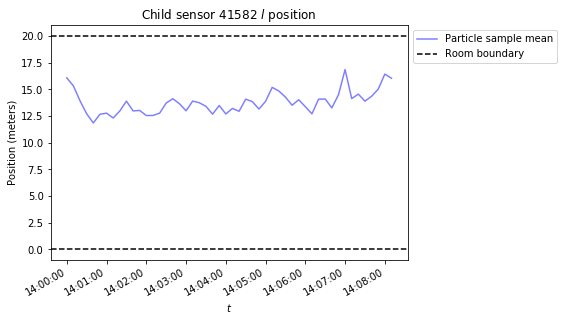

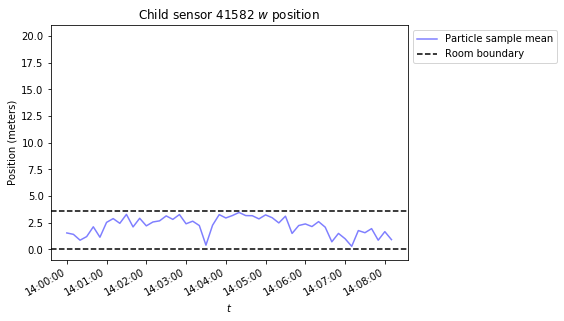

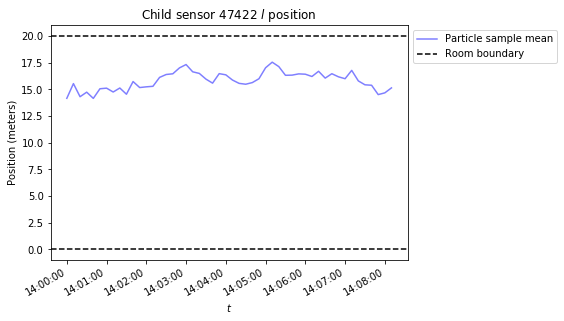

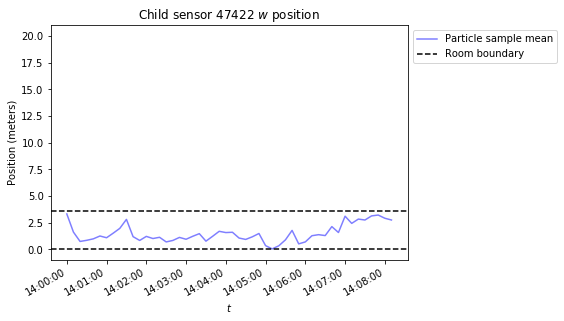

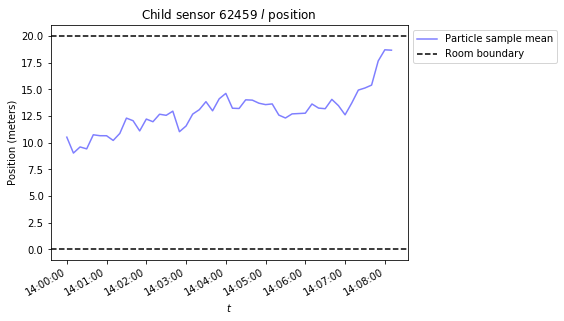

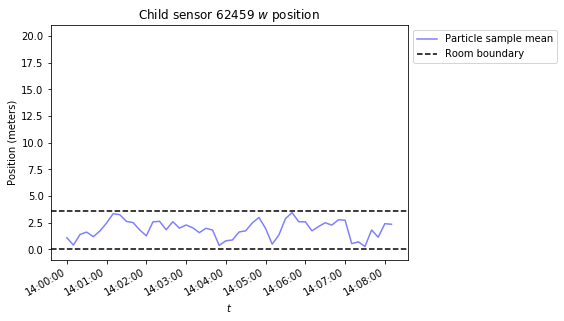

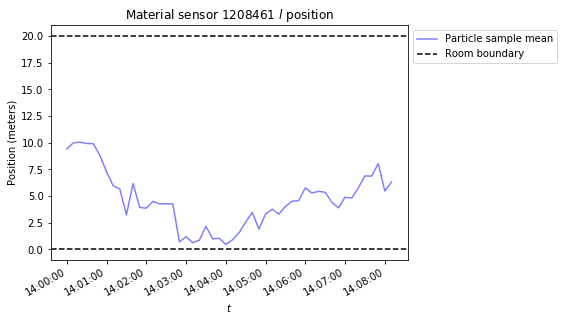

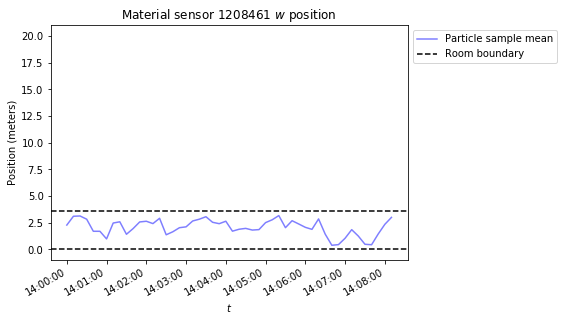

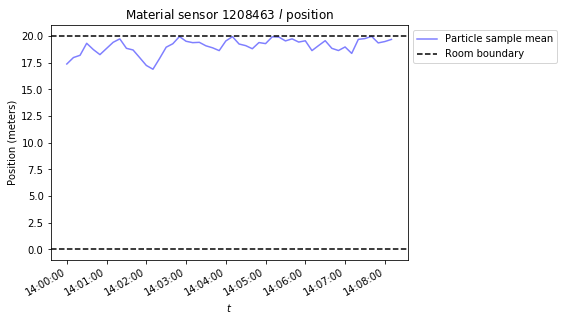

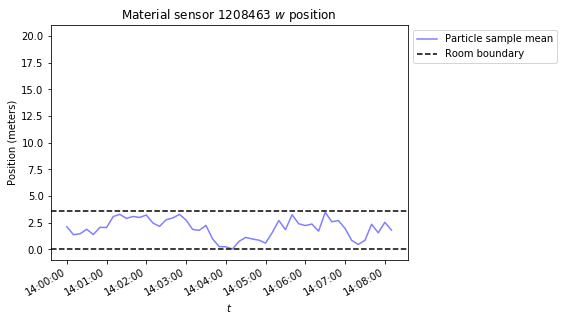

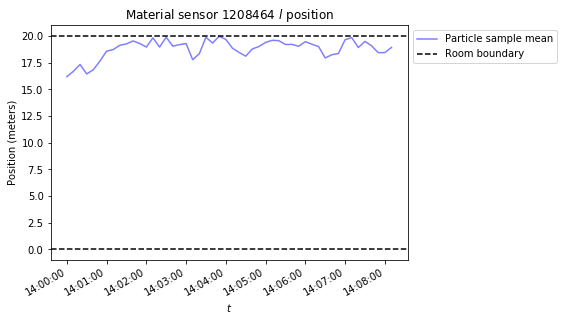

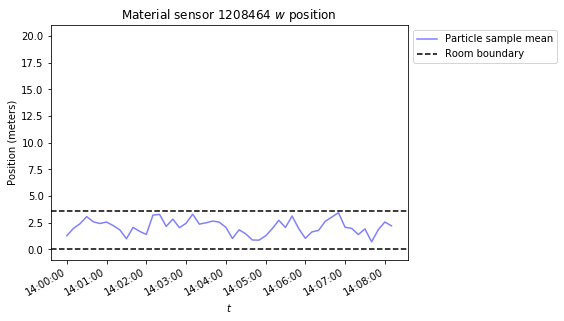

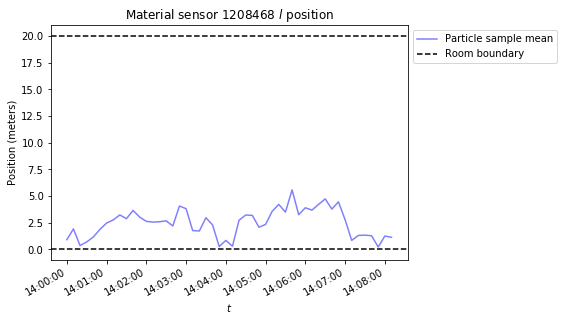

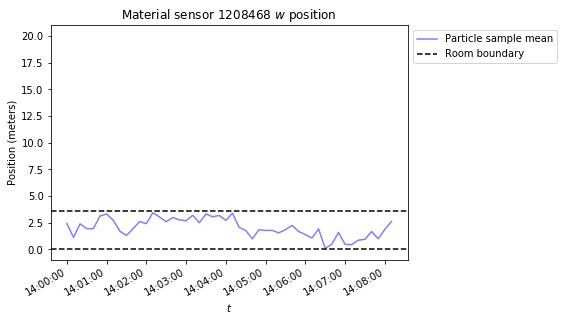

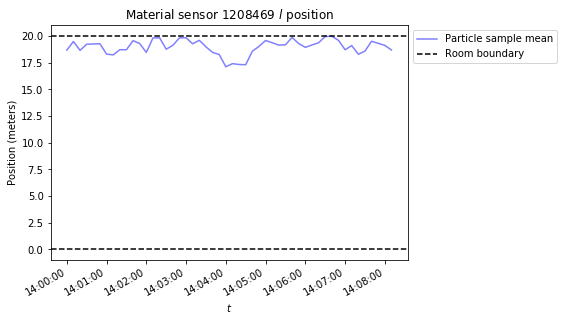

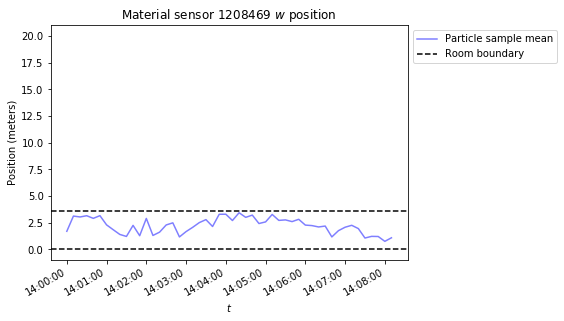

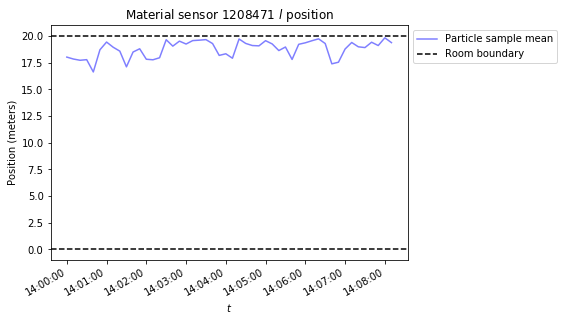

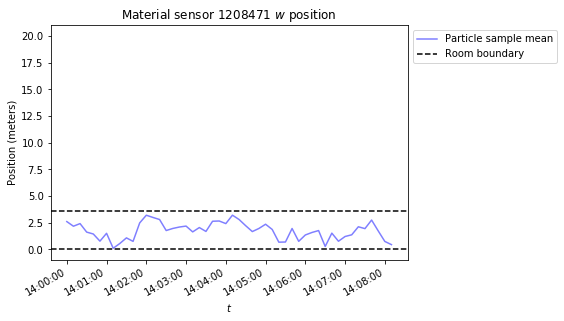

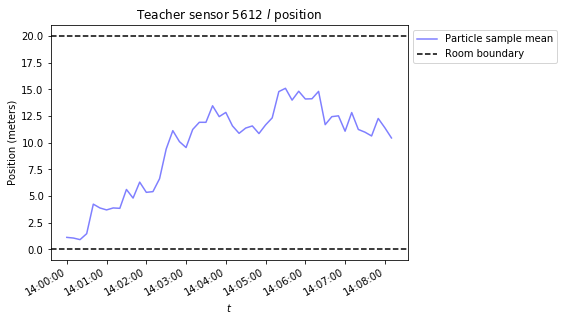

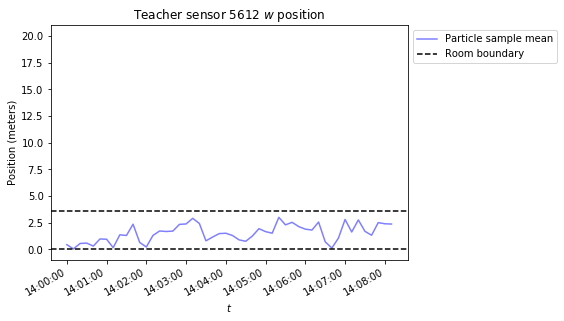

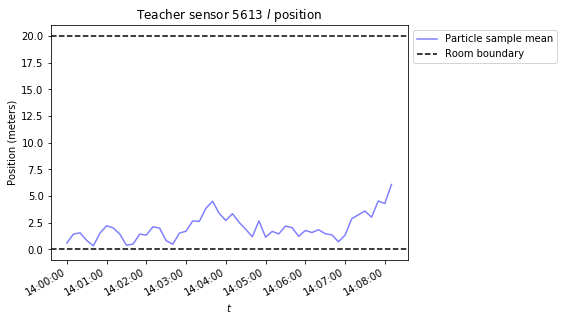

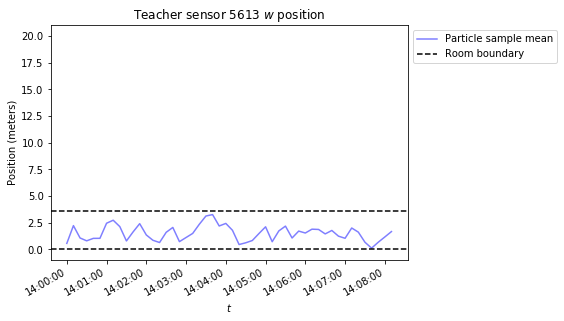

In [74]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(
        t_test[:num_timesteps_test],
        x_continuous_mean_particle[:,x_var_index],
        'b-',
        alpha=0.5,
        label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations).

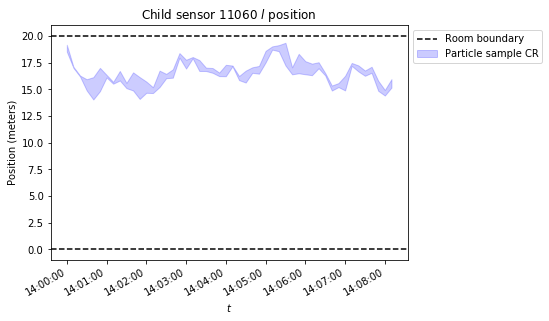

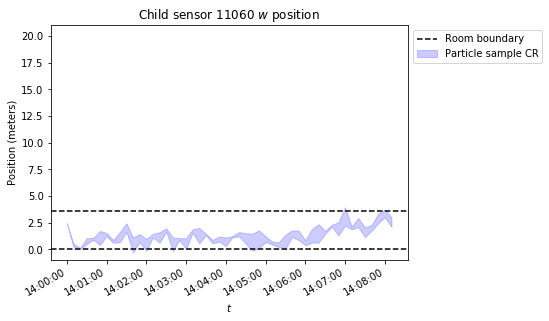

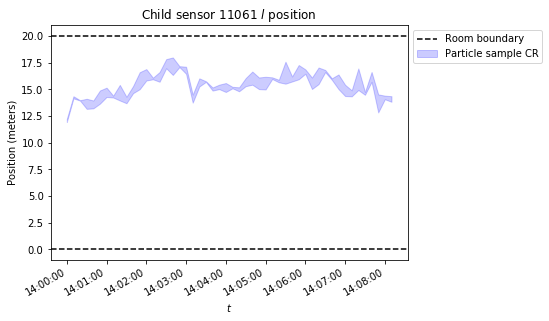

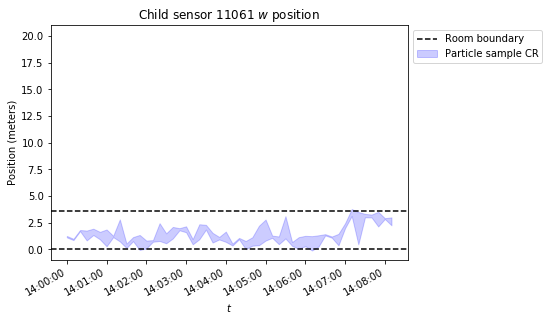

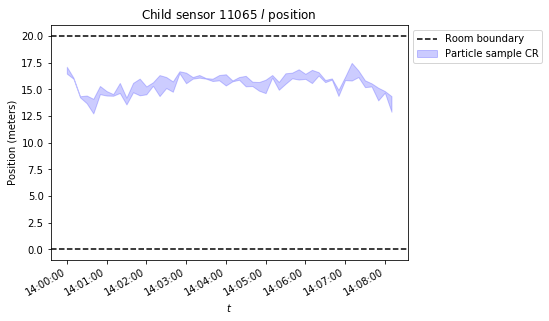

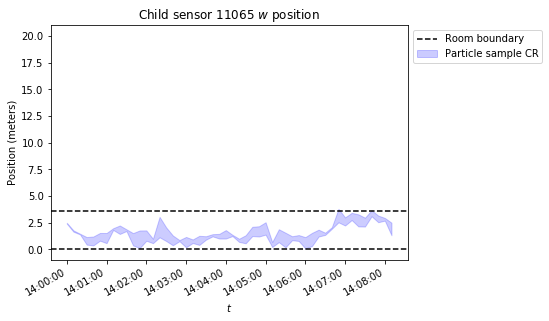

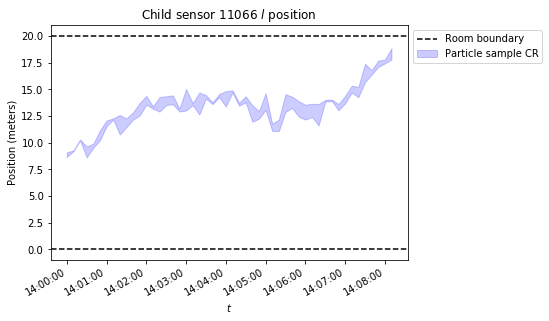

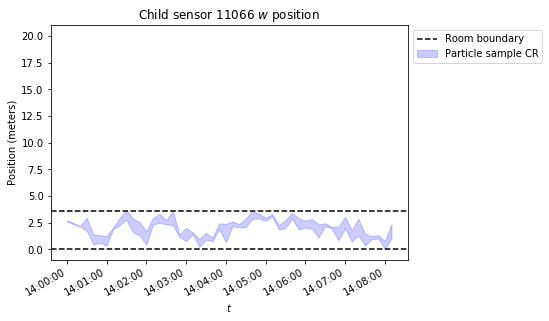

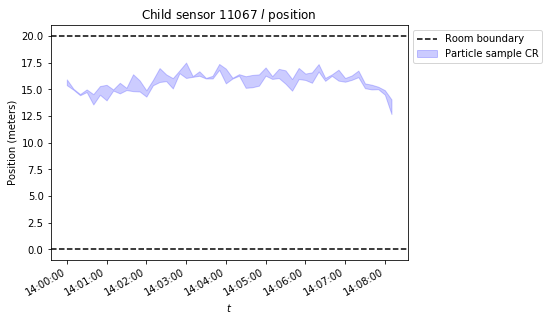

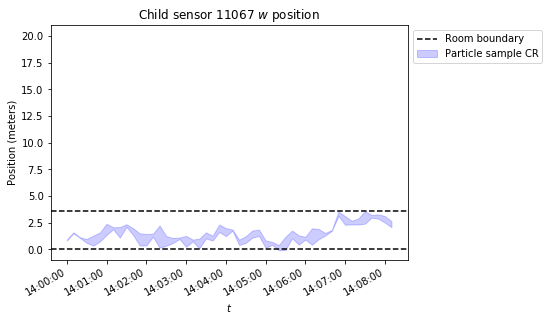

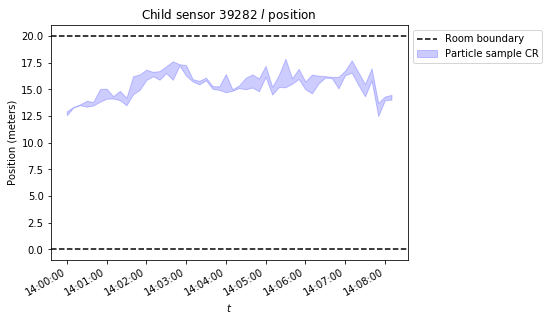

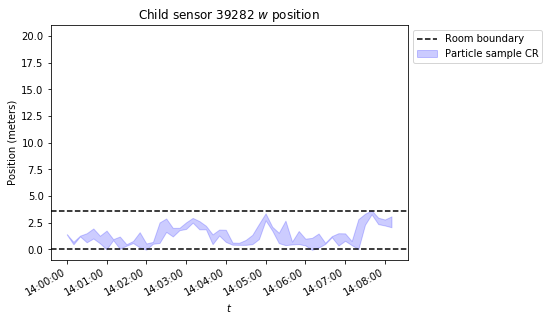

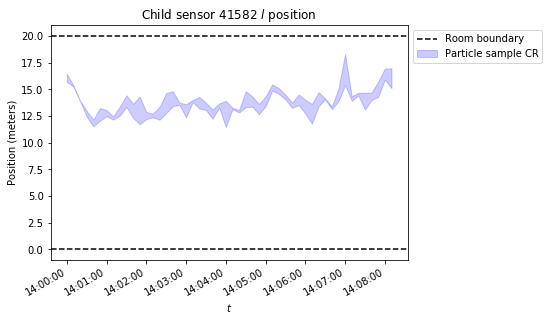

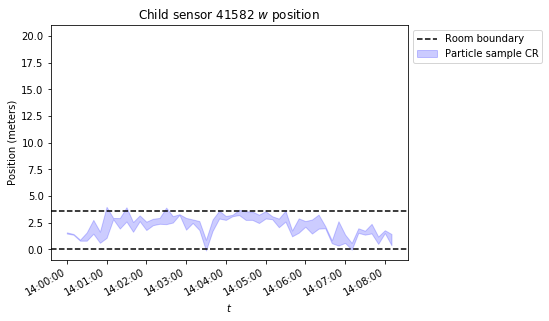

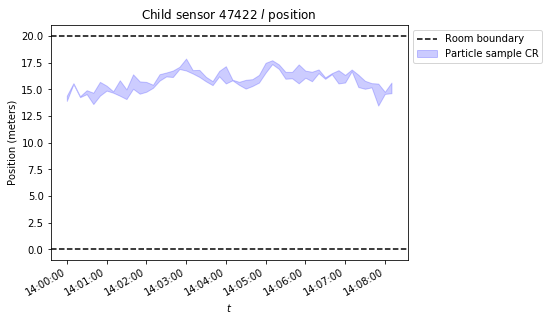

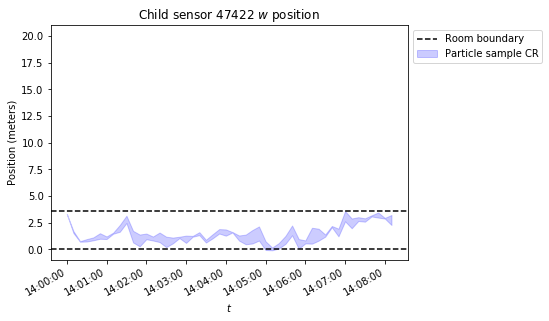

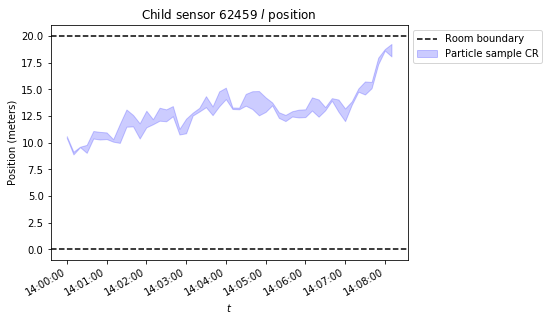

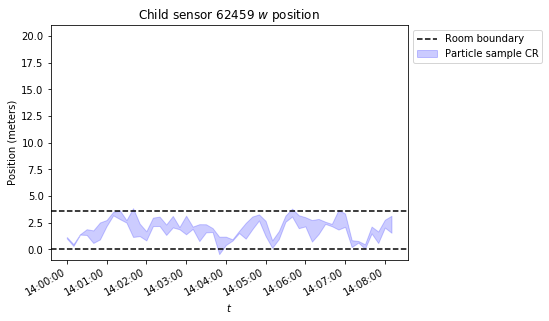

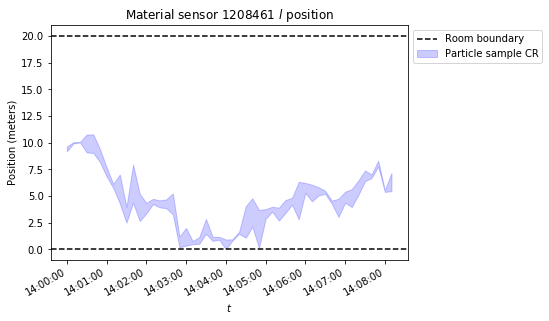

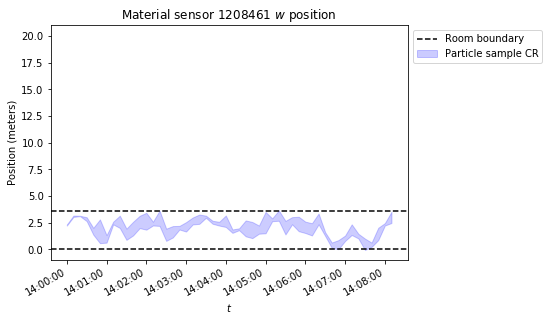

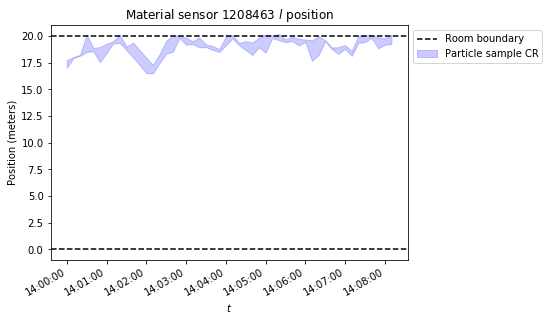

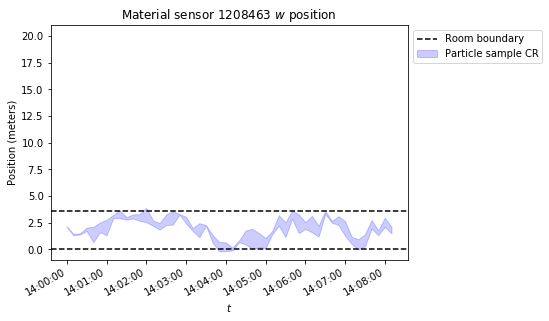

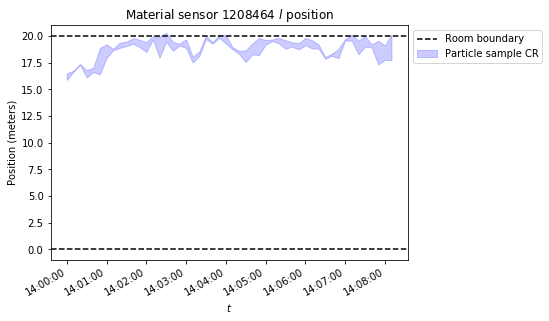

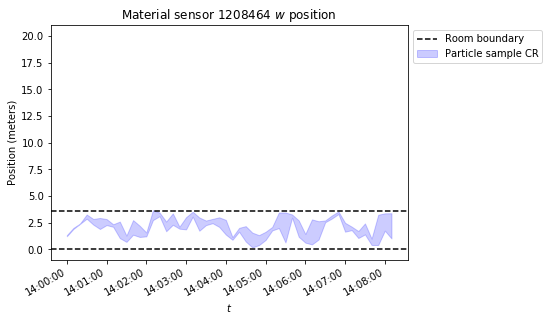

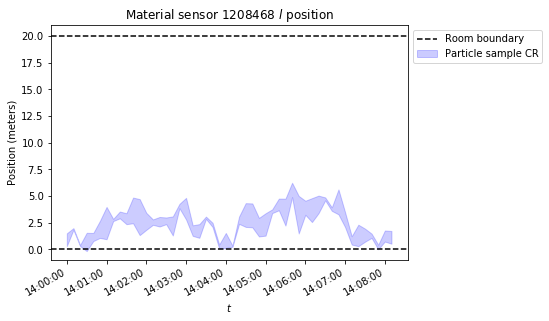

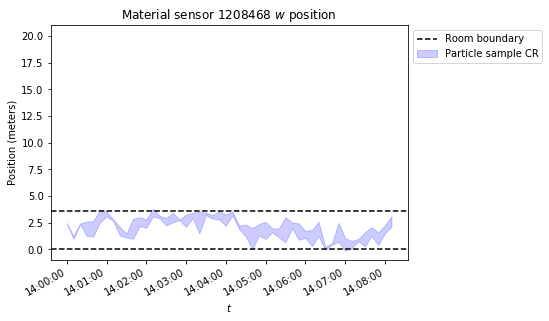

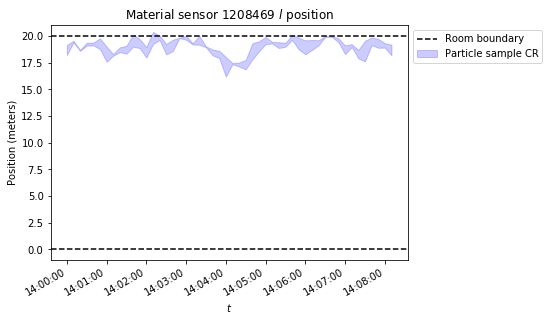

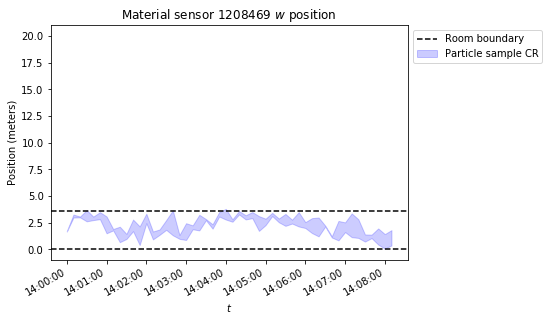

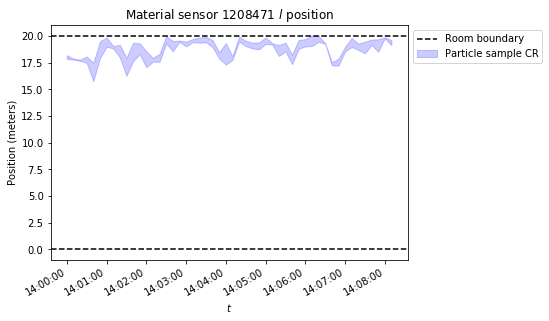

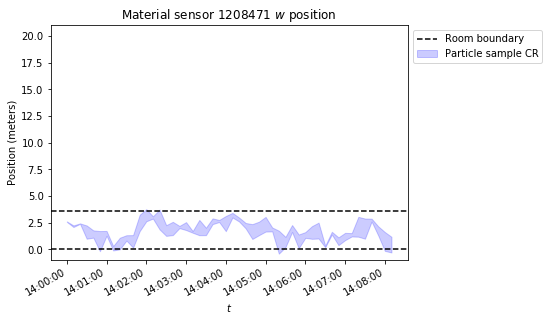

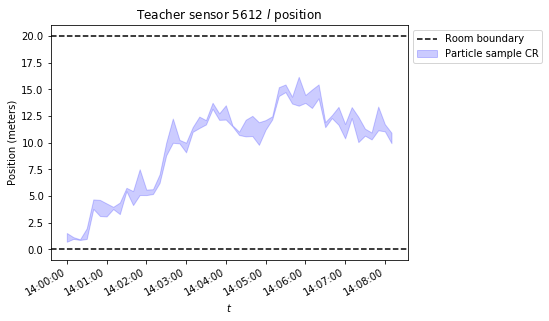

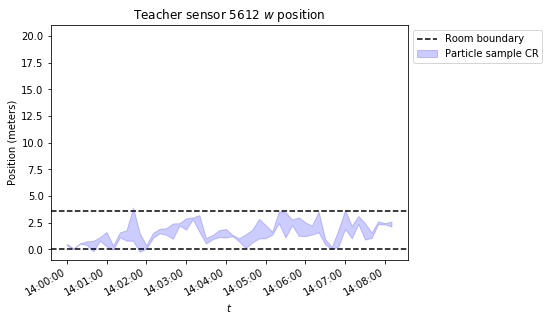

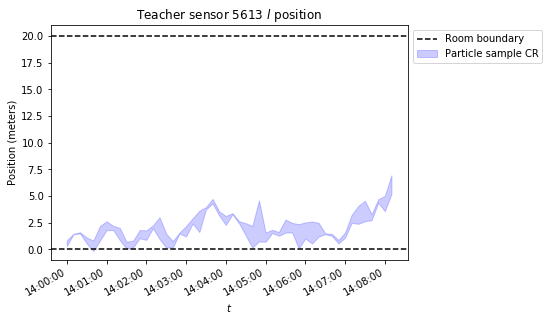

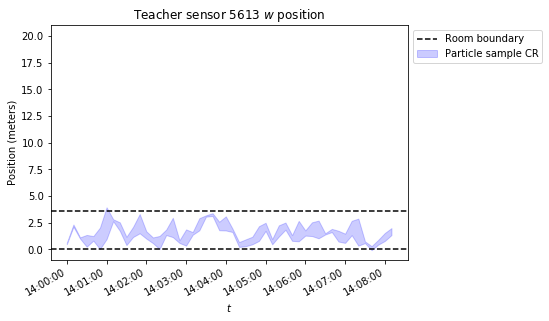

In [75]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.fill_between(
        t_test[:num_timesteps_test],
        x_continuous_mean_particle[:,x_var_index] - x_continuous_sd_particle[:, x_var_index],
        x_continuous_mean_particle[:,x_var_index] + x_continuous_sd_particle[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

### Simulation

Plot the (simulated) actual positions of the sensors to make sure they have the properties we expect.

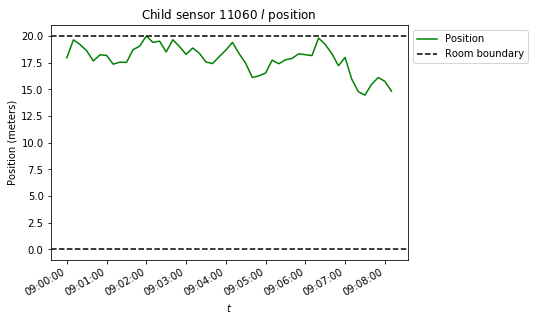

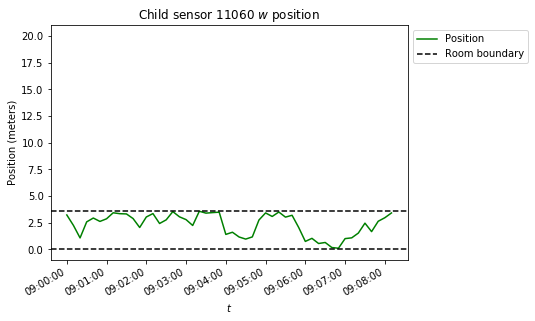

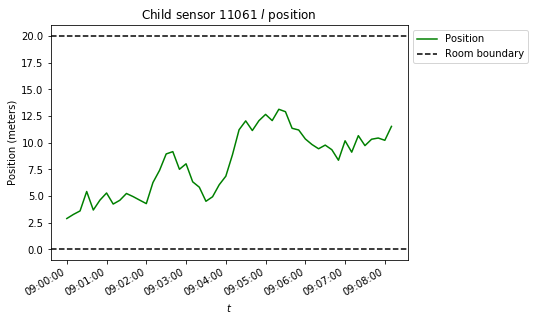

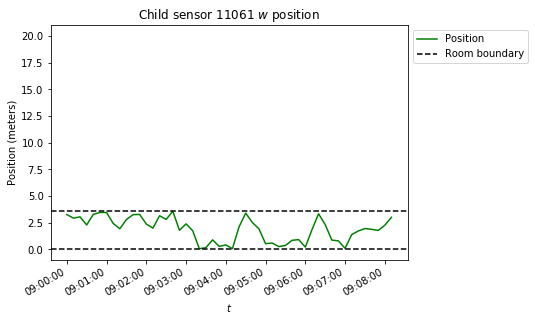

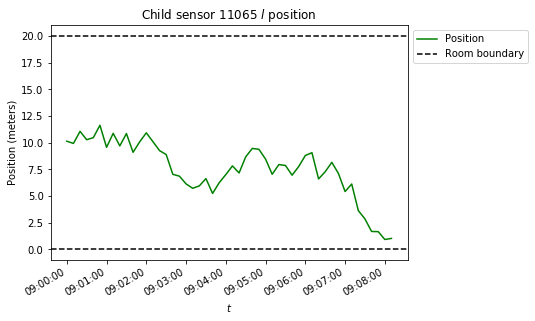

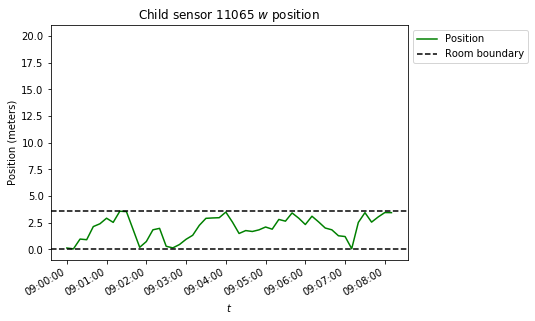

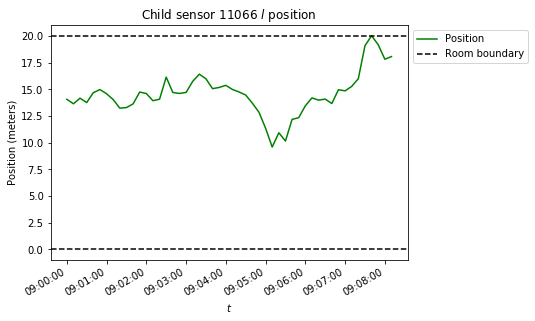

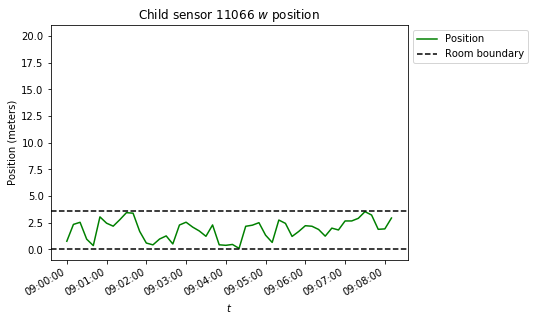

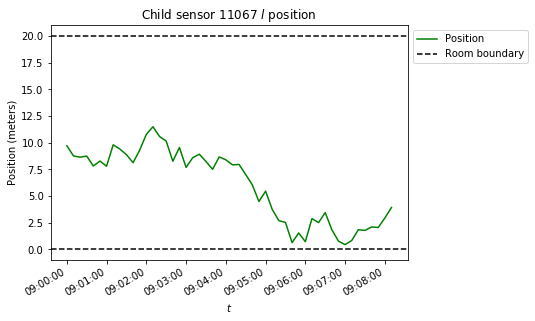

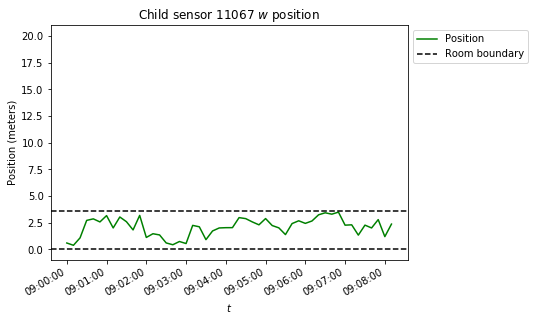

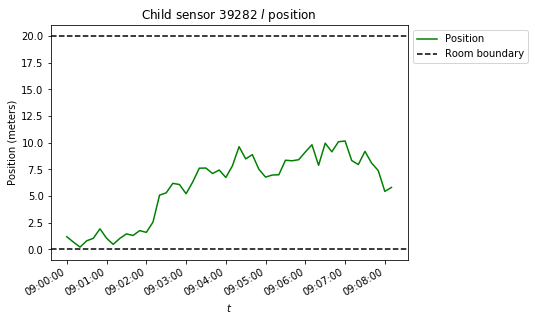

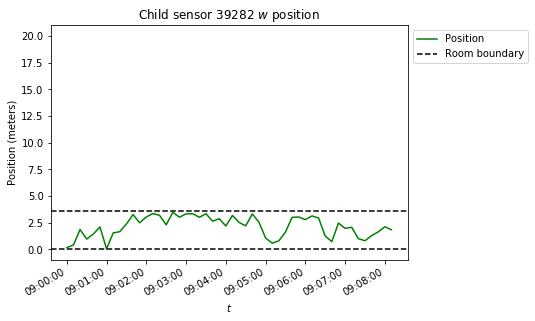

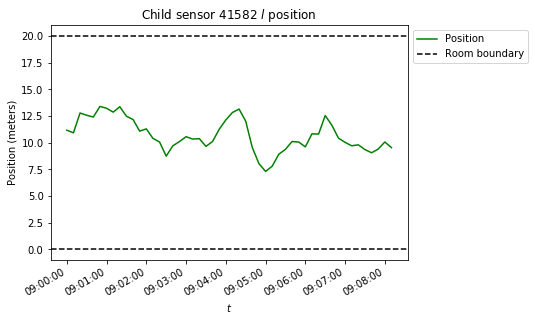

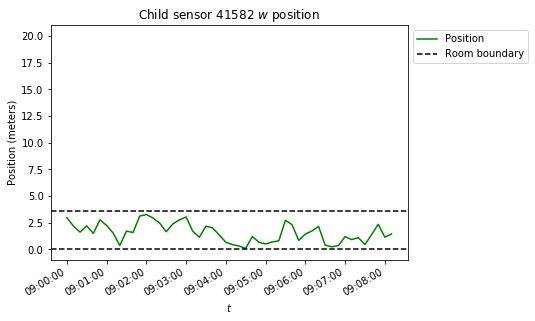

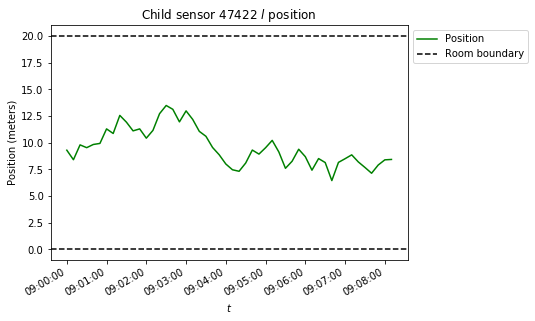

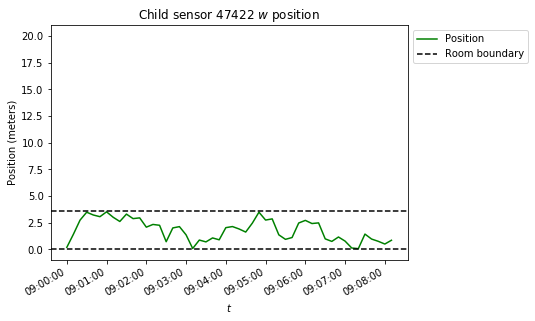

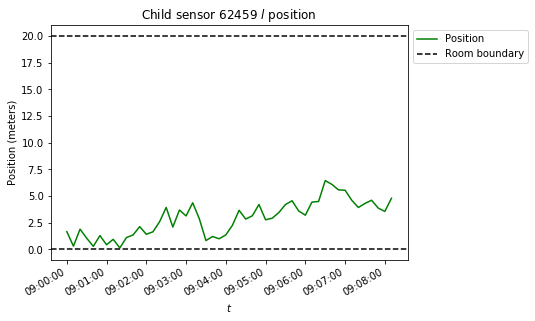

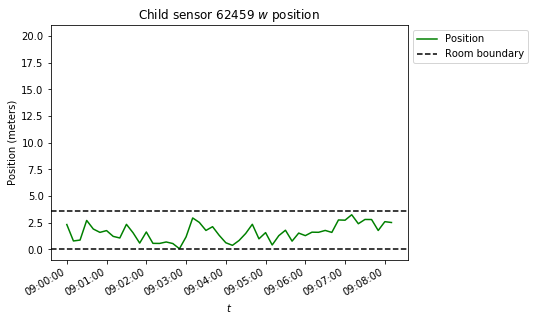

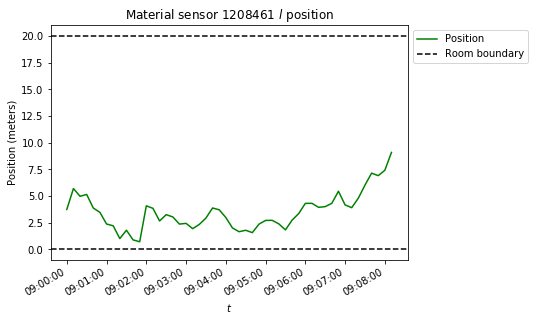

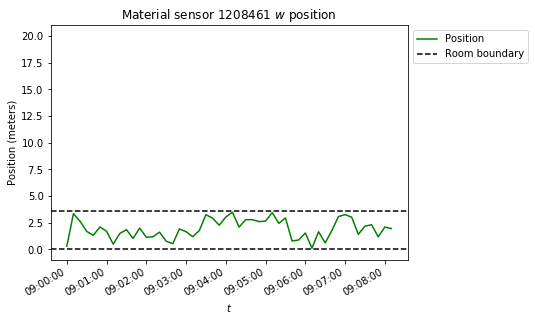

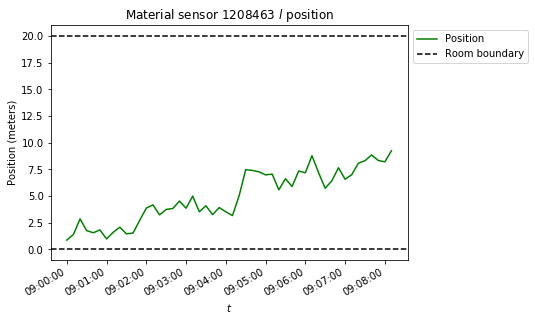

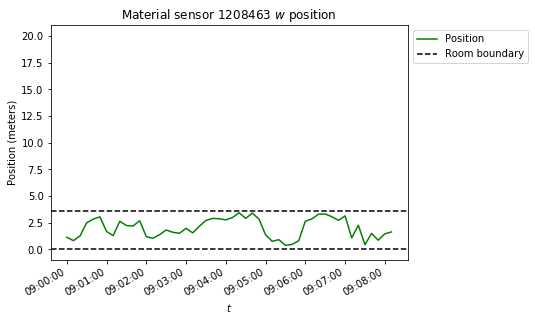

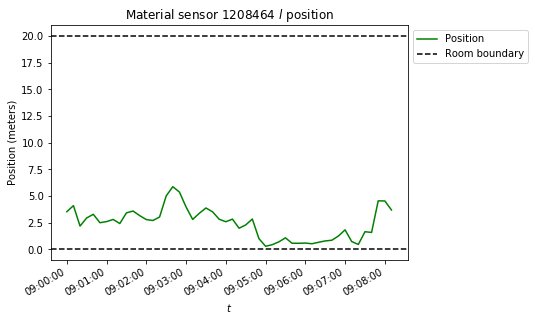

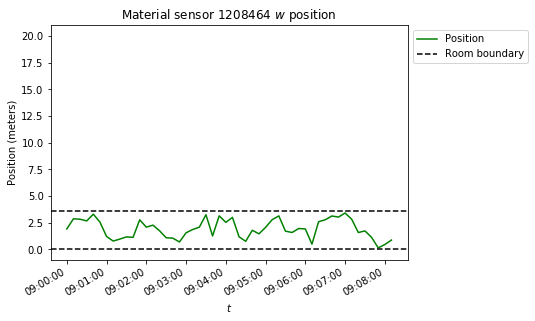

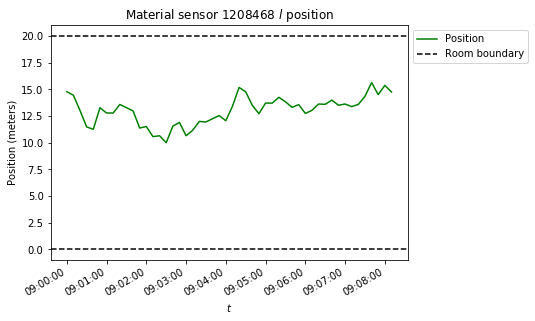

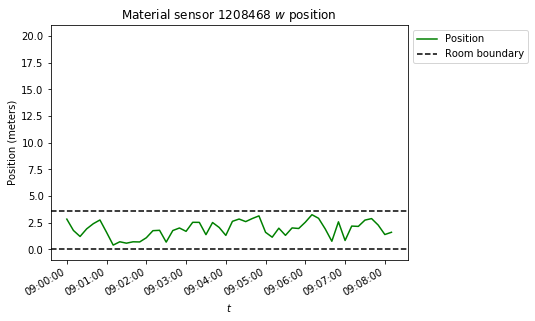

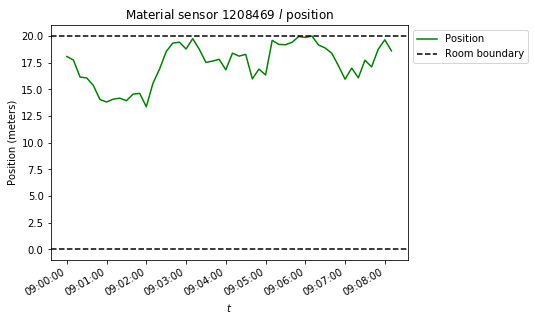

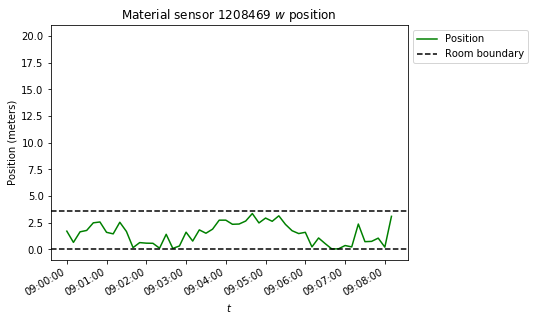

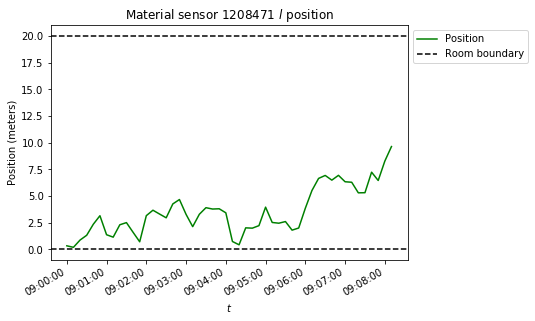

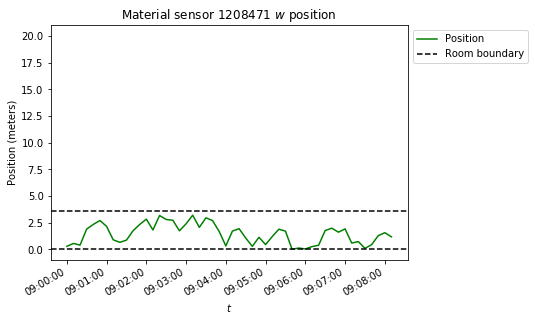

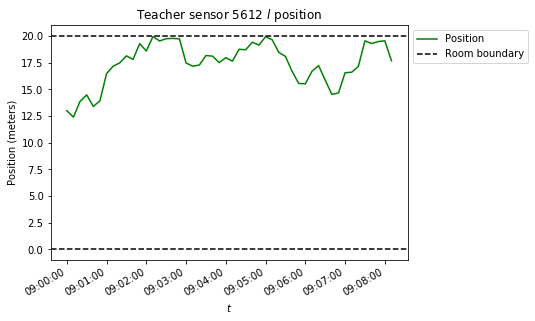

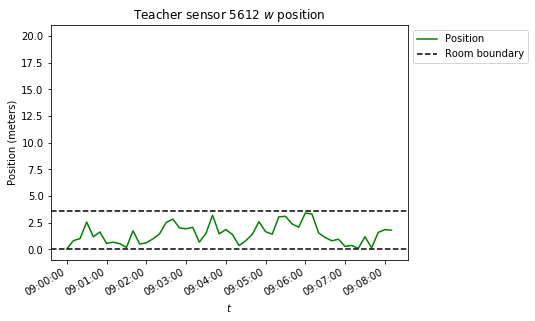

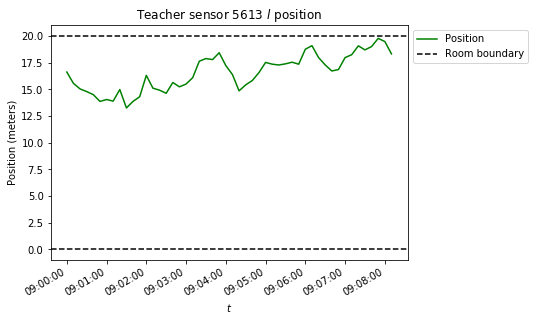

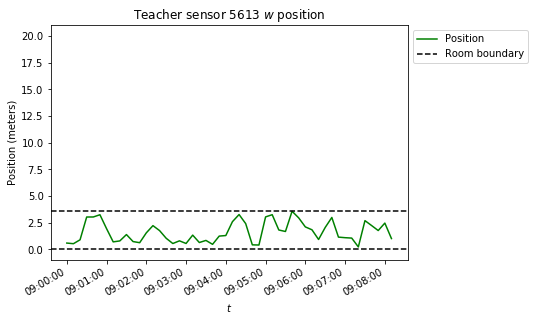

In [76]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:, x_var_index], 'g-', label='Position')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(
        0 - 0.05*np.max(room_size),
        np.max(room_size) + 0.05*np.max(room_size))
    plt.plot
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

For 10 randomly chosen pairs of sensors, plot the (simulated) measured ping statuses against the (simulated) distances between the sensors. We should see more missed pings for larger distances, but with a lot of noise.

In [77]:
distances_t_sim = sensor_model.distances(sensor_model.sensor_positions(x_continuous_t_sim))

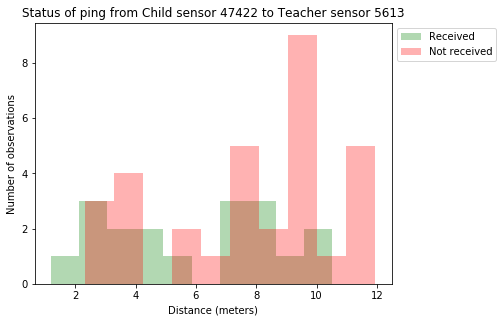

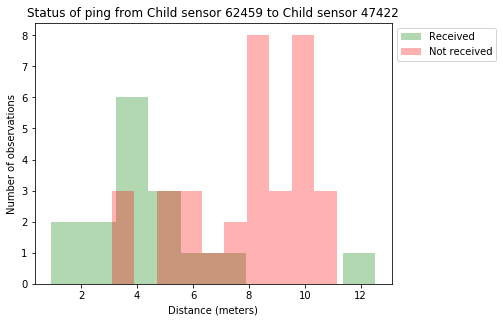

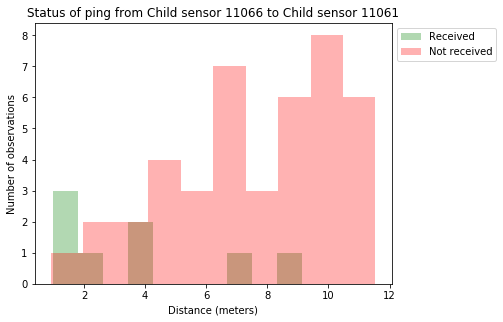

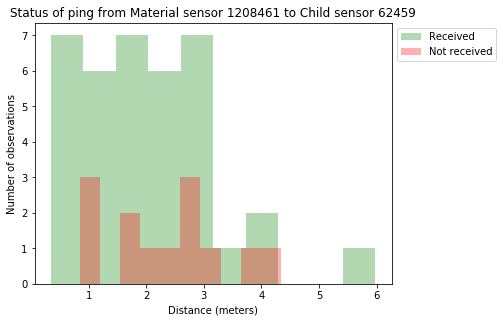

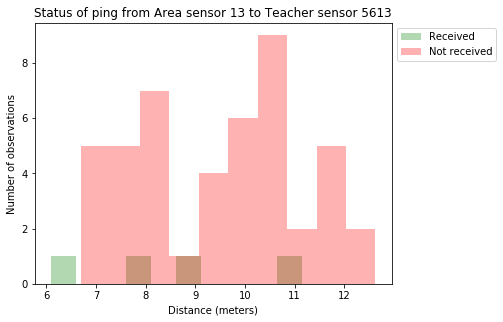

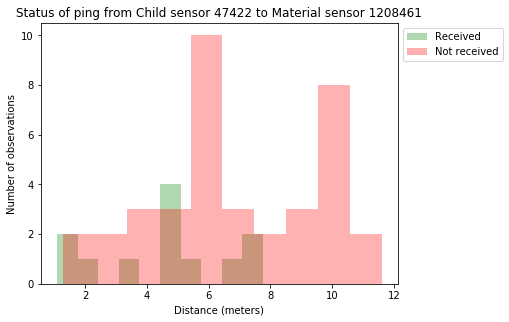

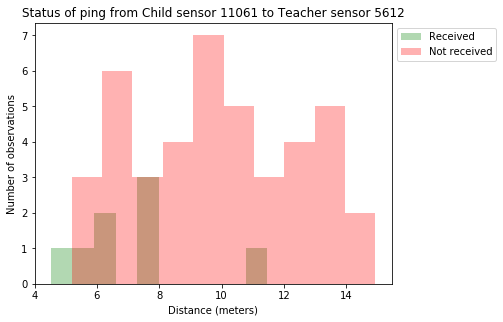

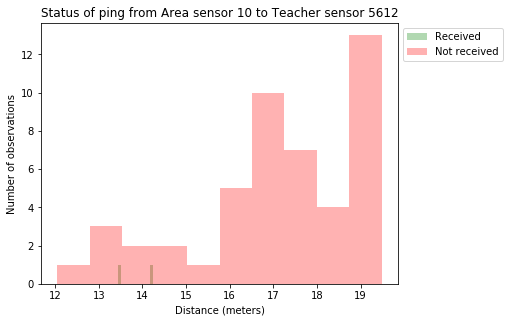

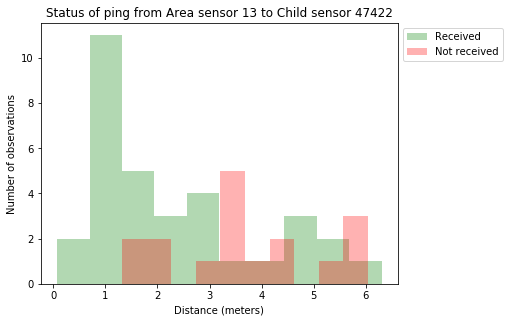

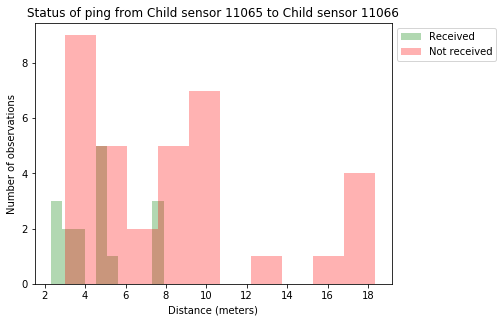

In [78]:
for y_discrete_var_index in np.random.choice(range(variable_structure.num_y_discrete_vars), size=10):
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 0, y_discrete_var_index],
        color='green',
        alpha=0.3,
        label=variable_structure.ping_status_names[0])
    plt.hist(
        distances_t_sim[y_discrete_t_sim[:,y_discrete_var_index] == 1, y_discrete_var_index],
        color='red',
        alpha=0.3,
        label=variable_structure.ping_status_names[1])
    plt.title(variable_structure.y_discrete_names[y_discrete_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Number of observations')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

For 10 randomly chosen pairs of sensors, plot the (simulated) measured RSSI of the received pings versus the (simulated) distances between the sensors. We should see a wide range of RSSI readings at each distance, but with a mean value that falls off with distance and a hard cut-off at -96 dB.

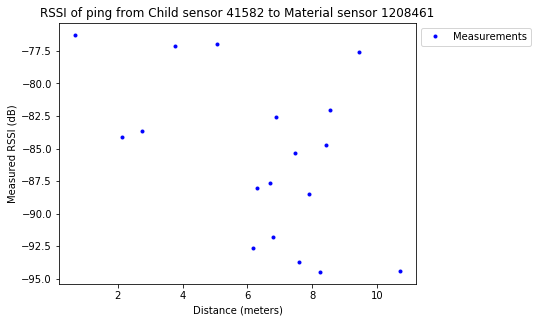

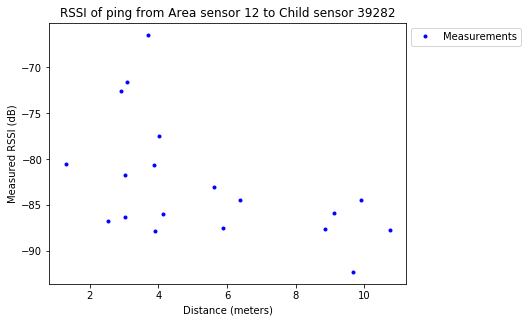

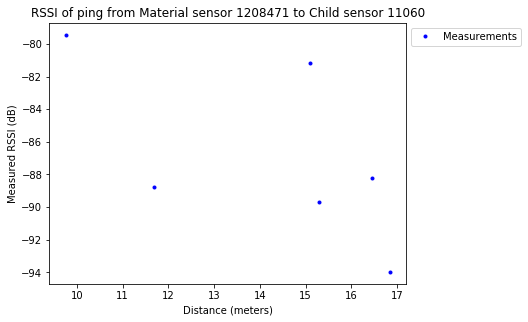

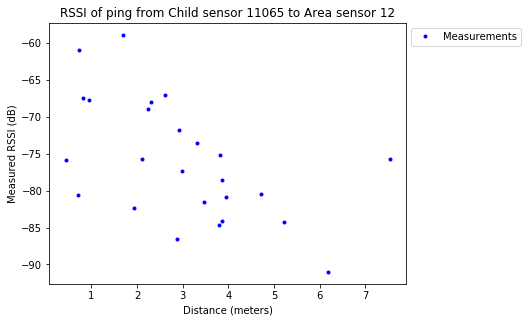

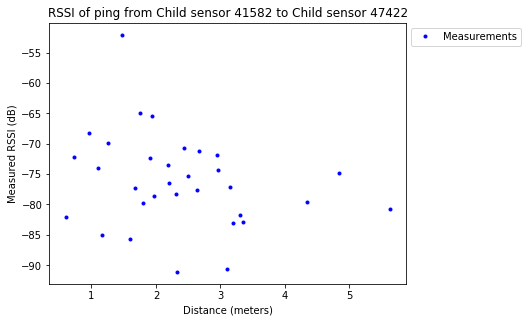

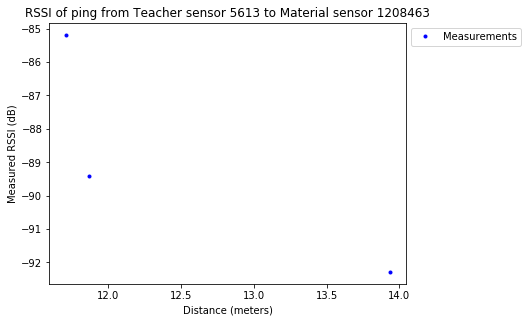

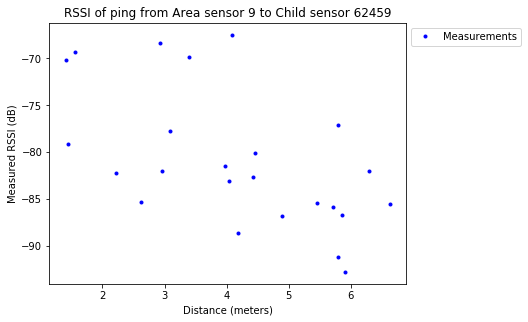

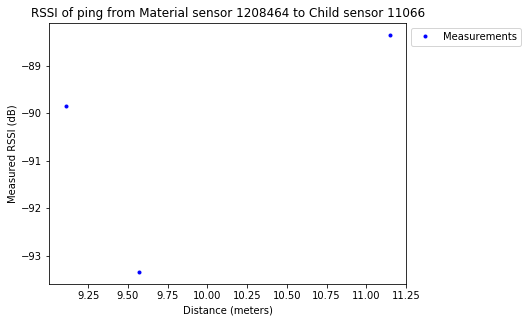

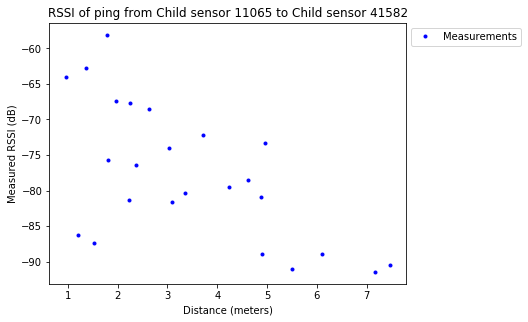

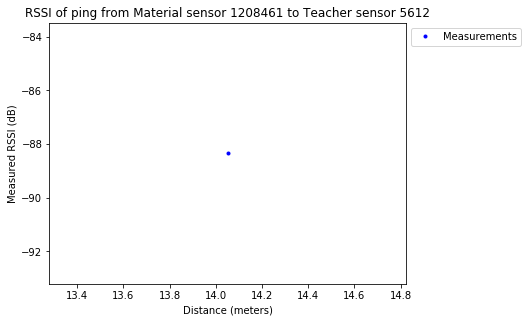

In [79]:
for y_continuous_var_index in np.random.choice(range(variable_structure.num_y_continuous_vars), size=10):
    plt.plot(
        distances_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        y_continuous_t_sim[y_discrete_t_sim[:,y_continuous_var_index] == 0, y_continuous_var_index],
        'b.',
        label='Measurements')
    plt.title(variable_structure.y_continuous_names[y_continuous_var_index])
    plt.xlabel('Distance (meters)')
    plt.ylabel('Measured RSSI (dB)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()

Plot the maximum particle weight for each time step. Again, when this reaches 1.0, the particle filter has collapsed around a single $\mathbf{X}$ value.

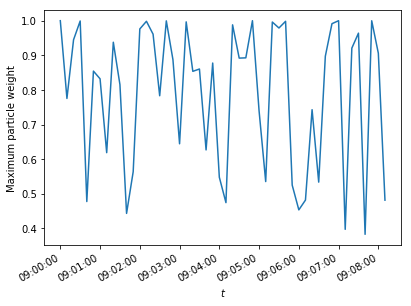

In [80]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim, max_weights_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Maximum particle weight')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the number of sampled ancestor particles at each time step. Again, when this shrinks to 1, the particle filter has collapsed around a single $\mathbf{X}$ value.

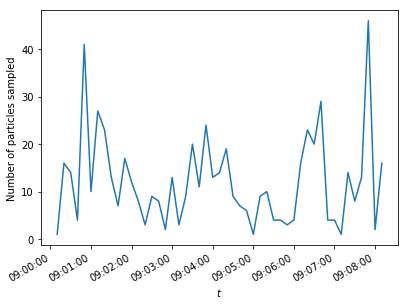

In [81]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
plt.plot(t_sim[1:], num_ancestors_sim)
plt.gcf().autofmt_xdate()
plt.xlabel('$t$')
plt.ylabel('Number of particles sampled')
plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample means of the particles against the (simulated) actual values of $\mathbf{X}_t$.

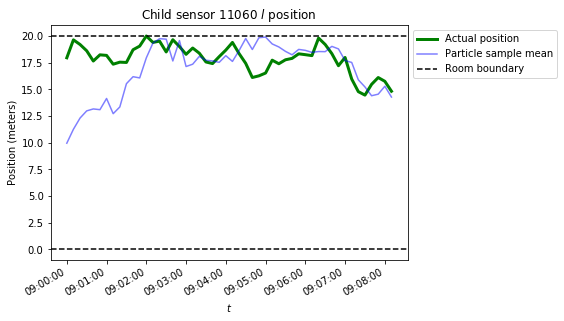

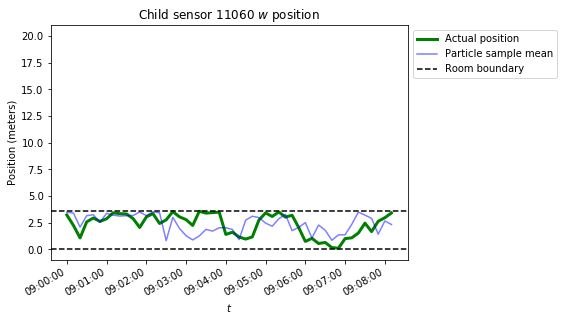

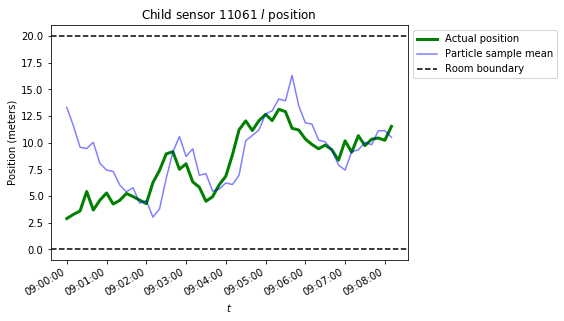

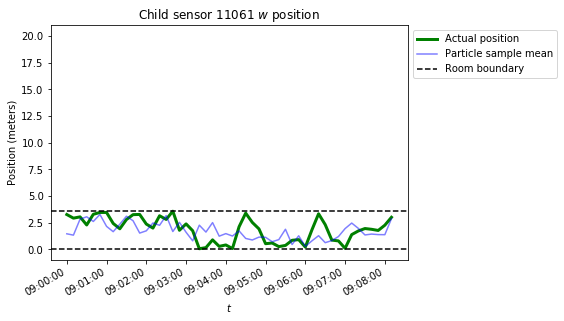

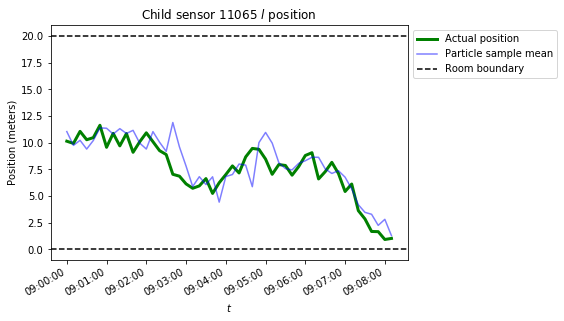

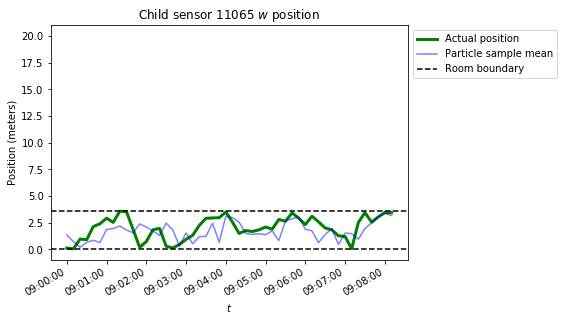

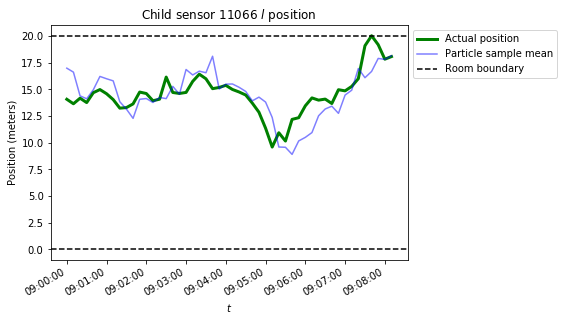

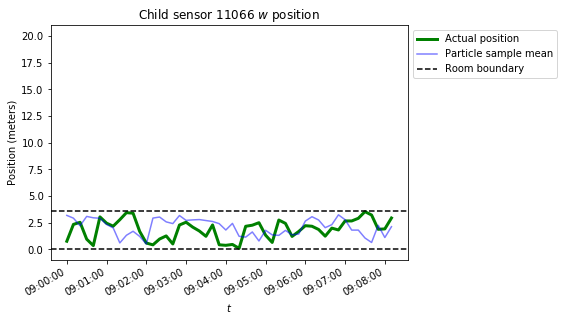

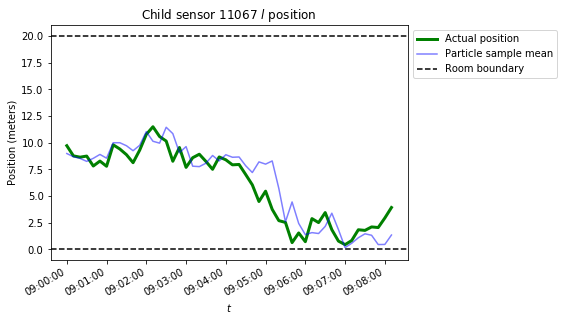

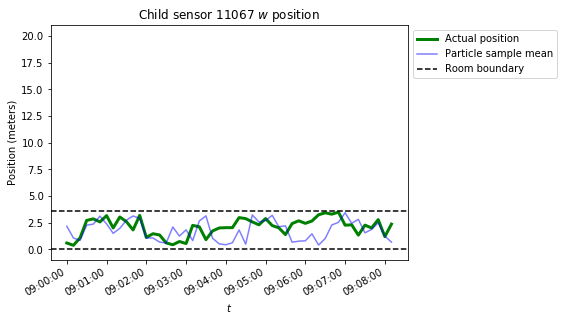

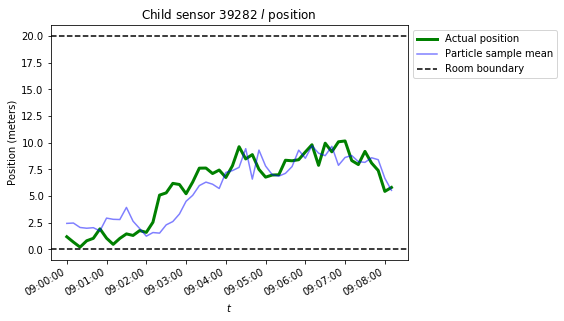

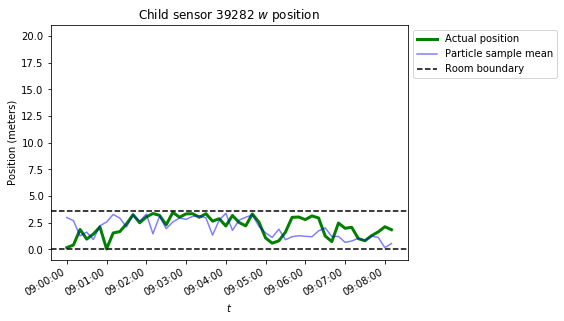

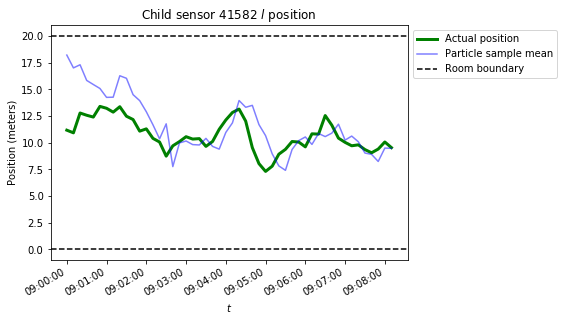

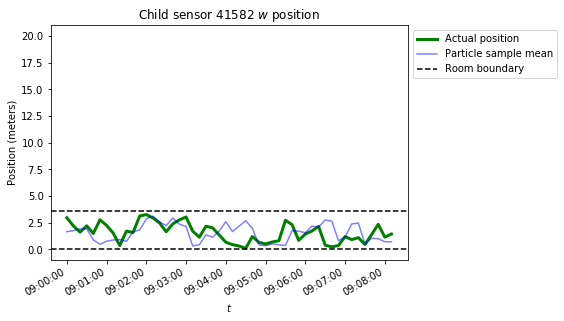

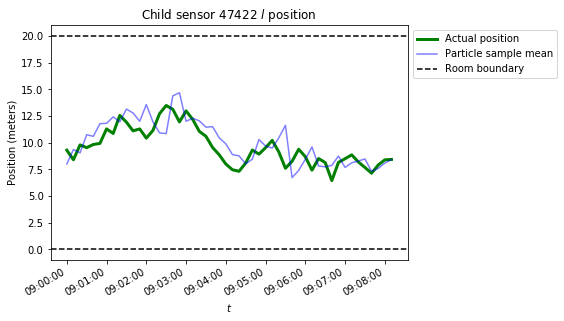

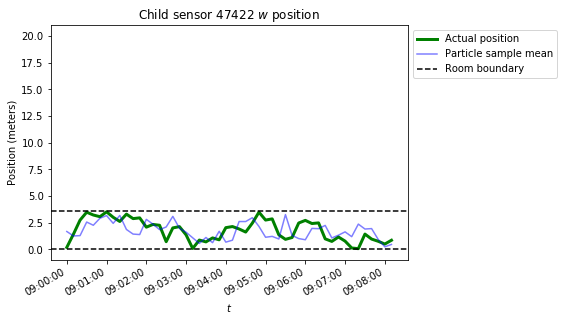

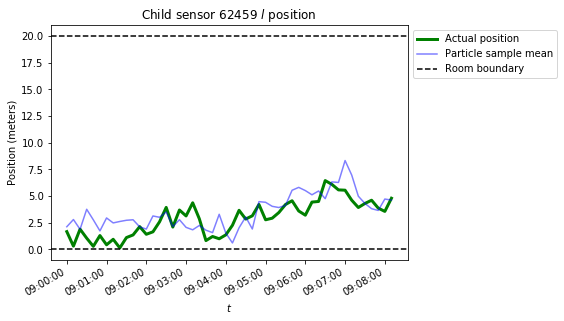

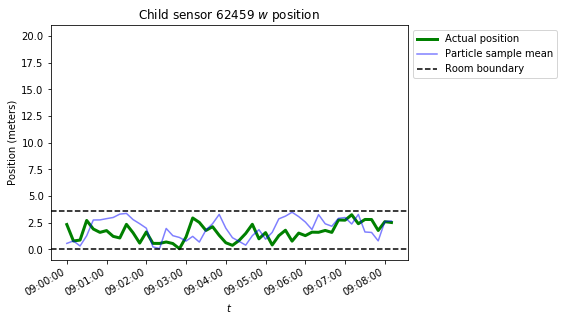

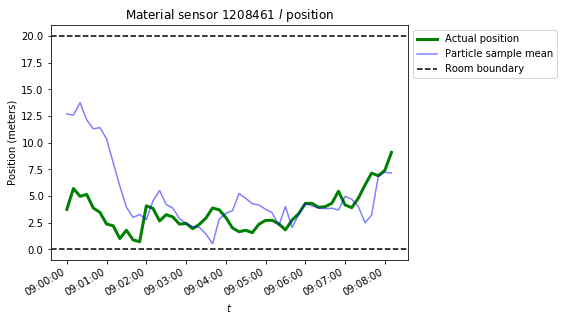

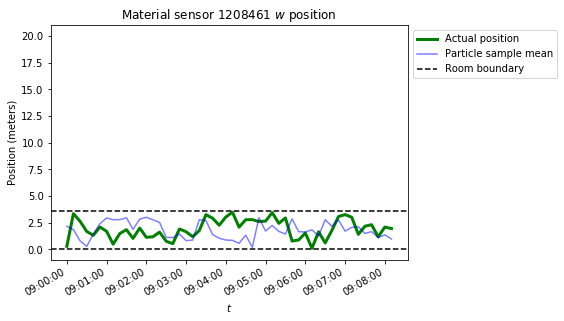

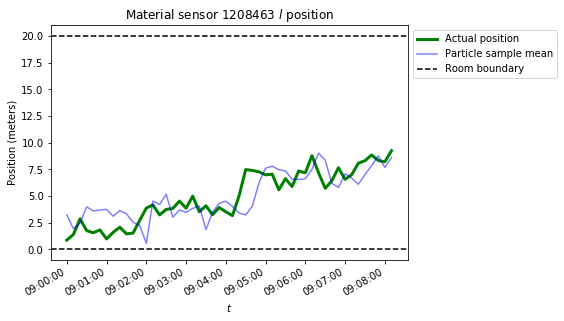

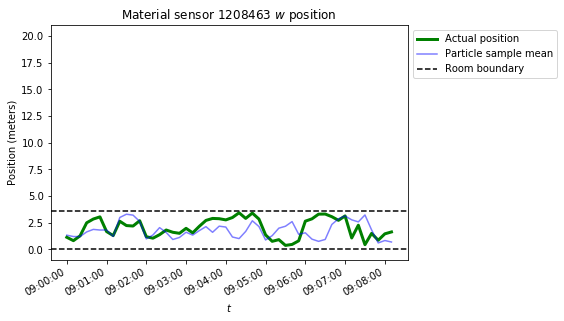

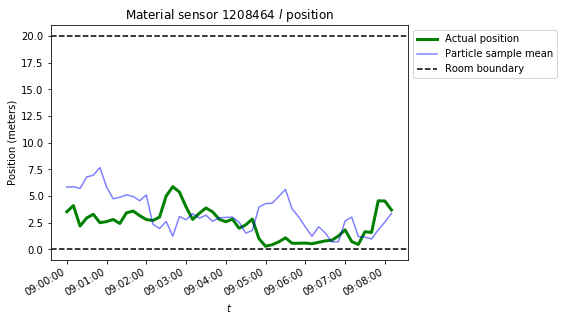

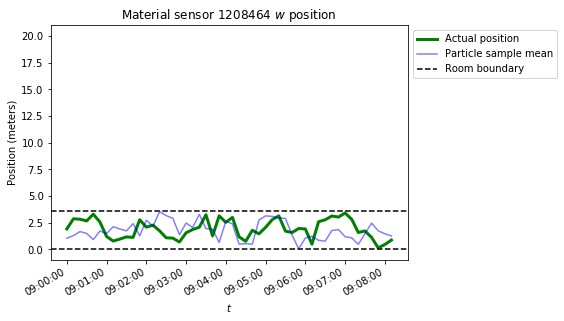

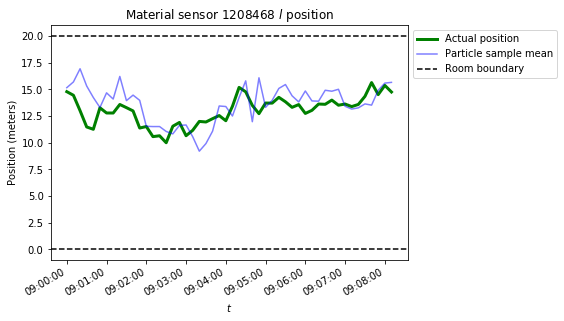

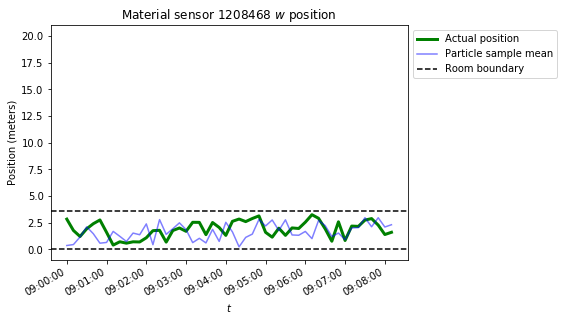

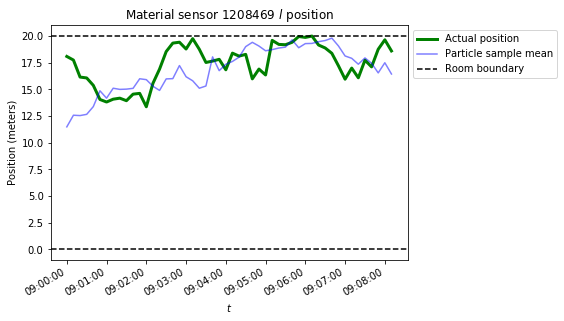

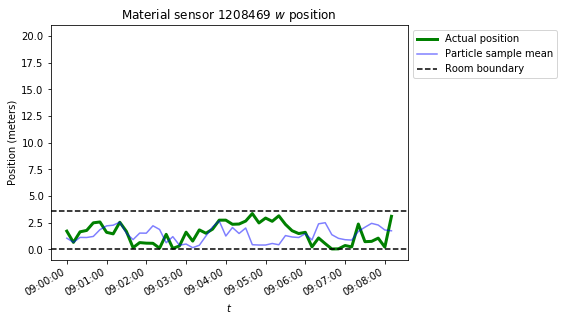

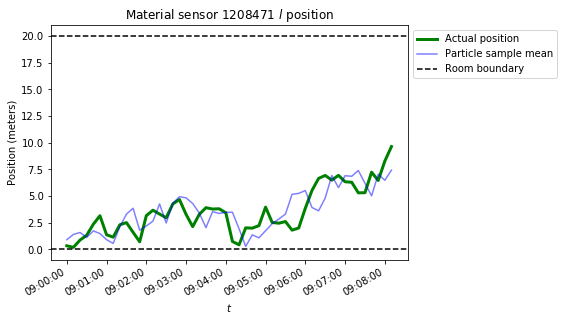

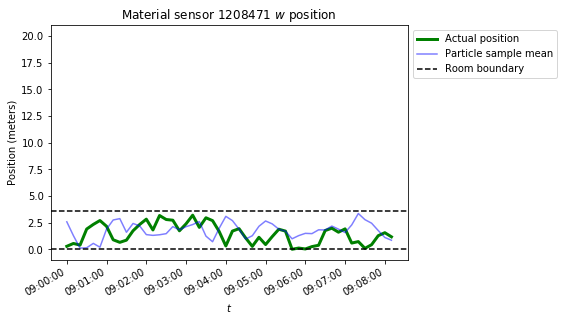

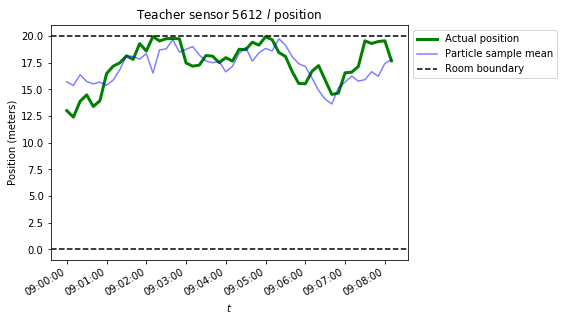

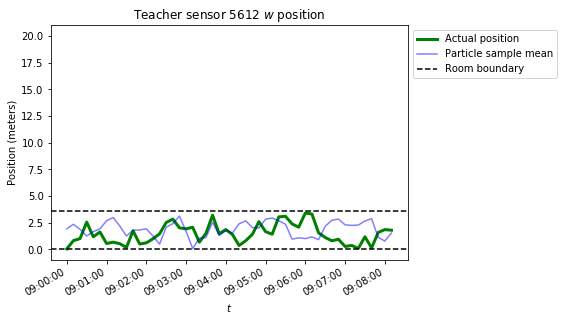

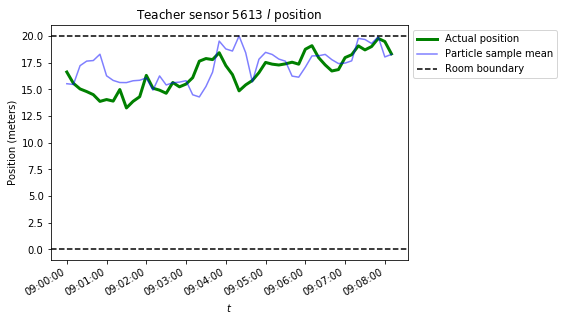

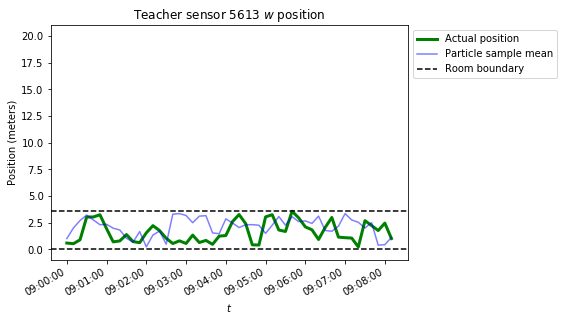

In [82]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.plot(t_sim, x_continuous_mean_particle_sim[:,x_var_index], 'b-', alpha=0.5, label='Particle sample mean')
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]

Plot the sample confidence regions of the particles (i.e., sample means plus/minus sample standard deviations) against the (simulated) actual values of $\mathbf{X}_t$.

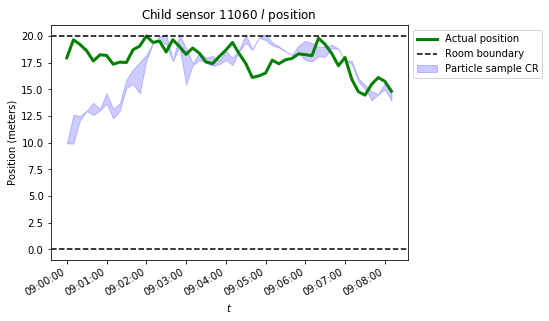

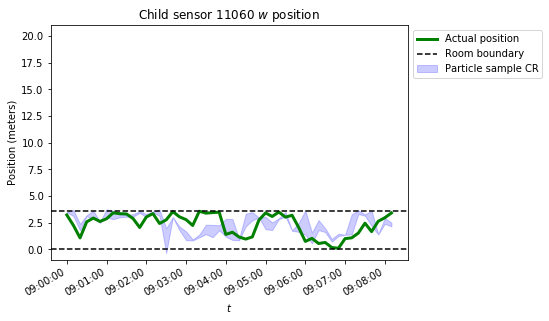

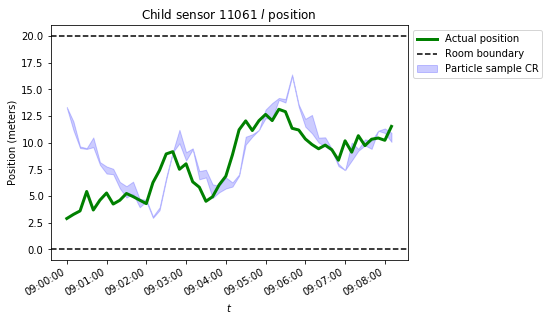

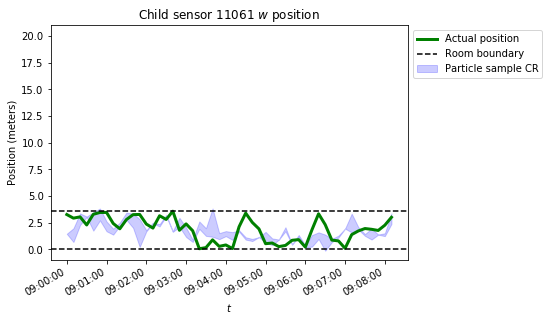

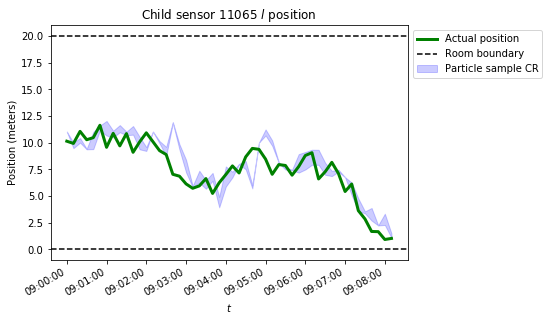

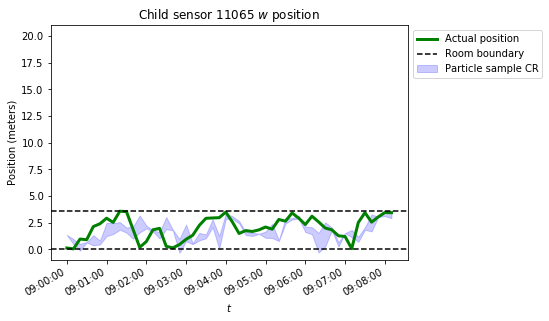

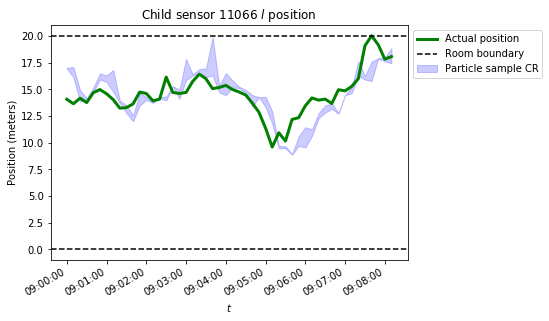

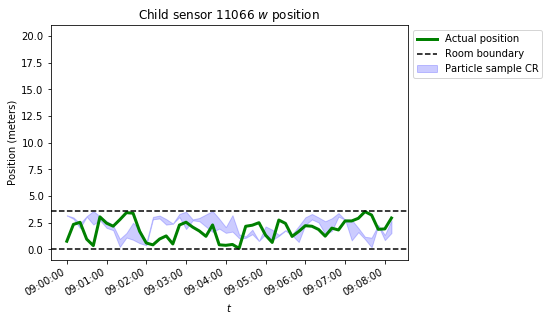

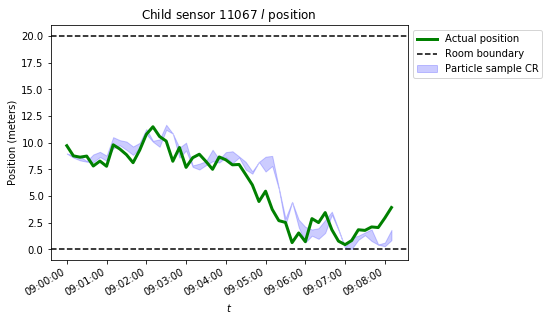

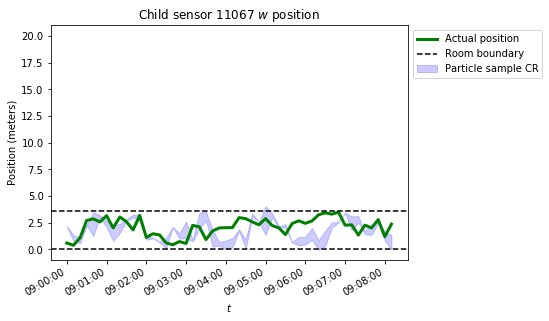

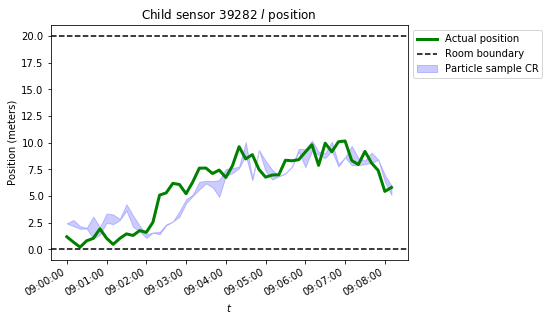

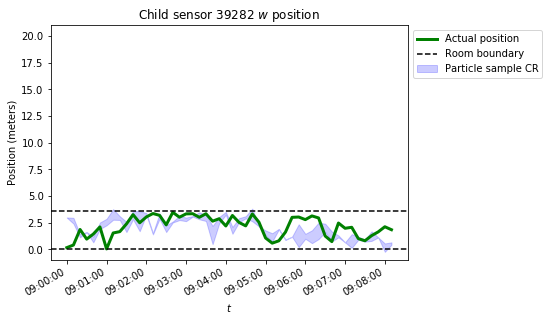

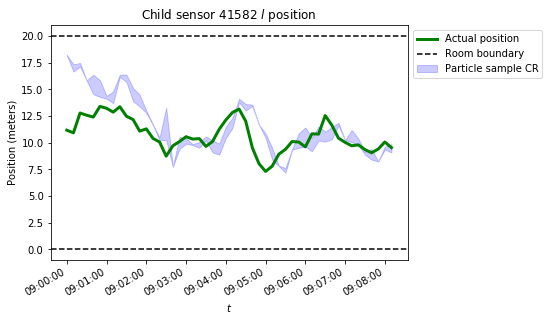

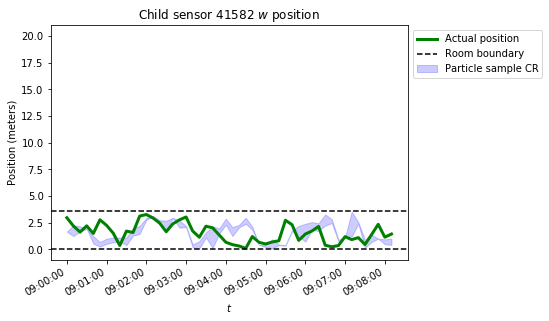

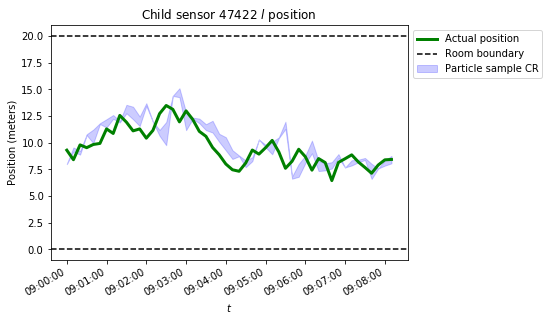

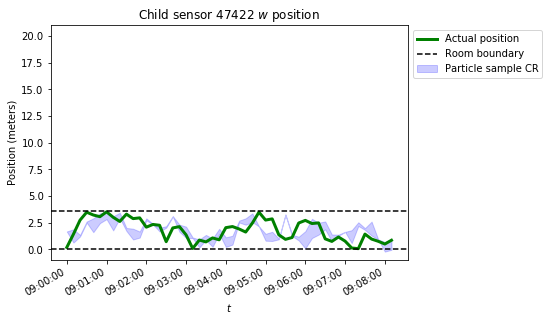

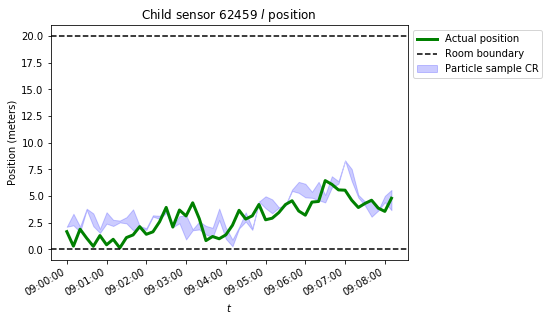

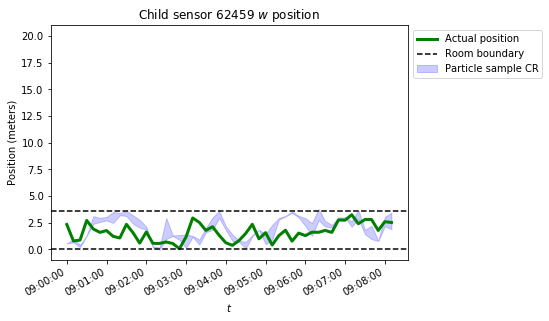

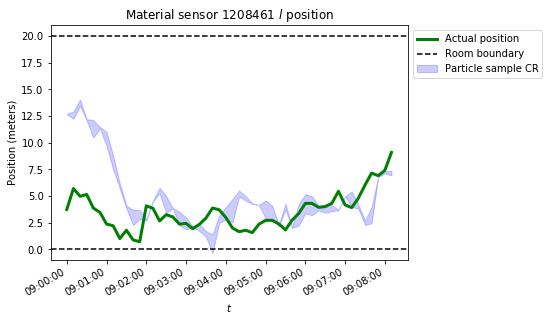

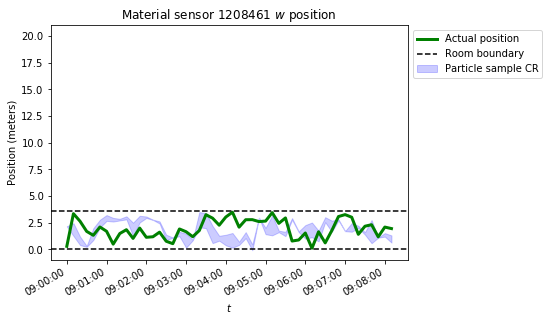

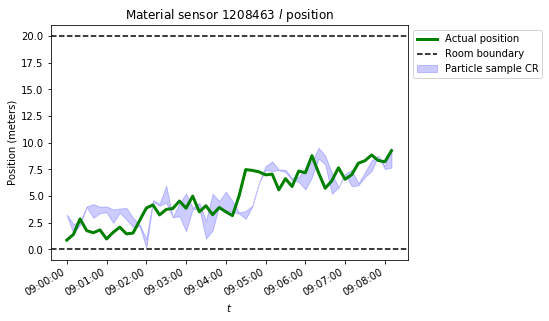

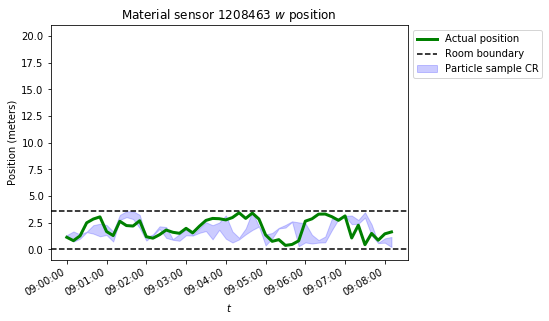

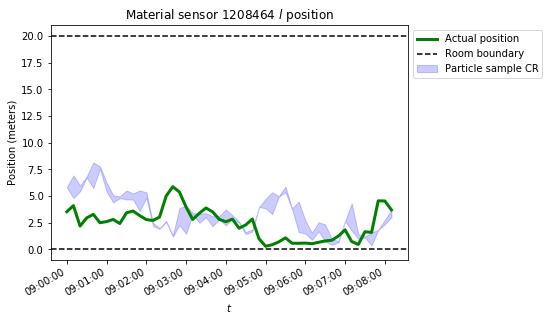

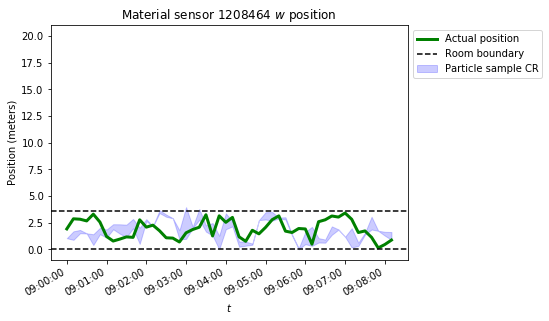

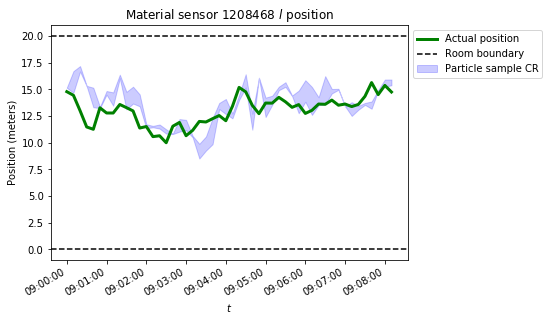

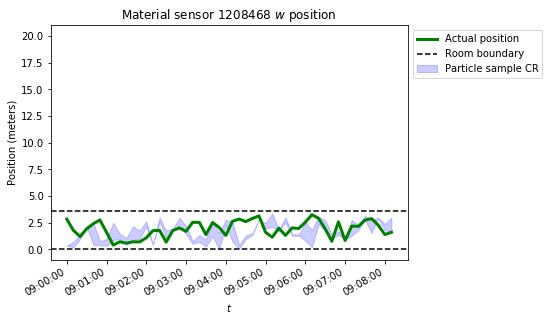

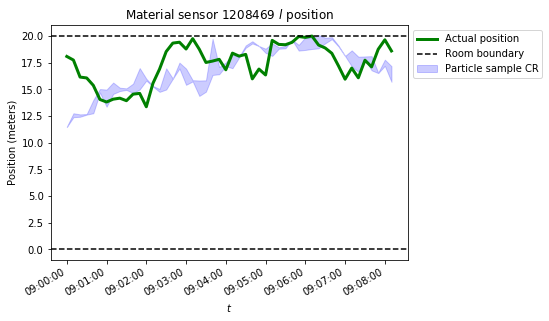

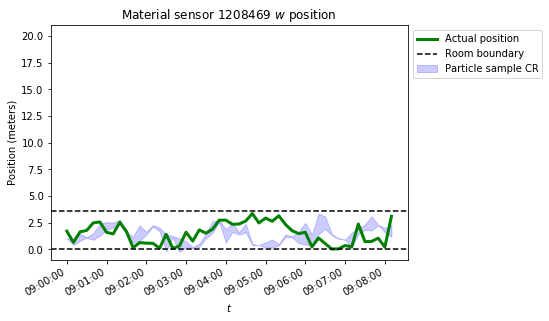

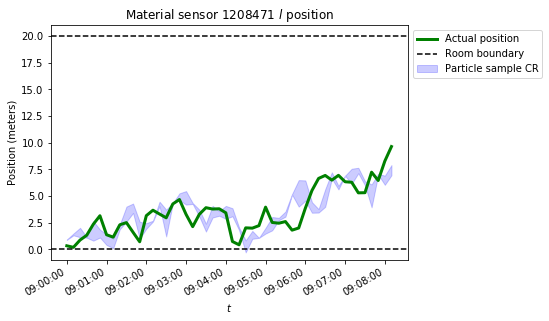

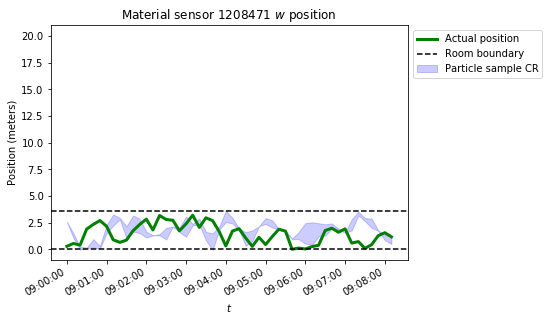

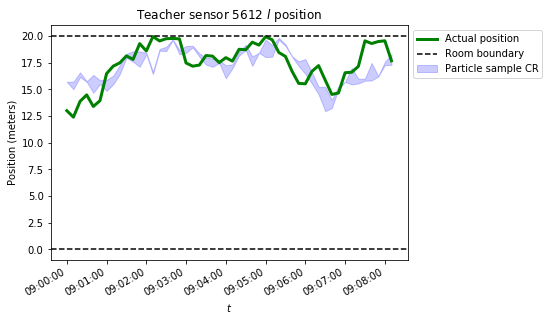

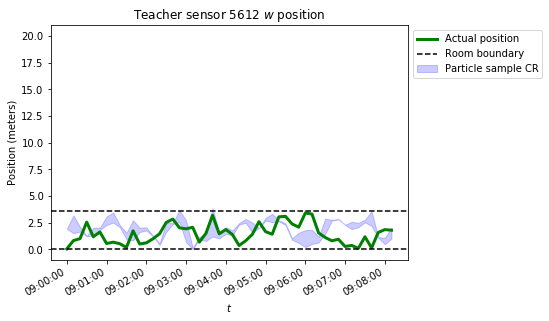

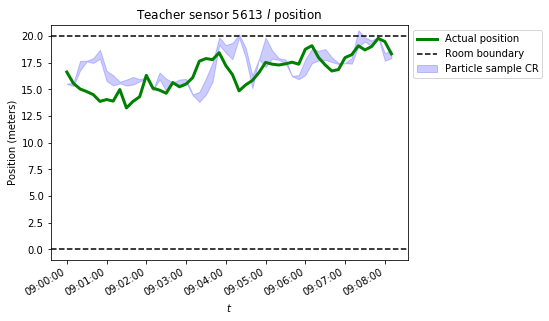

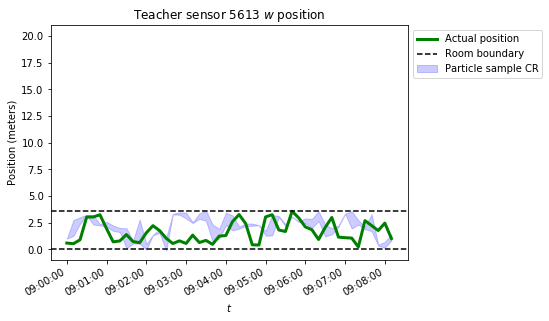

In [83]:
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
for x_var_index in range(variable_structure.num_x_continuous_vars):
    plt.plot(t_sim, x_continuous_t_sim[:,x_var_index], 'g-', linewidth=3.0, label='Actual position')
    plt.fill_between(
        t_sim,
        x_continuous_mean_particle_sim[:,x_var_index] - x_continuous_sd_particle_sim[:, x_var_index],
        x_continuous_mean_particle_sim[:,x_var_index] + x_continuous_sd_particle_sim[:, x_var_index],
        color='blue',
        alpha=0.2,
        label='Particle sample CR'
    )
    plt.gcf().autofmt_xdate()
    plt.axhline(0, color='black', linestyle='dashed', label='Room boundary')
    plt.axhline(room_size[x_var_index % 2], color='black', linestyle='dashed')
    plt.ylim(0 - 0.05*np.max(room_size),
             np.max(room_size) + 0.05*np.max(room_size))
    plt.xlabel('$t$')
    plt.ylabel('Position (meters)')
    plt.title(variable_structure.x_continuous_names[x_var_index])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
    plt.show()
plt.rcParams["date.autoformatter.minute"] = plt.rcParamsDefault["date.autoformatter.minute"]